# Обучение с подкреплением для Lux AI Season 2 🤖

Часть 2 серии RL теперь посвящена созданию работающего агента RL для Lux AI Challenge, Season 2!

Lux AI спроектирован так, чтобы быть интуитивно понятным, но с большим количеством уровней сложности и взаимодействия игровой механики в многоагентной кооперативной и конкурентной среде.

С правилами Lux AI Season 2 можно ознакомиться здесь: https://www.lux-ai.org/specs-s2. Обязательно прочитайте их, чтобы узнать, как работает игра, и остальную часть этого руководства будет намного легче понять.

В первой части серии была рассмотрена настройка RL с одним агентом, а во втором сезоне Lux AI — несколько агентов! Кроме того, среда имеет разные фазы и сложное пространство действий, что затрудняет изучение или использование из коробки.

В этом руководстве будут рассмотрены простые инструменты и приемы, как превратить сложную проблему в более легкую! В первую очередь мы сосредоточимся на трех вещах:

1. Упрощение пространства действий с помощью контроллеров/оберток действий
2. Упрощение наблюдений
3. Преобразование трехфазной игры Lux AI в однофазную игру.

Этот стартовый набор также реализован в https://github.com/Lux-AI-Challenge/Lux-Design-S2/tree/main/kits/rl/sb3.

Мы настоятельно **рекомендуем запускать этот код на графическом процессоре**, так как обучение RL может быть довольно медленным и требует хорошей настройки.

## 1. Упрощение пространства действий

Пространство действий в Lux S2 довольно сложное, так как каждый робот может двигаться, копать, передавать/подбирать, и все это в дополнение к возможности комбинировать любую последовательность этих примитивов в очередь действий длиной до 20. Для машинного обучения такой огромное пространство для действий приводит к [проклятию размерности](https://en.wikipedia.org/wiki/Проклятие_размерности), из-за чего любому алгоритму машинного обучения гораздо труднее изучить что-то полезное, особенно в РЛ.

Чтобы справиться с этим, мы можем запрограммировать собственный контроллер, который переводит действия из одного пространства действий в исходное пространство действий и добавляет несколько приемов и эвристик для интеграции с обучением RL. Поскольку исходное пространство действия lux большое, этот контроллер может быть немного сложным. Для тех, кто хочет сразу погрузиться в тренировку, вы можете использовать контроллер как есть.

Для общего обзора этот контроллер будет
- Определять сильно упрощенное пространство действий
- Переводить действия из дискретного пространства действий в пространство действий Lux S2 `action_to<_>lux_action`
- Добавлять евристику в виде действия для фабрики, чтобы построить одного тяжелого робота.
- Генерировать шаблоны действий, где False эквивалентно недействительному действию

В целом, пространство действий контроллера представляет собой дискретное пространство действий всего с 12 измерениями для управления только одним тяжелым роботом. Это позволит роботу двигаться в 4 направлениях, перемещать воду в 4 направлениях помимо центра, набирать энергию, копать и бездействовать. Сюда не входят действия фабрик, самоуничтожение, перезарядка, передача других типов ресурсов или более длительные запланированные очереди действий в пространстве действий, которые являются открытыми проблемами, которые вы потенциально можете решить!

Контроллер также включает в себя прием, позволяющий агентам снизить затраты на зарядку, связанные с обновлениями очереди действий. Контроллер пропускает обновление очередей действий, если существующая очередь действий совпадает с новой, которую агент хочет использовать для робота.

Хотя это упрощение не включает в себя добавление более сложных вещей, таких как более тяжелые роботы или посадка лишайников, оно позволит разработать успешную политику, которая с помощью простых модификаций превзойдет большинство ботов, использующих стартовые наборы на основе правил.

Более продвинутые варианты использования могут рассмотреть возможность моделирования действий различных типов юнитов на игровом поле (например, тяжелых, легких или заводов) с использованием пространства действий MultiDiscrete. Более практичным и, вероятно, выигрышным решением может быть использование опирающегося на изображения контроллера, генерирующего действия для каждой клетки на доске и использующего только действия с дружественными юнитами на этой клетке. См. [Решение первого сезона от ToadBrigade] (https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) и нашу предыдущую исследовательскую работу: Emergent Collective Intelligence from Massive-Agent Cooperator and Competition]( https://arxiv.org/abs/2301.01609) о том, как может работать подобный image-like контроллер.

In [1]:
import sys
from typing import Any, Dict

import numpy as np
import numpy.typing as npt
from gym import spaces


# Controller class copied here since you won't have access to the luxai_s2 package directly on the competition server
class Controller:
    def __init__(self, action_space: spaces.Space) -> None:
        self.action_space = action_space

    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
    ):
        """
        Takes as input the current "raw observation" and the parameterized action and returns
        an action formatted for the Lux env
        """
        raise NotImplementedError()

    def action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Generates a boolean action mask indicating in each discrete dimension whether it would be valid or not
        """
        raise NotImplementedError()


class SimpleUnitDiscreteController(Controller):
    def __init__(self, env_cfg) -> None:
        """
        A simple controller that controls only the robot that will get spawned.
        Moreover, it will always try to spawn one heavy robot if there are none regardless of action given

        For the robot unit
        - 4 cardinal direction movement (4 dims)
        - a move center no-op action (1 dim)
        - transfer action just for transferring ice in 4 cardinal directions or center (5)
        - pickup action for power (1 dims)
        - dig action (1 dim)
        - no op action (1 dim) - equivalent to not submitting an action queue which costs power

        It does not include
        - self destruct action
        - recharge action
        - planning (via actions executing multiple times or repeating actions)
        - factory actions
        - transferring power or resources other than ice

        To help understand how to this controller works to map one action space to the original lux action space,
        see how the lux action space is defined in luxai_s2/spaces/action.py

        """
        self.env_cfg = env_cfg
        self.move_act_dims = 4
        self.transfer_act_dims = 5
        self.pickup_act_dims = 1
        self.dig_act_dims = 1
        self.no_op_dims = 1

        self.move_dim_high = self.move_act_dims
        self.transfer_dim_high = self.move_dim_high + self.transfer_act_dims
        self.pickup_dim_high = self.transfer_dim_high + self.pickup_act_dims
        self.dig_dim_high = self.pickup_dim_high + self.dig_act_dims
        self.no_op_dim_high = self.dig_dim_high + self.no_op_dims

        self.total_act_dims = self.no_op_dim_high
        action_space = spaces.Discrete(self.total_act_dims)
        super().__init__(action_space)

    def _is_move_action(self, id):
        return id < self.move_dim_high

    def _get_move_action(self, id):
        # move direction is id + 1 since we don't allow move center here
        return np.array([0, id + 1, 0, 0, 0, 1])

    def _is_transfer_action(self, id):
        return id < self.transfer_dim_high

    def _get_transfer_action(self, id):
        id = id - self.move_dim_high
        transfer_dir = id % 5
        return np.array([1, transfer_dir, 0, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_pickup_action(self, id):
        return id < self.pickup_dim_high

    def _get_pickup_action(self, id):
        return np.array([2, 0, 4, self.env_cfg.max_transfer_amount, 0, 1])

    def _is_dig_action(self, id):
        return id < self.dig_dim_high

    def _get_dig_action(self, id):
        return np.array([3, 0, 0, 0, 0, 1])

    def action_to_lux_action(
        self, agent: str, obs: Dict[str, Any], action: npt.NDArray
    ):
        shared_obs = obs["player_0"]
        lux_action = dict()
        units = shared_obs["units"][agent]
        for unit_id in units.keys():
            unit = units[unit_id]
            choice = action
            action_queue = []
            no_op = False
            if self._is_move_action(choice):
                action_queue = [self._get_move_action(choice)]
            elif self._is_transfer_action(choice):
                action_queue = [self._get_transfer_action(choice)]
            elif self._is_pickup_action(choice):
                action_queue = [self._get_pickup_action(choice)]
            elif self._is_dig_action(choice):
                action_queue = [self._get_dig_action(choice)]
            else:
                # action is a no_op, so we don't update the action queue
                no_op = True

            # simple trick to help agents conserve power is to avoid updating the action queue
            # if the agent was previously trying to do that particular action already
            if len(unit["action_queue"]) > 0 and len(action_queue) > 0:
                same_actions = (unit["action_queue"][0] == action_queue[0]).all()
                if same_actions:
                    no_op = True
            if not no_op:
                lux_action[unit_id] = action_queue

            break

        factories = shared_obs["factories"][agent]
        if len(units) == 0:
            for unit_id in factories.keys():
                lux_action[unit_id] = 1  # build a single heavy

        return lux_action

    def action_masks(self, agent: str, obs: Dict[str, Any]):
        """
        Defines a simplified action mask for this controller's action space

        Doesn't account for whether robot has enough power
        """

        # compute a factory occupancy map that will be useful for checking if a board tile
        # has a factory and which team's factory it is.
        shared_obs = obs[agent]
        factory_occupancy_map = (
            np.ones_like(shared_obs["board"]["rubble"], dtype=int) * -1
        )
        factories = dict()
        for player in shared_obs["factories"]:
            factories[player] = dict()
            for unit_id in shared_obs["factories"][player]:
                f_data = shared_obs["factories"][player][unit_id]
                f_pos = f_data["pos"]
                # store in a 3x3 space around the factory position it's strain id.
                factory_occupancy_map[
                    f_pos[0] - 1 : f_pos[0] + 2, f_pos[1] - 1 : f_pos[1] + 2
                ] = f_data["strain_id"]

        units = shared_obs["units"][agent]
        action_mask = np.zeros((self.total_act_dims), dtype=bool)
        for unit_id in units.keys():
            action_mask = np.zeros(self.total_act_dims)
            # movement is always valid
            action_mask[:4] = True

            # transferring is valid only if the target exists
            unit = units[unit_id]
            pos = np.array(unit["pos"])
            # a[1] = direction (0 = center, 1 = up, 2 = right, 3 = down, 4 = left)
            move_deltas = np.array([[0, 0], [0, -1], [1, 0], [0, 1], [-1, 0]])
            for i, move_delta in enumerate(move_deltas):
                transfer_pos = np.array(
                    [pos[0] + move_delta[0], pos[1] + move_delta[1]]
                )
                # check if theres a factory tile there
                if (
                    transfer_pos[0] < 0
                    or transfer_pos[1] < 0
                    or transfer_pos[0] >= len(factory_occupancy_map)
                    or transfer_pos[1] >= len(factory_occupancy_map[0])
                ):
                    continue
                factory_there = factory_occupancy_map[transfer_pos[0], transfer_pos[1]]
                if factory_there in shared_obs["teams"][agent]["factory_strains"]:
                    action_mask[
                        self.transfer_dim_high - self.transfer_act_dims + i
                    ] = True

            factory_there = factory_occupancy_map[pos[0], pos[1]]
            on_top_of_factory = (
                factory_there in shared_obs["teams"][agent]["factory_strains"]
            )

            # dig is valid only if on top of tile with rubble or resources or lichen
            board_sum = (
                shared_obs["board"]["ice"][pos[0], pos[1]]
                + shared_obs["board"]["ore"][pos[0], pos[1]]
                + shared_obs["board"]["rubble"][pos[0], pos[1]]
                + shared_obs["board"]["lichen"][pos[0], pos[1]]
            )
            if board_sum > 0 and not on_top_of_factory:
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = True

            # pickup is valid only if on top of factory tile
            if on_top_of_factory:
                action_mask[
                    self.pickup_dim_high - self.pickup_act_dims : self.pickup_dim_high
                ] = True
                action_mask[
                    self.dig_dim_high - self.dig_act_dims : self.dig_dim_high
                ] = False

            # no-op is always valid
            action_mask[-1] = True
            break
        return action_mask


## 2. Упрощение пространства наблюдения

Lux S2 полностью наблюдаем, что означает, что вы можете видеть все на карте, юниты противника и т. д. Однако это очень многомерное и не обязательно легкое изучение из-за проклятия размерности (опять же!). Мы хотим упростить это пространство наблюдения таким образом, чтобы оно содержало достаточно информации для изучения хорошей политики, но при этом было легко учиться.

Для этого урока мы создадим пространство наблюдения на основе состояния (без изображений, таких как объекты, например, щебень, лед, карта руды) с некоторыми инженерными функциями, которые включают полезную информацию, такую как расстояние до ближайшей фабрики или клетки со льдом. Оболочка, которую мы приводим ниже, будет использовать интерфейс `gym.ObservationWrapper`. Обратите внимание: поскольку мы фокусируемся только на управлении одним тяжелым роботом, оболочка наблюдения написана для поддержки только одного тяжелого робота (и возвращает 0, если их нет).

Более продвинутые решения могут использовать полный набор наблюдений и разработать соответствующую архитектуру нейронной сети для их обработки. Одной из идей было бы использование сверточных нейронных сетей для обработки таких элементов доски, как изображения. См. [Решение первого сезона от ToadBrigade] (https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) и нашу предыдущую исследовательскую работу: Emergent Collective Intelligence from Massive-Agent Cooperator and Competition]( https://arxiv.org/abs/2301.01609), например, выбор архитектур и технических характеристик.

In [2]:
from typing import Any, Dict

import gym
import numpy as np
import numpy.typing as npt
from gym import spaces


class SimpleUnitObservationWrapper(gym.ObservationWrapper):
    """
    A simple state based observation to work with in pair with the SimpleUnitDiscreteController

    It contains info only on the first robot, the first factory you own, and some useful features. If there are no owned robots the observation is just zero.
    No information about the opponent is included. This will generate observations for all teams.

    Included features:
    - First robot's stats
    - distance vector to closest ice tile
    - distance vector to first factory

    """

    def __init__(self, env: gym.Env) -> None:
        super().__init__(env)
        self.observation_space = spaces.Box(-999, 999, shape=(13,))

    def observation(self, obs):
        return SimpleUnitObservationWrapper.convert_obs(obs, self.env.state.env_cfg)

    # we make this method static so the submission/evaluation code can use this as well
    @staticmethod
    def convert_obs(obs: Dict[str, Any], env_cfg: Any) -> Dict[str, npt.NDArray]:
        observation = dict()
        shared_obs = obs["player_0"]
        ice_map = shared_obs["board"]["ice"]
        ice_tile_locations = np.argwhere(ice_map == 1)

        for agent in obs.keys():
            obs_vec = np.zeros(
                13,
            )

            factories = shared_obs["factories"][agent]
            factory_vec = np.zeros(2)
            for k in factories.keys():
                # here we track a normalized position of the first friendly factory
                factory = factories[k]
                factory_vec = np.array(factory["pos"]) / env_cfg.map_size
                break
            units = shared_obs["units"][agent]
            for k in units.keys():
                unit = units[k]

                # store cargo+power values scaled to [0, 1]
                cargo_space = env_cfg.ROBOTS[unit["unit_type"]].CARGO_SPACE
                battery_cap = env_cfg.ROBOTS[unit["unit_type"]].BATTERY_CAPACITY
                cargo_vec = np.array(
                    [
                        unit["power"] / battery_cap,
                        unit["cargo"]["ice"] / cargo_space,
                        unit["cargo"]["ore"] / cargo_space,
                        unit["cargo"]["water"] / cargo_space,
                        unit["cargo"]["metal"] / cargo_space,
                    ]
                )
                unit_type = (
                    0 if unit["unit_type"] == "LIGHT" else 1
                )  # note that build actions use 0 to encode Light
                # normalize the unit position
                pos = np.array(unit["pos"]) / env_cfg.map_size
                unit_vec = np.concatenate(
                    [pos, [unit_type], cargo_vec, [unit["team_id"]]], axis=-1
                )

                # we add some engineered features down here
                # compute closest ice tile
                ice_tile_distances = np.mean(
                    (ice_tile_locations - np.array(unit["pos"])) ** 2, 1
                )
                # normalize the ice tile location
                closest_ice_tile = (
                    ice_tile_locations[np.argmin(ice_tile_distances)] / env_cfg.map_size
                )
                obs_vec = np.concatenate(
                    [unit_vec, factory_vec - pos, closest_ice_tile - pos], axis=-1
                )
                break
            observation[agent] = obs_vec

        return observation

## 3. Преобразование Lux S2 в эпизод, состоящий из одной фазы.

Обычно фреймворки RL, такие как Stable Baselines 3, RLlib, Tianshou и т. д., предполагают, что пространство действия и пространство наблюдения должны быть одинаковыми на протяжении всего эпизода. Lux S2 не соответствует этому, поскольку мы добавляем некоторые дополнительные сложности, такие как этап торгов и размещения дополнительной фабрики. Простой способ обойти это — **обновить функцию сброса.**

Ранее мы видели, что `env.reset()` сбрасывает среду до чистого листа. Мы модернизируем эту функцию, создав оболочку среды, которая не только сбрасывает все с чистого листа, но и обрабатывает этап торгов и размещения фабрики, чтобы агенты, которые учатся, начиналис игровых состояний с уже размещенными фабриками.

Ниже будет собрана оболочка, работающая с пакетом SB3. Для этого мы хотим предоставить оболочке политику назначения ставок и политику размещения заводов, которые будут использоваться для обработки первых двух этапов функции функции сброса. Приведенный ниже код делает именно это, переопределяя функцию сброса среды в оболочке.

Кроме того, мы хотим использовать контроллер, который мы определили ранее, поэтому он также является аргументом SB3Wrapper, и мы используем его для преобразования действий внутри функции `env.step`

In [3]:
from typing import Callable, Dict

import gym
import numpy as np
import numpy.typing as npt
from gym import spaces

import luxai_s2.env
from luxai_s2.env import LuxAI_S2
from luxai_s2.state import ObservationStateDict
from luxai_s2.unit import ActionType, BidActionType, FactoryPlacementActionType
from luxai_s2.utils import my_turn_to_place_factory
from luxai_s2.wrappers.controllers import (
    Controller,
)


class SB3Wrapper(gym.Wrapper):
    def __init__(
        self,
        env: LuxAI_S2,
        bid_policy: Callable[
            [str, ObservationStateDict], Dict[str, BidActionType]
        ] = None,
        factory_placement_policy: Callable[
            [str, ObservationStateDict], Dict[str, FactoryPlacementActionType]
        ] = None,
        controller: Controller = None,
    ) -> None:
        """
        A environment wrapper for Stable Baselines 3. It reduces the LuxAI_S2 env
        into a single phase game and places the first two phases (bidding and factory placement) into the env.reset function so that
        interacting agents directly start generating actions to play the third phase of the game.

        It also accepts a Controller that translates action's in one action space to a Lux S2 compatible action

        Parameters
        ----------
        bid_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a bid action
            such as dict(bid=10, faction="AlphaStrike"). By default will bid 0
        factory_placement_policy: Function
            A function accepting player: str and obs: ObservationStateDict as input that returns a factory placement action
            such as dict(spawn=np.array([2, 4]), metal=150, water=150). By default will spawn in a random valid location with metal=150, water=150
        controller : Controller
            A controller that parameterizes the action space into something more usable and converts parameterized actions to lux actions.
            See luxai_s2/wrappers/controllers.py for available controllers and how to make your own
        """
        gym.Wrapper.__init__(self, env)
        self.env = env
        
        assert controller is not None
        
        # set our controller and replace the action space
        self.controller = controller
        self.action_space = controller.action_space

        # The simplified wrapper removes the first two phases of the game by using predefined policies (trained or heuristic)
        # to handle those two phases during each reset
        if factory_placement_policy is None:
            def factory_placement_policy(player, obs: ObservationStateDict):
                potential_spawns = np.array(
                    list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
                )
                spawn_loc = potential_spawns[
                    np.random.randint(0, len(potential_spawns))
                ]
                return dict(spawn=spawn_loc, metal=150, water=150)

        self.factory_placement_policy = factory_placement_policy
        if bid_policy is None:
            def bid_policy(player, obs: ObservationStateDict):
                faction = "AlphaStrike"
                if player == "player_1":
                    faction = "MotherMars"
                return dict(bid=0, faction=faction)

        self.bid_policy = bid_policy

        self.prev_obs = None

    def step(self, action: Dict[str, npt.NDArray]):
        
        # here, for each agent in the game we translate their action into a Lux S2 action
        lux_action = dict()
        for agent in self.env.agents:
            if agent in action:
                lux_action[agent] = self.controller.action_to_lux_action(
                    agent=agent, obs=self.prev_obs, action=action[agent]
                )
            else:
                lux_action[agent] = dict()
        
        # lux_action is now a dict mapping agent name to an action
        obs, reward, done, info = self.env.step(lux_action)
        self.prev_obs = obs
        return obs, reward, done, info

    def reset(self, **kwargs):
        # we upgrade the reset function here
        
        # we call the original reset function first
        obs = self.env.reset(**kwargs)
        
        # then use the bid policy to go through the bidding phase
        action = dict()
        for agent in self.env.agents:
            action[agent] = self.bid_policy(agent, obs[agent])
        obs, _, _, _ = self.env.step(action)
        
        # while real_env_steps < 0, we are in the factory placement phase
        # so we use the factory placement policy to step through this
        while self.env.state.real_env_steps < 0:
            action = dict()
            for agent in self.env.agents:
                if my_turn_to_place_factory(
                    obs["player_0"]["teams"][agent]["place_first"],
                    self.env.state.env_steps,
                ):
                    action[agent] = self.factory_placement_policy(agent, obs[agent])
                else:
                    action[agent] = dict()
            obs, _, _, _ = self.env.step(action)
        self.prev_obs = obs
        
        return obs


### Определение политики Bid и Factory Placement

Чтобы протестировать приведенный выше код, мы можем запрограммировать некоторые эвристические политики ставок и фабричных размещений.

In [4]:
def zero_bid(player, obs):
    # a policy that always bids 0
    faction = "AlphaStrike"
    if player == "player_1":
        faction = "MotherMars"
    return dict(bid=0, faction=faction)

def place_near_random_ice(player, obs):
    """
    This policy will place a single factory with all the starting resources
    near a random ice tile
    """
    if obs["teams"][player]["metal"] == 0:
        return dict()
    potential_spawns = list(zip(*np.where(obs["board"]["valid_spawns_mask"] == 1)))
    potential_spawns_set = set(potential_spawns)
    done_search = False
    
    # simple numpy trick to find locations adjacent to ice tiles.
    ice_diff = np.diff(obs["board"]["ice"])
    pot_ice_spots = np.argwhere(ice_diff == 1)
    if len(pot_ice_spots) == 0:
        pot_ice_spots = potential_spawns
    
    # pick a random ice spot and search around it for spawnable locations.
    trials = 5
    while trials > 0:
        pos_idx = np.random.randint(0, len(pot_ice_spots))
        pos = pot_ice_spots[pos_idx]
        area = 3
        for x in range(area):
            for y in range(area):
                check_pos = [pos[0] + x - area // 2, pos[1] + y - area // 2]
                if tuple(check_pos) in potential_spawns_set:
                    done_search = True
                    pos = check_pos
                    break
            if done_search:
                break
        if done_search:
            break
        trials -= 1
    
    if not done_search:
        spawn_loc = potential_spawns[np.random.randint(0, len(potential_spawns))]
        pos = spawn_loc
    
    # this will spawn a factory at pos and with all the starting metal and water
    metal = obs["teams"][player]["metal"]
    return dict(spawn=pos, metal=metal, water=metal)

Итак, **без оболочки**, когда мы сбрасываем среду, это выглядит так:

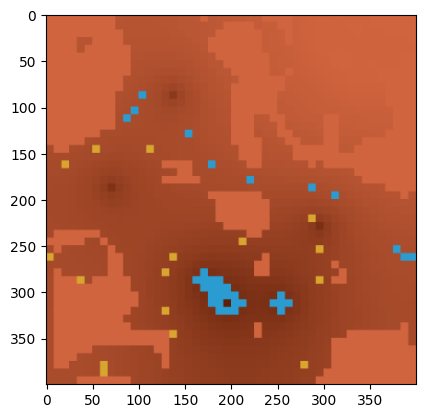

In [5]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

**С оберткой**, когда мы сбрасываем среду, это выглядит так:

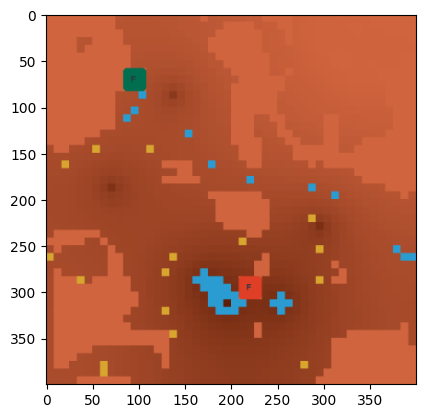

In [6]:
import matplotlib.pyplot as plt
env = gym.make("LuxAI_S2-v0")
env = SB3Wrapper(env, zero_bid, place_near_random_ice, controller=SimpleUnitDiscreteController(env.env_cfg))
env.reset(seed=0)
img = env.render("rgb_array")
plt.imshow(img)

Успех! Благодаря нашей обновленной функции сброса окружение теперь запускается с начала основной фазы игры, а это означает, что пространство действий может быть одним и тем же на протяжении всей игры.

## 4. Тренировка с RL

В предыдущем руководстве мы увидели, как обучить агента с помощью SB3 в среде с одним агентом. Работа с настоящими несколькими агентами путем обучения отдельных или общих политик для управления всеми агентами требует нескольких дополнительных вещей, поэтому вместо этого в целях руководства мы будем рассматривать Lux S2 как среду с одним агентом, обучая политику для одной команды, в то время как другая команда просто ничего не делает.

Кроме того, мы хотим определить нашу собственную функцию вознаграждения, чтобы побуждать наших роботов искать лед, копать его и возвращаться на фабрику, чтобы они могли производить воду и дольше выживать. Чтобы сделать все это, мы просто создадим пользовательскую оболочку среды.

In [7]:
import copy
class CustomEnvWrapper(gym.Wrapper):
    def __init__(self, env: gym.Env) -> None:
        """
        Adds a custom reward and turns the LuxAI_S2 environment into a single-agent environment for easy training
        """
        super().__init__(env)
        self.prev_step_metrics = None

    def step(self, action):
        agent = "player_0"
        opp_agent = "player_1"

        opp_factories = self.env.state.factories[opp_agent]
        for k in opp_factories.keys():
            factory = opp_factories[k]
             # set enemy factories to have 1000 water to keep them alive the whole around and treat the game as single-agent
            factory.cargo.water = 1000

        # submit actions for just one agent to make it single-agent
        # and save single-agent versions of the data below
        action = {agent: action}
        obs, _, done, info = self.env.step(action)
        obs = obs[agent]
        done = done[agent]
        
        # we collect stats on teams here. These are useful stats that can be used to help generate reward functions
        stats: StatsStateDict = self.env.state.stats[agent]

        info = dict()
        metrics = dict()
        metrics["ice_dug"] = (
            stats["generation"]["ice"]["HEAVY"] + stats["generation"]["ice"]["LIGHT"]
        )
        metrics["water_produced"] = stats["generation"]["water"]

        # we save these two to see often the agent updates robot action queues and how often enough
        # power to do so and succeed (less frequent updates = more power is saved)
        metrics["action_queue_updates_success"] = stats["action_queue_updates_success"]
        metrics["action_queue_updates_total"] = stats["action_queue_updates_total"]

        # we can save the metrics to info so we can use tensorboard to log them to get a glimpse into how our agent is behaving
        info["metrics"] = metrics

        reward = 0
        if self.prev_step_metrics is not None:
            # we check how much ice and water is produced and reward the agent for generating both
            ice_dug_this_step = metrics["ice_dug"] - self.prev_step_metrics["ice_dug"]
            water_produced_this_step = (
                metrics["water_produced"] - self.prev_step_metrics["water_produced"]
            )
            # we reward water production more as it is the most important resource for survival
            reward = ice_dug_this_step / 100 + water_produced_this_step

        self.prev_step_metrics = copy.deepcopy(metrics)
        return obs, reward, done, info

    def reset(self, **kwargs):
        obs = self.env.reset(**kwargs)["player_0"]
        self.prev_step_metrics = None
        return obs

### 3.1 Определение среды и использование оболочек

Далее мы определим функцию `make_env` и используем ее с SB3 для параллельного создания нескольких сред, которые масштабируются в зависимости от количества имеющихся у вас ядер ЦП. В будущем руководстве будет показан вариант, который создает единую среду на основе jax для достижения той же функциональности, но с масштабированием с помощью графического процессора.

Мы будем использовать SB3Wrapper, определенные нами контроллер и оболочку наблюдения, а также пользовательскую оболочку env. Вместе они дадут нам среду, которая сбрасывается к началу обычной фазы игры, имеет последовательное и упрощенное пространство для наблюдения и действий, а также содержит нашу функцию вознаграждения.

In [8]:
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from gym.wrappers import TimeLimit
def make_env(env_id: str, rank: int, seed: int = 0, max_episode_steps=200):
    def _init() -> gym.Env:
        # verbose = 0
        # collect_stats=True lets us track stats like total ice dug during an episode to help create reward functions
        # max factories set to 2 for simplification and keeping returns consistent as we survive longer 
        # if there are more initial resources
        env = gym.make(env_id, verbose=0, collect_stats=True, MAX_FACTORIES=2)

        # Add a SB3 wrapper to make it work with SB3 and simplify the action space with the controller
        # this will remove the bidding phase and factory placement phase. For factory placement we use
        # the provided place_near_random_ice function which will randomly select an ice tile and place a factory near it.
        env = SB3Wrapper(
            env,
            factory_placement_policy=place_near_random_ice,
            controller=SimpleUnitDiscreteController(env.env_cfg),
        )
        
        # changes observation to include a few simple features
        env = SimpleUnitObservationWrapper(
            env
        )
        
        # convert to single agent, adds our reward
        env = CustomEnvWrapper(env)  
        
        # Add a timelimit to the environment, which can truncate episodes, speed up training
        env = TimeLimit(
            env, max_episode_steps=max_episode_steps
        )
        env = Monitor(env) # for SB3 to allow it to record metrics
        env.reset(seed=seed + rank)
        set_random_seed(seed)
        return env

    return _init

Далее мы определим полезную функцию обратного вызова для регистрации некоторых пользовательских показателей, которые мы определили ранее в CustomEnvWrapper.

In [9]:
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
class TensorboardCallback(BaseCallback):
    def __init__(self, tag: str, verbose=0):
        super().__init__(verbose)
        self.tag = tag

    def _on_step(self) -> bool:
        c = 0

        for i, done in enumerate(self.locals["dones"]):
            if done:
                info = self.locals["infos"][i]
                c += 1
                for k in info["metrics"]:
                    stat = info["metrics"][k]
                    self.logger.record_mean(f"{self.tag}/{k}", stat)
        return True

### 3.2 Настройка обучения

Теперь мы можем подготовиться к обучению, создав среду обучения и оценки, а также определив наш алгоритм и модель.

In [10]:
import os.path as osp
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.ppo import PPO

set_random_seed(42)
log_path = "logs/example_fit"
num_envs = 4

# set max episode steps to 200 for training environments to train faster
env = SubprocVecEnv([make_env("LuxAI_S2-v0", i, max_episode_steps=200) for i in range(num_envs)])
env.reset()
# set max episode steps to 1000 to match original environment
eval_env = SubprocVecEnv([make_env("LuxAI_S2-v0", i, max_episode_steps=1000) for i in range(4)])
eval_env.reset()
rollout_steps = 4000
policy_kwargs = dict(net_arch=(128, 128))
model = PPO(
    "MlpPolicy",
    env,
    n_steps=rollout_steps // num_envs,
    batch_size=800,
    learning_rate=3e-4,
    policy_kwargs=policy_kwargs,
    verbose=1,
    n_epochs=2,
    target_kl=0.05,
    gamma=0.99,
    tensorboard_log=osp.join(log_path),
)

eval_callback = EvalCallback(
    eval_env,
    best_model_save_path=osp.join(log_path, "models"),
    log_path=osp.join(log_path, "eval_logs"),
    eval_freq=24_000,
    deterministic=False,
    render=False,
    n_eval_episodes=5,
)

Using cuda device


Теперь, когда наши функции обратного вызова и модель определены, мы можем начать обучение с использованием `model.learn`. На CPU это обучение может занять около 3-4 часов, на GPU это может занять от 30 минут до часа. Гиперпараметры и функцию вознаграждения можно улучшить, чтобы она обучалась намного быстрее. Простой способ также увеличить скорость обучения — это тренироваться на машине с большим количеством ядер ЦП и увеличивать num_envs выше. Блокноты Kaggle по умолчанию имеют только 4, но, например. 10 вы можете легко обучить политику примерно за 30 минут.

Если вы хотите пропустить это обучение, вы также можете просто использовать предварительно обученную модель, которая находится в загруженном наборе данных для комплекта RL под названием `best_model.dontunzipme`. (kaggle автоматически распаковывает файлы, но нам нужно сохранить его как zip, поэтому расширение файла называется .dontunzipme, но для отправки просто измените его на .zip)

Для отслеживания прогресса мы рекомендуем использовать tensorboard, с которым вы можете работать.
```
tensorboard --logdir logs
```

In [11]:
total_timesteps = 10_000_000
model.learn(
    total_timesteps,
    callback=[TensorboardCallback(tag="train_metrics"), eval_callback],
)
model.save(osp.join(log_path, "models/latest_model"))

Logging to logs/example_fit/PPO_1
----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 200      |
|    ep_rew_mean                  | 0        |
| time/                           |          |
|    fps                          | 1137     |
|    iterations                   | 1        |
|    time_elapsed                 | 3        |
|    total_timesteps              | 4000     |
| train_metrics/                  |          |
|    action_queue_updates_success | 147      |
|    action_queue_updates_total   | 178      |
|    ice_dug                      | 0        |
|    water_produced               | 0        |
----------------------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 0.145        |
| time/                           |              |
|    f

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 0.018        |
| time/                           |              |
|    fps                          | 1587         |
|    iterations                   | 8            |
|    time_elapsed                 | 20           |
|    total_timesteps              | 32000        |
| train/                          |              |
|    approx_kl                    | 0.0001860316 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -2.48        |
|    explained_variance           | 0.852        |
|    learning_rate                | 0.0003       |
|    loss                         | -0.00185     |
|    n_updates                    | 14           |
|    policy_gradient_loss         | -0.00064     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 0.086        |
| time/                           |              |
|    fps                          | 1626         |
|    iterations                   | 15           |
|    time_elapsed                 | 36           |
|    total_timesteps              | 60000        |
| train/                          |              |
|    approx_kl                    | 0.0003813467 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -2.45        |
|    explained_variance           | 0.754        |
|    learning_rate                | 0.0003       |
|    loss                         | -0.0017      |
|    n_updates                    | 28           |
|    policy_gradient_loss         | -0.000608    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 0.222        |
| time/                           |              |
|    fps                          | 1662         |
|    iterations                   | 22           |
|    time_elapsed                 | 52           |
|    total_timesteps              | 88000        |
| train/                          |              |
|    approx_kl                    | 0.0011169622 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -2.36        |
|    explained_variance           | 0.127        |
|    learning_rate                | 0.0003       |
|    loss                         | 0.113        |
|    n_updates                    | 42           |
|    policy_gradient_loss         | -0.00123     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 1.46         |
| time/                           |              |
|    fps                          | 1635         |
|    iterations                   | 28           |
|    time_elapsed                 | 68           |
|    total_timesteps              | 112000       |
| train/                          |              |
|    approx_kl                    | 0.0018268852 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -2.07        |
|    explained_variance           | 0.0696       |
|    learning_rate                | 0.0003       |
|    loss                         | 2.12         |
|    n_updates                    | 54           |
|    policy_gradient_loss         | -0.00104     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 2.54         |
| time/                           |              |
|    fps                          | 1636         |
|    iterations                   | 35           |
|    time_elapsed                 | 85           |
|    total_timesteps              | 140000       |
| train/                          |              |
|    approx_kl                    | 0.0005946213 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -2.04        |
|    explained_variance           | 0.0197       |
|    learning_rate                | 0.0003       |
|    loss                         | 0.878        |
|    n_updates                    | 68           |
|    policy_gradient_loss         | -0.000238    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 8.11          |
| time/                           |               |
|    fps                          | 1653          |
|    iterations                   | 42            |
|    time_elapsed                 | 101           |
|    total_timesteps              | 168000        |
| train/                          |               |
|    approx_kl                    | 0.00041794466 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.8          |
|    explained_variance           | 0.0329        |
|    learning_rate                | 0.0003        |
|    loss                         | 3.72          |
|    n_updates                    | 82            |
|    policy_gradient_loss         | -0.000376     |
|    value_l

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 10.2     |
| time/              |          |
|    fps             | 1656     |
|    iterations      | 48       |
|    time_elapsed    | 115      |
|    total_timesteps | 192000   |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 11.5         |
| time/                           |              |
|    fps                          | 1657         |
|    iterations                   | 49           |
|    time_elapsed                 | 118          |
|    total_timesteps              | 196000       |
| train/                          |              |
|    approx_kl                    | 0.0001580932 |
|    clip_fraction                | 0            |
|    clip_range           

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 8.2          |
| time/                           |              |
|    fps                          | 1663         |
|    iterations                   | 55           |
|    time_elapsed                 | 132          |
|    total_timesteps              | 220000       |
| train/                          |              |
|    approx_kl                    | 0.0014204921 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.57        |
|    explained_variance           | 0.026        |
|    learning_rate                | 0.0003       |
|    loss                         | 9.66         |
|    n_updates                    | 108          |
|    policy_gradient_loss         | -0.000825    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 20.2          |
| time/                           |               |
|    fps                          | 1677          |
|    iterations                   | 62            |
|    time_elapsed                 | 147           |
|    total_timesteps              | 248000        |
| train/                          |               |
|    approx_kl                    | 0.00042864418 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.53         |
|    explained_variance           | 0.0225        |
|    learning_rate                | 0.0003        |
|    loss                         | 9.39          |
|    n_updates                    | 122           |
|    policy_gradient_loss         | -0.000538     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 16.7          |
| time/                           |               |
|    fps                          | 1678          |
|    iterations                   | 69            |
|    time_elapsed                 | 164           |
|    total_timesteps              | 276000        |
| train/                          |               |
|    approx_kl                    | 0.00033706502 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.5          |
|    explained_variance           | 0.0312        |
|    learning_rate                | 0.0003        |
|    loss                         | 13.6          |
|    n_updates                    | 136           |
|    policy_gradient_loss         | -0.000393     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 14.6          |
| time/                           |               |
|    fps                          | 1669          |
|    iterations                   | 75            |
|    time_elapsed                 | 179           |
|    total_timesteps              | 300000        |
| train/                          |               |
|    approx_kl                    | 0.00021648384 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.62         |
|    explained_variance           | 0.131         |
|    learning_rate                | 0.0003        |
|    loss                         | 16.3          |
|    n_updates                    | 148           |
|    policy_gradient_loss         | -0.000182     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 23.2          |
| time/                           |               |
|    fps                          | 1675          |
|    iterations                   | 82            |
|    time_elapsed                 | 195           |
|    total_timesteps              | 328000        |
| train/                          |               |
|    approx_kl                    | 0.00029362613 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.72         |
|    explained_variance           | 0.225         |
|    learning_rate                | 0.0003        |
|    loss                         | 26.1          |
|    n_updates                    | 162           |
|    policy_gradient_loss         | 0.000197      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 15           |
| time/                           |              |
|    fps                          | 1676         |
|    iterations                   | 89           |
|    time_elapsed                 | 212          |
|    total_timesteps              | 356000       |
| train/                          |              |
|    approx_kl                    | 7.298606e-05 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.69        |
|    explained_variance           | 0.263        |
|    learning_rate                | 0.0003       |
|    loss                         | 22.7         |
|    n_updates                    | 176          |
|    policy_gradient_loss         | 7.27e-05     |
|    value_loss                

Eval num_timesteps=384000, episode_reward=69.40 +/- 80.14
Episode length: 367.00 +/- 76.12
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 367           |
|    mean_reward                  | 69.4          |
| time/                           |               |
|    total_timesteps              | 384000        |
| train/                          |               |
|    approx_kl                    | 0.00012395393 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.74         |
|    explained_variance           | 0.398         |
|    learning_rate                | 0.0003        |
|    loss                         | 8.28          |
|    n_updates                    | 190           |
|    policy_gradient_loss         | -1.23e-05     |
|    value_loss                   | 15.6          |
| train_metrics/         

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 13.5          |
| time/                           |               |
|    fps                          | 1670          |
|    iterations                   | 102           |
|    time_elapsed                 | 244           |
|    total_timesteps              | 408000        |
| train/                          |               |
|    approx_kl                    | 0.00032573438 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.41         |
|    explained_variance           | 0.284         |
|    learning_rate                | 0.0003        |
|    loss                         | 5.08          |
|    n_updates                    | 202           |
|    policy_gradient_loss         | 0.000163      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 20.8         |
| time/                           |              |
|    fps                          | 1676         |
|    iterations                   | 109          |
|    time_elapsed                 | 260          |
|    total_timesteps              | 436000       |
| train/                          |              |
|    approx_kl                    | 7.390922e-05 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.52        |
|    explained_variance           | 0.234        |
|    learning_rate                | 0.0003       |
|    loss                         | 29.1         |
|    n_updates                    | 216          |
|    policy_gradient_loss         | 2.29e-07     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 20.6         |
| time/                           |              |
|    fps                          | 1679         |
|    iterations                   | 116          |
|    time_elapsed                 | 276          |
|    total_timesteps              | 464000       |
| train/                          |              |
|    approx_kl                    | 0.0024854753 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.44        |
|    explained_variance           | 0.222        |
|    learning_rate                | 0.0003       |
|    loss                         | 43.7         |
|    n_updates                    | 230          |
|    policy_gradient_loss         | -0.00054     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 32.5          |
| time/                           |               |
|    fps                          | 1676          |
|    iterations                   | 122           |
|    time_elapsed                 | 291           |
|    total_timesteps              | 488000        |
| train/                          |               |
|    approx_kl                    | 0.00091242994 |
|    clip_fraction                | 0.000125      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.22         |
|    explained_variance           | 0.211         |
|    learning_rate                | 0.0003        |
|    loss                         | 20            |
|    n_updates                    | 242           |
|    policy_gradient_loss         | -0.000199     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 17.1          |
| time/                           |               |
|    fps                          | 1685          |
|    iterations                   | 129           |
|    time_elapsed                 | 306           |
|    total_timesteps              | 516000        |
| train/                          |               |
|    approx_kl                    | 0.00015752928 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.64         |
|    explained_variance           | 0.367         |
|    learning_rate                | 0.0003        |
|    loss                         | 12.5          |
|    n_updates                    | 256           |
|    policy_gradient_loss         | -0.000145     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 23.7          |
| time/                           |               |
|    fps                          | 1687          |
|    iterations                   | 136           |
|    time_elapsed                 | 322           |
|    total_timesteps              | 544000        |
| train/                          |               |
|    approx_kl                    | 0.00013342168 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.46         |
|    explained_variance           | 0.786         |
|    learning_rate                | 0.0003        |
|    loss                         | 2.4           |
|    n_updates                    | 270           |
|    policy_gradient_loss         | -0.000335     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 22.5          |
| time/                           |               |
|    fps                          | 1685          |
|    iterations                   | 143           |
|    time_elapsed                 | 339           |
|    total_timesteps              | 572000        |
| train/                          |               |
|    approx_kl                    | 0.00034183034 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.33         |
|    explained_variance           | 0.277         |
|    learning_rate                | 0.0003        |
|    loss                         | 34.6          |
|    n_updates                    | 284           |
|    policy_gradient_loss         | -7.98e-05     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 21.6         |
| time/                           |              |
|    fps                          | 1677         |
|    iterations                   | 149          |
|    time_elapsed                 | 355          |
|    total_timesteps              | 596000       |
| train/                          |              |
|    approx_kl                    | 8.387024e-05 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.33        |
|    explained_variance           | 0.544        |
|    learning_rate                | 0.0003       |
|    loss                         | 9.33         |
|    n_updates                    | 296          |
|    policy_gradient_loss         | -4.11e-05    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 26.3          |
| time/                           |               |
|    fps                          | 1681          |
|    iterations                   | 156           |
|    time_elapsed                 | 371           |
|    total_timesteps              | 624000        |
| train/                          |               |
|    approx_kl                    | 2.0050658e-05 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.25         |
|    explained_variance           | 0.448         |
|    learning_rate                | 0.0003        |
|    loss                         | 7             |
|    n_updates                    | 310           |
|    policy_gradient_loss         | 2.58e-05      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 23.1          |
| time/                           |               |
|    fps                          | 1680          |
|    iterations                   | 163           |
|    time_elapsed                 | 388           |
|    total_timesteps              | 652000        |
| train/                          |               |
|    approx_kl                    | 0.00025696342 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.41         |
|    explained_variance           | 0.32          |
|    learning_rate                | 0.0003        |
|    loss                         | 34.5          |
|    n_updates                    | 324           |
|    policy_gradient_loss         | -0.000408     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 34.5          |
| time/                           |               |
|    fps                          | 1676          |
|    iterations                   | 169           |
|    time_elapsed                 | 403           |
|    total_timesteps              | 676000        |
| train/                          |               |
|    approx_kl                    | 0.00016922719 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.41         |
|    explained_variance           | 0.31          |
|    learning_rate                | 0.0003        |
|    loss                         | 55.2          |
|    n_updates                    | 336           |
|    policy_gradient_loss         | -2.54e-06     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 20.9          |
| time/                           |               |
|    fps                          | 1677          |
|    iterations                   | 176           |
|    time_elapsed                 | 419           |
|    total_timesteps              | 704000        |
| train/                          |               |
|    approx_kl                    | 0.00018717251 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.43         |
|    explained_variance           | 0.337         |
|    learning_rate                | 0.0003        |
|    loss                         | 35.4          |
|    n_updates                    | 350           |
|    policy_gradient_loss         | 9.63e-05      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 24            |
| time/                           |               |
|    fps                          | 1675          |
|    iterations                   | 183           |
|    time_elapsed                 | 436           |
|    total_timesteps              | 732000        |
| train/                          |               |
|    approx_kl                    | 0.00011613723 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.36         |
|    explained_variance           | 0.295         |
|    learning_rate                | 0.0003        |
|    loss                         | 26.9          |
|    n_updates                    | 364           |
|    policy_gradient_loss         | -0.000163     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 20.5          |
| time/                           |               |
|    fps                          | 1675          |
|    iterations                   | 190           |
|    time_elapsed                 | 453           |
|    total_timesteps              | 760000        |
| train/                          |               |
|    approx_kl                    | 0.00034907594 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.28         |
|    explained_variance           | 0.287         |
|    learning_rate                | 0.0003        |
|    loss                         | 37            |
|    n_updates                    | 378           |
|    policy_gradient_loss         | -0.000614     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 29.4          |
| time/                           |               |
|    fps                          | 1672          |
|    iterations                   | 196           |
|    time_elapsed                 | 468           |
|    total_timesteps              | 784000        |
| train/                          |               |
|    approx_kl                    | 6.6813765e-05 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.41         |
|    explained_variance           | 0.377         |
|    learning_rate                | 0.0003        |
|    loss                         | 15.3          |
|    n_updates                    | 390           |
|    policy_gradient_loss         | -9.6e-05      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 27.8         |
| time/                           |              |
|    fps                          | 1673         |
|    iterations                   | 203          |
|    time_elapsed                 | 485          |
|    total_timesteps              | 812000       |
| train/                          |              |
|    approx_kl                    | 0.0014097767 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.68        |
|    explained_variance           | 0.462        |
|    learning_rate                | 0.0003       |
|    loss                         | 26.5         |
|    n_updates                    | 404          |
|    policy_gradient_loss         | -0.00018     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 17.5         |
| time/                           |              |
|    fps                          | 1676         |
|    iterations                   | 210          |
|    time_elapsed                 | 500          |
|    total_timesteps              | 840000       |
| train/                          |              |
|    approx_kl                    | 0.0005195573 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.49        |
|    explained_variance           | 0.424        |
|    learning_rate                | 0.0003       |
|    loss                         | 20.3         |
|    n_updates                    | 418          |
|    policy_gradient_loss         | 4.09e-05     |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 16.8     |
| time/              |          |
|    fps             | 1676     |
|    iterations      | 216      |
|    time_elapsed    | 515      |
|    total_timesteps | 864000   |
---------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 16.6          |
| time/                           |               |
|    fps                          | 1676          |
|    iterations                   | 217           |
|    time_elapsed                 | 517           |
|    total_timesteps              | 868000        |
| train/                          |               |
|    approx_kl                    | 0.00091446453 |
|    clip_fraction                | 0.00025       |
|    clip_range                   | 

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 33           |
| time/                           |              |
|    fps                          | 1677         |
|    iterations                   | 223          |
|    time_elapsed                 | 531          |
|    total_timesteps              | 892000       |
| train/                          |              |
|    approx_kl                    | 0.0010456671 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.64        |
|    explained_variance           | 0.516        |
|    learning_rate                | 0.0003       |
|    loss                         | 8.72         |
|    n_updates                    | 444          |
|    policy_gradient_loss         | 0.00061      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 24.2         |
| time/                           |              |
|    fps                          | 1676         |
|    iterations                   | 230          |
|    time_elapsed                 | 548          |
|    total_timesteps              | 920000       |
| train/                          |              |
|    approx_kl                    | 0.0007740574 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.76        |
|    explained_variance           | 0.466        |
|    learning_rate                | 0.0003       |
|    loss                         | 44.2         |
|    n_updates                    | 458          |
|    policy_gradient_loss         | -0.000182    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 30.8         |
| time/                           |              |
|    fps                          | 1676         |
|    iterations                   | 237          |
|    time_elapsed                 | 565          |
|    total_timesteps              | 948000       |
| train/                          |              |
|    approx_kl                    | 0.0009125069 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.56        |
|    explained_variance           | 0.471        |
|    learning_rate                | 0.0003       |
|    loss                         | 41.9         |
|    n_updates                    | 472          |
|    policy_gradient_loss         | 0.000122     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 35.6          |
| time/                           |               |
|    fps                          | 1674          |
|    iterations                   | 243           |
|    time_elapsed                 | 580           |
|    total_timesteps              | 972000        |
| train/                          |               |
|    approx_kl                    | 5.4852444e-05 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.51         |
|    explained_variance           | 0.502         |
|    learning_rate                | 0.0003        |
|    loss                         | 21.3          |
|    n_updates                    | 484           |
|    policy_gradient_loss         | -8.48e-05     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 45.4         |
| time/                           |              |
|    fps                          | 1676         |
|    iterations                   | 250          |
|    time_elapsed                 | 596          |
|    total_timesteps              | 1000000      |
| train/                          |              |
|    approx_kl                    | 0.0013757342 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.4         |
|    explained_variance           | 0.402        |
|    learning_rate                | 0.0003       |
|    loss                         | 90.5         |
|    n_updates                    | 498          |
|    policy_gradient_loss         | 0.000239     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 47.8         |
| time/                           |              |
|    fps                          | 1677         |
|    iterations                   | 257          |
|    time_elapsed                 | 612          |
|    total_timesteps              | 1028000      |
| train/                          |              |
|    approx_kl                    | 0.0026789557 |
|    clip_fraction                | 0.01         |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.41        |
|    explained_variance           | 0.438        |
|    learning_rate                | 0.0003       |
|    loss                         | 82.4         |
|    n_updates                    | 512          |
|    policy_gradient_loss         | 0.000426     |
|    value_loss                

Eval num_timesteps=1056000, episode_reward=1.16 +/- 2.22
Episode length: 302.00 +/- 2.00
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 302          |
|    mean_reward                  | 1.16         |
| time/                           |              |
|    total_timesteps              | 1056000      |
| train/                          |              |
|    approx_kl                    | 0.0008026456 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.45        |
|    explained_variance           | 0.47         |
|    learning_rate                | 0.0003       |
|    loss                         | 32           |
|    n_updates                    | 526          |
|    policy_gradient_loss         | -0.000253    |
|    value_loss                   | 64.7         |
| train_metrics/                  |         

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 28.3          |
| time/                           |               |
|    fps                          | 1676          |
|    iterations                   | 270           |
|    time_elapsed                 | 644           |
|    total_timesteps              | 1080000       |
| train/                          |               |
|    approx_kl                    | 0.00031290908 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.62         |
|    explained_variance           | 0.535         |
|    learning_rate                | 0.0003        |
|    loss                         | 42.3          |
|    n_updates                    | 538           |
|    policy_gradient_loss         | 3.58e-05      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 27.3         |
| time/                           |              |
|    fps                          | 1676         |
|    iterations                   | 277          |
|    time_elapsed                 | 661          |
|    total_timesteps              | 1108000      |
| train/                          |              |
|    approx_kl                    | 0.0008293722 |
|    clip_fraction                | 0.00075      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.63        |
|    explained_variance           | 0.498        |
|    learning_rate                | 0.0003       |
|    loss                         | 34.4         |
|    n_updates                    | 552          |
|    policy_gradient_loss         | -0.000894    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 29.3         |
| time/                           |              |
|    fps                          | 1677         |
|    iterations                   | 284          |
|    time_elapsed                 | 677          |
|    total_timesteps              | 1136000      |
| train/                          |              |
|    approx_kl                    | 0.0018359597 |
|    clip_fraction                | 0.0015       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.67        |
|    explained_variance           | 0.54         |
|    learning_rate                | 0.0003       |
|    loss                         | 23.6         |
|    n_updates                    | 566          |
|    policy_gradient_loss         | 0.000304     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 48.4         |
| time/                           |              |
|    fps                          | 1675         |
|    iterations                   | 290          |
|    time_elapsed                 | 692          |
|    total_timesteps              | 1160000      |
| train/                          |              |
|    approx_kl                    | 0.0013454526 |
|    clip_fraction                | 0.00462      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.44        |
|    explained_variance           | 0.476        |
|    learning_rate                | 0.0003       |
|    loss                         | 66.1         |
|    n_updates                    | 578          |
|    policy_gradient_loss         | -0.000197    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 46.8          |
| time/                           |               |
|    fps                          | 1675          |
|    iterations                   | 297           |
|    time_elapsed                 | 709           |
|    total_timesteps              | 1188000       |
| train/                          |               |
|    approx_kl                    | 0.00016072279 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.51         |
|    explained_variance           | 0.467         |
|    learning_rate                | 0.0003        |
|    loss                         | 68.5          |
|    n_updates                    | 592           |
|    policy_gradient_loss         | -7.43e-05     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 37.9         |
| time/                           |              |
|    fps                          | 1674         |
|    iterations                   | 304          |
|    time_elapsed                 | 726          |
|    total_timesteps              | 1216000      |
| train/                          |              |
|    approx_kl                    | 0.0005175361 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.66        |
|    explained_variance           | 0.502        |
|    learning_rate                | 0.0003       |
|    loss                         | 72.8         |
|    n_updates                    | 606          |
|    policy_gradient_loss         | -0.000199    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 43.7         |
| time/                           |              |
|    fps                          | 1677         |
|    iterations                   | 311          |
|    time_elapsed                 | 741          |
|    total_timesteps              | 1244000      |
| train/                          |              |
|    approx_kl                    | 0.0008026771 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.75        |
|    explained_variance           | 0.509        |
|    learning_rate                | 0.0003       |
|    loss                         | 83.8         |
|    n_updates                    | 620          |
|    policy_gradient_loss         | 0.000333     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 49.5         |
| time/                           |              |
|    fps                          | 1674         |
|    iterations                   | 317          |
|    time_elapsed                 | 757          |
|    total_timesteps              | 1268000      |
| train/                          |              |
|    approx_kl                    | 0.0010454172 |
|    clip_fraction                | 0.00112      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.47        |
|    explained_variance           | 0.486        |
|    learning_rate                | 0.0003       |
|    loss                         | 80.3         |
|    n_updates                    | 632          |
|    policy_gradient_loss         | -0.000607    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 51.1        |
| time/                           |             |
|    fps                          | 1673        |
|    iterations                   | 324         |
|    time_elapsed                 | 774         |
|    total_timesteps              | 1296000     |
| train/                          |             |
|    approx_kl                    | 0.004353483 |
|    clip_fraction                | 0.0231      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.65       |
|    explained_variance           | 0.582       |
|    learning_rate                | 0.0003      |
|    loss                         | 37.9        |
|    n_updates                    | 646         |
|    policy_gradient_loss         | -0.000297   |
|    value_loss                   | 80.3        |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 67.2         |
| time/                           |              |
|    fps                          | 1673         |
|    iterations                   | 331          |
|    time_elapsed                 | 791          |
|    total_timesteps              | 1324000      |
| train/                          |              |
|    approx_kl                    | 0.0031172181 |
|    clip_fraction                | 0.016        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.35        |
|    explained_variance           | 0.489        |
|    learning_rate                | 0.0003       |
|    loss                         | 129          |
|    n_updates                    | 660          |
|    policy_gradient_loss         | -0.000133    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 61.9        |
| time/                           |             |
|    fps                          | 1668        |
|    iterations                   | 337         |
|    time_elapsed                 | 807         |
|    total_timesteps              | 1348000     |
| train/                          |             |
|    approx_kl                    | 0.004468148 |
|    clip_fraction                | 0.0296      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.46       |
|    explained_variance           | 0.542       |
|    learning_rate                | 0.0003      |
|    loss                         | 47.6        |
|    n_updates                    | 672         |
|    policy_gradient_loss         | -0.000113   |
|    value_loss                   | 93.3        |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 57.6          |
| time/                           |               |
|    fps                          | 1669          |
|    iterations                   | 344           |
|    time_elapsed                 | 824           |
|    total_timesteps              | 1376000       |
| train/                          |               |
|    approx_kl                    | 0.00096518005 |
|    clip_fraction                | 0.001         |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.38         |
|    explained_variance           | 0.487         |
|    learning_rate                | 0.0003        |
|    loss                         | 71.7          |
|    n_updates                    | 686           |
|    policy_gradient_loss         | 1.78e-05      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 30.3         |
| time/                           |              |
|    fps                          | 1671         |
|    iterations                   | 351          |
|    time_elapsed                 | 840          |
|    total_timesteps              | 1404000      |
| train/                          |              |
|    approx_kl                    | 0.0008845834 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.92        |
|    explained_variance           | 0.684        |
|    learning_rate                | 0.0003       |
|    loss                         | 32.8         |
|    n_updates                    | 700          |
|    policy_gradient_loss         | -0.000562    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 76.6         |
| time/                           |              |
|    fps                          | 1671         |
|    iterations                   | 358          |
|    time_elapsed                 | 856          |
|    total_timesteps              | 1432000      |
| train/                          |              |
|    approx_kl                    | 0.0020198687 |
|    clip_fraction                | 0.007        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.35        |
|    explained_variance           | 0.546        |
|    learning_rate                | 0.0003       |
|    loss                         | 83.2         |
|    n_updates                    | 714          |
|    policy_gradient_loss         | -0.000775    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 65.6        |
| time/                           |             |
|    fps                          | 1665        |
|    iterations                   | 364         |
|    time_elapsed                 | 874         |
|    total_timesteps              | 1456000     |
| train/                          |             |
|    approx_kl                    | 9.26674e-05 |
|    clip_fraction                | 0           |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.29       |
|    explained_variance           | 0.502       |
|    learning_rate                | 0.0003      |
|    loss                         | 101         |
|    n_updates                    | 726         |
|    policy_gradient_loss         | 0.000121    |
|    value_loss                   | 180         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 62           |
| time/                           |              |
|    fps                          | 1667         |
|    iterations                   | 371          |
|    time_elapsed                 | 889          |
|    total_timesteps              | 1484000      |
| train/                          |              |
|    approx_kl                    | 0.0006076274 |
|    clip_fraction                | 0.00137      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.65        |
|    explained_variance           | 0.646        |
|    learning_rate                | 0.0003       |
|    loss                         | 81           |
|    n_updates                    | 740          |
|    policy_gradient_loss         | 0.000849     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 42.4         |
| time/                           |              |
|    fps                          | 1668         |
|    iterations                   | 378          |
|    time_elapsed                 | 906          |
|    total_timesteps              | 1512000      |
| train/                          |              |
|    approx_kl                    | 0.0029869538 |
|    clip_fraction                | 0.0107       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.76        |
|    explained_variance           | 0.611        |
|    learning_rate                | 0.0003       |
|    loss                         | 56.5         |
|    n_updates                    | 754          |
|    policy_gradient_loss         | -0.000521    |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 56.6     |
| time/              |          |
|    fps             | 1665     |
|    iterations      | 384      |
|    time_elapsed    | 922      |
|    total_timesteps | 1536000  |
---------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 50.1          |
| time/                           |               |
|    fps                          | 1665          |
|    iterations                   | 385           |
|    time_elapsed                 | 924           |
|    total_timesteps              | 1540000       |
| train/                          |               |
|    approx_kl                    | 0.00058912724 |
|    clip_fraction                | 0             |
|    clip_range                   | 

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 41.4          |
| time/                           |               |
|    fps                          | 1666          |
|    iterations                   | 391           |
|    time_elapsed                 | 938           |
|    total_timesteps              | 1564000       |
| train/                          |               |
|    approx_kl                    | 0.00033336456 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.89         |
|    explained_variance           | 0.712         |
|    learning_rate                | 0.0003        |
|    loss                         | 50.7          |
|    n_updates                    | 780           |
|    policy_gradient_loss         | 3.55e-05      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 58.4         |
| time/                           |              |
|    fps                          | 1667         |
|    iterations                   | 398          |
|    time_elapsed                 | 954          |
|    total_timesteps              | 1592000      |
| train/                          |              |
|    approx_kl                    | 0.0027144388 |
|    clip_fraction                | 0.00812      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.81        |
|    explained_variance           | 0.629        |
|    learning_rate                | 0.0003       |
|    loss                         | 128          |
|    n_updates                    | 794          |
|    policy_gradient_loss         | -0.000398    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 69.8         |
| time/                           |              |
|    fps                          | 1668         |
|    iterations                   | 405          |
|    time_elapsed                 | 970          |
|    total_timesteps              | 1620000      |
| train/                          |              |
|    approx_kl                    | 0.0010195348 |
|    clip_fraction                | 0.000125     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.56        |
|    explained_variance           | 0.644        |
|    learning_rate                | 0.0003       |
|    loss                         | 121          |
|    n_updates                    | 808          |
|    policy_gradient_loss         | -0.000151    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 57.3         |
| time/                           |              |
|    fps                          | 1665         |
|    iterations                   | 412          |
|    time_elapsed                 | 989          |
|    total_timesteps              | 1648000      |
| train/                          |              |
|    approx_kl                    | 0.0015261793 |
|    clip_fraction                | 0.003        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.62        |
|    explained_variance           | 0.609        |
|    learning_rate                | 0.0003       |
|    loss                         | 99.3         |
|    n_updates                    | 822          |
|    policy_gradient_loss         | -0.000427    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 53.6         |
| time/                           |              |
|    fps                          | 1664         |
|    iterations                   | 419          |
|    time_elapsed                 | 1007         |
|    total_timesteps              | 1676000      |
| train/                          |              |
|    approx_kl                    | 0.0016614199 |
|    clip_fraction                | 0.00175      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.66        |
|    explained_variance           | 0.658        |
|    learning_rate                | 0.0003       |
|    loss                         | 53.9         |
|    n_updates                    | 836          |
|    policy_gradient_loss         | 0.000145     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 71.8          |
| time/                           |               |
|    fps                          | 1664          |
|    iterations                   | 426           |
|    time_elapsed                 | 1023          |
|    total_timesteps              | 1704000       |
| train/                          |               |
|    approx_kl                    | 0.00015589646 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.66         |
|    explained_variance           | 0.619         |
|    learning_rate                | 0.0003        |
|    loss                         | 115           |
|    n_updates                    | 850           |
|    policy_gradient_loss         | -0.000111     |
|    value_l

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 87       |
| time/              |          |
|    fps             | 1660     |
|    iterations      | 432      |
|    time_elapsed    | 1040     |
|    total_timesteps | 1728000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 76.1        |
| time/                           |             |
|    fps                          | 1659        |
|    iterations                   | 433         |
|    time_elapsed                 | 1043        |
|    total_timesteps              | 1732000     |
| train/                          |             |
|    approx_kl                    | 0.002013052 |
|    clip_fraction                | 0           |
|    clip_range                   | 0.2         |
|    entro

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 72            |
| time/                           |               |
|    fps                          | 1660          |
|    iterations                   | 439           |
|    time_elapsed                 | 1057          |
|    total_timesteps              | 1756000       |
| train/                          |               |
|    approx_kl                    | 0.00013683518 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.41         |
|    explained_variance           | 0.582         |
|    learning_rate                | 0.0003        |
|    loss                         | 80.8          |
|    n_updates                    | 876           |
|    policy_gradient_loss         | -0.000139     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 58.8         |
| time/                           |              |
|    fps                          | 1660         |
|    iterations                   | 446          |
|    time_elapsed                 | 1074         |
|    total_timesteps              | 1784000      |
| train/                          |              |
|    approx_kl                    | 0.0013345476 |
|    clip_fraction                | 0.00025      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.5         |
|    explained_variance           | 0.593        |
|    learning_rate                | 0.0003       |
|    loss                         | 93.1         |
|    n_updates                    | 890          |
|    policy_gradient_loss         | -0.00025     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 70.5          |
| time/                           |               |
|    fps                          | 1660          |
|    iterations                   | 453           |
|    time_elapsed                 | 1091          |
|    total_timesteps              | 1812000       |
| train/                          |               |
|    approx_kl                    | 0.00084267155 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.47         |
|    explained_variance           | 0.571         |
|    learning_rate                | 0.0003        |
|    loss                         | 123           |
|    n_updates                    | 904           |
|    policy_gradient_loss         | -0.000915     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 85.1         |
| time/                           |              |
|    fps                          | 1657         |
|    iterations                   | 459          |
|    time_elapsed                 | 1107         |
|    total_timesteps              | 1836000      |
| train/                          |              |
|    approx_kl                    | 0.0035765567 |
|    clip_fraction                | 0.0207       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.44        |
|    explained_variance           | 0.504        |
|    learning_rate                | 0.0003       |
|    loss                         | 56.7         |
|    n_updates                    | 916          |
|    policy_gradient_loss         | -0.000237    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 87.6        |
| time/                           |             |
|    fps                          | 1657        |
|    iterations                   | 466         |
|    time_elapsed                 | 1124        |
|    total_timesteps              | 1864000     |
| train/                          |             |
|    approx_kl                    | 0.004102503 |
|    clip_fraction                | 0.0274      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.34       |
|    explained_variance           | 0.451       |
|    learning_rate                | 0.0003      |
|    loss                         | 97.2        |
|    n_updates                    | 930         |
|    policy_gradient_loss         | -0.00117    |
|    value_loss                   | 207         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 64.2         |
| time/                           |              |
|    fps                          | 1657         |
|    iterations                   | 473          |
|    time_elapsed                 | 1141         |
|    total_timesteps              | 1892000      |
| train/                          |              |
|    approx_kl                    | 0.0018356085 |
|    clip_fraction                | 0.00175      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.71        |
|    explained_variance           | 0.611        |
|    learning_rate                | 0.0003       |
|    loss                         | 71.9         |
|    n_updates                    | 944          |
|    policy_gradient_loss         | -0.00061     |
|    value_loss                

Eval num_timesteps=1920000, episode_reward=80.64 +/- 121.83
Episode length: 378.00 +/- 116.94
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 378          |
|    mean_reward                  | 80.6         |
| time/                           |              |
|    total_timesteps              | 1920000      |
| train/                          |              |
|    approx_kl                    | 0.0020226731 |
|    clip_fraction                | 0.0015       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.8         |
|    explained_variance           | 0.711        |
|    learning_rate                | 0.0003       |
|    loss                         | 101          |
|    n_updates                    | 958          |
|    policy_gradient_loss         | -0.000194    |
|    value_loss                   | 204          |
| train_metrics/                  |    

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 66.1          |
| time/                           |               |
|    fps                          | 1656          |
|    iterations                   | 486           |
|    time_elapsed                 | 1173          |
|    total_timesteps              | 1944000       |
| train/                          |               |
|    approx_kl                    | 0.00052132766 |
|    clip_fraction                | 0.000375      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.73         |
|    explained_variance           | 0.712         |
|    learning_rate                | 0.0003        |
|    loss                         | 85.5          |
|    n_updates                    | 970           |
|    policy_gradient_loss         | -0.000226     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 82.1         |
| time/                           |              |
|    fps                          | 1656         |
|    iterations                   | 493          |
|    time_elapsed                 | 1190         |
|    total_timesteps              | 1972000      |
| train/                          |              |
|    approx_kl                    | 0.0030949074 |
|    clip_fraction                | 0.006        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.64        |
|    explained_variance           | 0.659        |
|    learning_rate                | 0.0003       |
|    loss                         | 166          |
|    n_updates                    | 984          |
|    policy_gradient_loss         | -0.00051     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 84.3          |
| time/                           |               |
|    fps                          | 1659          |
|    iterations                   | 500           |
|    time_elapsed                 | 1205          |
|    total_timesteps              | 2000000       |
| train/                          |               |
|    approx_kl                    | 0.00082901743 |
|    clip_fraction                | 0.0005        |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.62         |
|    explained_variance           | 0.609         |
|    learning_rate                | 0.0003        |
|    loss                         | 93.6          |
|    n_updates                    | 998           |
|    policy_gradient_loss         | -1.08e-05     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 68.8         |
| time/                           |              |
|    fps                          | 1657         |
|    iterations                   | 506          |
|    time_elapsed                 | 1221         |
|    total_timesteps              | 2024000      |
| train/                          |              |
|    approx_kl                    | 0.0033480146 |
|    clip_fraction                | 0.0104       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.57        |
|    explained_variance           | 0.751        |
|    learning_rate                | 0.0003       |
|    loss                         | 144          |
|    n_updates                    | 1010         |
|    policy_gradient_loss         | -0.000352    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 77.7        |
| time/                           |             |
|    fps                          | 1657        |
|    iterations                   | 513         |
|    time_elapsed                 | 1237        |
|    total_timesteps              | 2052000     |
| train/                          |             |
|    approx_kl                    | 0.002132292 |
|    clip_fraction                | 0.00137     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.41       |
|    explained_variance           | 0.642       |
|    learning_rate                | 0.0003      |
|    loss                         | 162         |
|    n_updates                    | 1024        |
|    policy_gradient_loss         | -3.72e-05   |
|    value_loss                   | 347         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 83          |
| time/                           |             |
|    fps                          | 1657        |
|    iterations                   | 520         |
|    time_elapsed                 | 1254        |
|    total_timesteps              | 2080000     |
| train/                          |             |
|    approx_kl                    | 0.003959705 |
|    clip_fraction                | 0.0181      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.46       |
|    explained_variance           | 0.65        |
|    learning_rate                | 0.0003      |
|    loss                         | 134         |
|    n_updates                    | 1038        |
|    policy_gradient_loss         | 0.000131    |
|    value_loss                   | 307         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 99.5         |
| time/                           |              |
|    fps                          | 1658         |
|    iterations                   | 527          |
|    time_elapsed                 | 1270         |
|    total_timesteps              | 2108000      |
| train/                          |              |
|    approx_kl                    | 0.0027592499 |
|    clip_fraction                | 0.00813      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.37        |
|    explained_variance           | 0.603        |
|    learning_rate                | 0.0003       |
|    loss                         | 206          |
|    n_updates                    | 1052         |
|    policy_gradient_loss         | 0.00165      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 97.5        |
| time/                           |             |
|    fps                          | 1655        |
|    iterations                   | 533         |
|    time_elapsed                 | 1287        |
|    total_timesteps              | 2132000     |
| train/                          |             |
|    approx_kl                    | 0.001324498 |
|    clip_fraction                | 0.000875    |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.43       |
|    explained_variance           | 0.591       |
|    learning_rate                | 0.0003      |
|    loss                         | 213         |
|    n_updates                    | 1064        |
|    policy_gradient_loss         | 0.000119    |
|    value_loss                   | 378         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 97.8          |
| time/                           |               |
|    fps                          | 1656          |
|    iterations                   | 540           |
|    time_elapsed                 | 1303          |
|    total_timesteps              | 2160000       |
| train/                          |               |
|    approx_kl                    | 0.00030615303 |
|    clip_fraction                | 0.000875      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.23         |
|    explained_variance           | 0.564         |
|    learning_rate                | 0.0003        |
|    loss                         | 176           |
|    n_updates                    | 1078          |
|    policy_gradient_loss         | -0.000591     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 80.9          |
| time/                           |               |
|    fps                          | 1656          |
|    iterations                   | 547           |
|    time_elapsed                 | 1320          |
|    total_timesteps              | 2188000       |
| train/                          |               |
|    approx_kl                    | 0.00077818613 |
|    clip_fraction                | 0.000125      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.41         |
|    explained_variance           | 0.592         |
|    learning_rate                | 0.0003        |
|    loss                         | 107           |
|    n_updates                    | 1092          |
|    policy_gradient_loss         | 0.000168      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 92.6         |
| time/                           |              |
|    fps                          | 1654         |
|    iterations                   | 553          |
|    time_elapsed                 | 1337         |
|    total_timesteps              | 2212000      |
| train/                          |              |
|    approx_kl                    | 0.0012227409 |
|    clip_fraction                | 0.00025      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.34        |
|    explained_variance           | 0.603        |
|    learning_rate                | 0.0003       |
|    loss                         | 178          |
|    n_updates                    | 1104         |
|    policy_gradient_loss         | 0.000678     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 104          |
| time/                           |              |
|    fps                          | 1654         |
|    iterations                   | 560          |
|    time_elapsed                 | 1353         |
|    total_timesteps              | 2240000      |
| train/                          |              |
|    approx_kl                    | 0.0004529853 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.24        |
|    explained_variance           | 0.579        |
|    learning_rate                | 0.0003       |
|    loss                         | 152          |
|    n_updates                    | 1118         |
|    policy_gradient_loss         | -0.000264    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 96.3          |
| time/                           |               |
|    fps                          | 1655          |
|    iterations                   | 567           |
|    time_elapsed                 | 1370          |
|    total_timesteps              | 2268000       |
| train/                          |               |
|    approx_kl                    | 0.00072811625 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.47         |
|    explained_variance           | 0.594         |
|    learning_rate                | 0.0003        |
|    loss                         | 254           |
|    n_updates                    | 1132          |
|    policy_gradient_loss         | 0.000204      |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 120         |
| time/                           |             |
|    fps                          | 1655        |
|    iterations                   | 574         |
|    time_elapsed                 | 1387        |
|    total_timesteps              | 2296000     |
| train/                          |             |
|    approx_kl                    | 0.004433428 |
|    clip_fraction                | 0.0196      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.27       |
|    explained_variance           | 0.649       |
|    learning_rate                | 0.0003      |
|    loss                         | 251         |
|    n_updates                    | 1146        |
|    policy_gradient_loss         | 0.00171     |
|    value_loss                   | 463         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 101           |
| time/                           |               |
|    fps                          | 1654          |
|    iterations                   | 580           |
|    time_elapsed                 | 1402          |
|    total_timesteps              | 2320000       |
| train/                          |               |
|    approx_kl                    | 0.00017141113 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.32         |
|    explained_variance           | 0.475         |
|    learning_rate                | 0.0003        |
|    loss                         | 137           |
|    n_updates                    | 1158          |
|    policy_gradient_loss         | -0.00013      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 106          |
| time/                           |              |
|    fps                          | 1656         |
|    iterations                   | 587          |
|    time_elapsed                 | 1417         |
|    total_timesteps              | 2348000      |
| train/                          |              |
|    approx_kl                    | 0.0013176964 |
|    clip_fraction                | 0.00237      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.25        |
|    explained_variance           | 0.482        |
|    learning_rate                | 0.0003       |
|    loss                         | 167          |
|    n_updates                    | 1172         |
|    policy_gradient_loss         | 0.000466     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 124          |
| time/                           |              |
|    fps                          | 1657         |
|    iterations                   | 594          |
|    time_elapsed                 | 1433         |
|    total_timesteps              | 2376000      |
| train/                          |              |
|    approx_kl                    | 0.0009528251 |
|    clip_fraction                | 0.000125     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.19        |
|    explained_variance           | 0.568        |
|    learning_rate                | 0.0003       |
|    loss                         | 179          |
|    n_updates                    | 1186         |
|    policy_gradient_loss         | 0.000549     |
|    value_loss                

New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 105      |
| time/              |          |
|    fps             | 1654     |
|    iterations      | 600      |
|    time_elapsed    | 1450     |
|    total_timesteps | 2400000  |
---------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 105           |
| time/                           |               |
|    fps                          | 1654          |
|    iterations                   | 601           |
|    time_elapsed                 | 1453          |
|    total_timesteps              | 2404000       |
| train/                          |               |
|    approx_kl                    | 0.00012732891 |
|    clip_fraction                | 0             |
|    clip_rang

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 87.7         |
| time/                           |              |
|    fps                          | 1654         |
|    iterations                   | 607          |
|    time_elapsed                 | 1467         |
|    total_timesteps              | 2428000      |
| train/                          |              |
|    approx_kl                    | 6.823502e-05 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.25        |
|    explained_variance           | 0.545        |
|    learning_rate                | 0.0003       |
|    loss                         | 217          |
|    n_updates                    | 1212         |
|    policy_gradient_loss         | -0.000231    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 118          |
| time/                           |              |
|    fps                          | 1655         |
|    iterations                   | 614          |
|    time_elapsed                 | 1483         |
|    total_timesteps              | 2456000      |
| train/                          |              |
|    approx_kl                    | 0.0034290547 |
|    clip_fraction                | 0.0152       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.15        |
|    explained_variance           | 0.566        |
|    learning_rate                | 0.0003       |
|    loss                         | 257          |
|    n_updates                    | 1226         |
|    policy_gradient_loss         | 0.000987     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 87.2          |
| time/                           |               |
|    fps                          | 1656          |
|    iterations                   | 621           |
|    time_elapsed                 | 1499          |
|    total_timesteps              | 2484000       |
| train/                          |               |
|    approx_kl                    | 0.00020548627 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.21         |
|    explained_variance           | 0.47          |
|    learning_rate                | 0.0003        |
|    loss                         | 201           |
|    n_updates                    | 1240          |
|    policy_gradient_loss         | 9.59e-05      |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 104         |
| time/                           |             |
|    fps                          | 1655        |
|    iterations                   | 627         |
|    time_elapsed                 | 1514        |
|    total_timesteps              | 2508000     |
| train/                          |             |
|    approx_kl                    | 0.001798485 |
|    clip_fraction                | 0.00387     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.27       |
|    explained_variance           | 0.601       |
|    learning_rate                | 0.0003      |
|    loss                         | 195         |
|    n_updates                    | 1252        |
|    policy_gradient_loss         | 0.000797    |
|    value_loss                   | 439         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 98.5          |
| time/                           |               |
|    fps                          | 1656          |
|    iterations                   | 634           |
|    time_elapsed                 | 1531          |
|    total_timesteps              | 2536000       |
| train/                          |               |
|    approx_kl                    | 0.00017057278 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.4          |
|    explained_variance           | 0.557         |
|    learning_rate                | 0.0003        |
|    loss                         | 118           |
|    n_updates                    | 1266          |
|    policy_gradient_loss         | -9.41e-05     |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 79.9        |
| time/                           |             |
|    fps                          | 1656        |
|    iterations                   | 641         |
|    time_elapsed                 | 1548        |
|    total_timesteps              | 2564000     |
| train/                          |             |
|    approx_kl                    | 0.000563345 |
|    clip_fraction                | 0           |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.59       |
|    explained_variance           | 0.66        |
|    learning_rate                | 0.0003      |
|    loss                         | 143         |
|    n_updates                    | 1280        |
|    policy_gradient_loss         | 0.000152    |
|    value_loss                   | 283         |


Eval num_timesteps=2592000, episode_reward=140.04 +/- 240.13
Episode length: 431.00 +/- 233.26
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 431           |
|    mean_reward                  | 140           |
| time/                           |               |
|    total_timesteps              | 2592000       |
| train/                          |               |
|    approx_kl                    | 0.00072194694 |
|    clip_fraction                | 0.00075       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.46         |
|    explained_variance           | 0.687         |
|    learning_rate                | 0.0003        |
|    loss                         | 158           |
|    n_updates                    | 1294          |
|    policy_gradient_loss         | -0.000148     |
|    value_loss                   | 324           |
| train_metrics/     

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 128          |
| time/                           |              |
|    fps                          | 1654         |
|    iterations                   | 654          |
|    time_elapsed                 | 1580         |
|    total_timesteps              | 2616000      |
| train/                          |              |
|    approx_kl                    | 0.0017509576 |
|    clip_fraction                | 0.0129       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.15        |
|    explained_variance           | 0.528        |
|    learning_rate                | 0.0003       |
|    loss                         | 176          |
|    n_updates                    | 1306         |
|    policy_gradient_loss         | -0.00137     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 120          |
| time/                           |              |
|    fps                          | 1655         |
|    iterations                   | 661          |
|    time_elapsed                 | 1597         |
|    total_timesteps              | 2644000      |
| train/                          |              |
|    approx_kl                    | 0.0006809778 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.38        |
|    explained_variance           | 0.629        |
|    learning_rate                | 0.0003       |
|    loss                         | 145          |
|    n_updates                    | 1320         |
|    policy_gradient_loss         | -0.000486    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 125          |
| time/                           |              |
|    fps                          | 1656         |
|    iterations                   | 668          |
|    time_elapsed                 | 1613         |
|    total_timesteps              | 2672000      |
| train/                          |              |
|    approx_kl                    | 0.0006994549 |
|    clip_fraction                | 0.000625     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.22        |
|    explained_variance           | 0.564        |
|    learning_rate                | 0.0003       |
|    loss                         | 122          |
|    n_updates                    | 1334         |
|    policy_gradient_loss         | -0.000878    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 102           |
| time/                           |               |
|    fps                          | 1654          |
|    iterations                   | 674           |
|    time_elapsed                 | 1629          |
|    total_timesteps              | 2696000       |
| train/                          |               |
|    approx_kl                    | 0.00094974256 |
|    clip_fraction                | 0.00212       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.28         |
|    explained_variance           | 0.659         |
|    learning_rate                | 0.0003        |
|    loss                         | 168           |
|    n_updates                    | 1346          |
|    policy_gradient_loss         | 5.31e-05      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 96.1         |
| time/                           |              |
|    fps                          | 1654         |
|    iterations                   | 681          |
|    time_elapsed                 | 1645         |
|    total_timesteps              | 2724000      |
| train/                          |              |
|    approx_kl                    | 0.0001559784 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.54        |
|    explained_variance           | 0.689        |
|    learning_rate                | 0.0003       |
|    loss                         | 164          |
|    n_updates                    | 1360         |
|    policy_gradient_loss         | 0.000287     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 117         |
| time/                           |             |
|    fps                          | 1655        |
|    iterations                   | 688         |
|    time_elapsed                 | 1662        |
|    total_timesteps              | 2752000     |
| train/                          |             |
|    approx_kl                    | 0.001416241 |
|    clip_fraction                | 0.00625     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.23       |
|    explained_variance           | 0.582       |
|    learning_rate                | 0.0003      |
|    loss                         | 163         |
|    n_updates                    | 1374        |
|    policy_gradient_loss         | -0.000624   |
|    value_loss                   | 308         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 138          |
| time/                           |              |
|    fps                          | 1655         |
|    iterations                   | 695          |
|    time_elapsed                 | 1679         |
|    total_timesteps              | 2780000      |
| train/                          |              |
|    approx_kl                    | 0.0018490091 |
|    clip_fraction                | 0.0065       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.25        |
|    explained_variance           | 0.666        |
|    learning_rate                | 0.0003       |
|    loss                         | 231          |
|    n_updates                    | 1388         |
|    policy_gradient_loss         | 0.00015      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 112          |
| time/                           |              |
|    fps                          | 1653         |
|    iterations                   | 701          |
|    time_elapsed                 | 1696         |
|    total_timesteps              | 2804000      |
| train/                          |              |
|    approx_kl                    | 0.0009735286 |
|    clip_fraction                | 0.00425      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.17        |
|    explained_variance           | 0.591        |
|    learning_rate                | 0.0003       |
|    loss                         | 188          |
|    n_updates                    | 1400         |
|    policy_gradient_loss         | -0.000222    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 133           |
| time/                           |               |
|    fps                          | 1653          |
|    iterations                   | 708           |
|    time_elapsed                 | 1712          |
|    total_timesteps              | 2832000       |
| train/                          |               |
|    approx_kl                    | 0.00082624424 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.14         |
|    explained_variance           | 0.603         |
|    learning_rate                | 0.0003        |
|    loss                         | 231           |
|    n_updates                    | 1414          |
|    policy_gradient_loss         | 0.000146      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 123          |
| time/                           |              |
|    fps                          | 1654         |
|    iterations                   | 715          |
|    time_elapsed                 | 1728         |
|    total_timesteps              | 2860000      |
| train/                          |              |
|    approx_kl                    | 0.0031716756 |
|    clip_fraction                | 0.0181       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.17        |
|    explained_variance           | 0.556        |
|    learning_rate                | 0.0003       |
|    loss                         | 172          |
|    n_updates                    | 1428         |
|    policy_gradient_loss         | 0.000536     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 116          |
| time/                           |              |
|    fps                          | 1650         |
|    iterations                   | 721          |
|    time_elapsed                 | 1746         |
|    total_timesteps              | 2884000      |
| train/                          |              |
|    approx_kl                    | 0.0009295259 |
|    clip_fraction                | 0.000375     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.25        |
|    explained_variance           | 0.886        |
|    learning_rate                | 0.0003       |
|    loss                         | 184          |
|    n_updates                    | 1440         |
|    policy_gradient_loss         | 0.000577     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 120           |
| time/                           |               |
|    fps                          | 1650          |
|    iterations                   | 728           |
|    time_elapsed                 | 1763          |
|    total_timesteps              | 2912000       |
| train/                          |               |
|    approx_kl                    | 0.00016521166 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.32         |
|    explained_variance           | 0.68          |
|    learning_rate                | 0.0003        |
|    loss                         | 139           |
|    n_updates                    | 1454          |
|    policy_gradient_loss         | 2.21e-05      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 115           |
| time/                           |               |
|    fps                          | 1651          |
|    iterations                   | 735           |
|    time_elapsed                 | 1779          |
|    total_timesteps              | 2940000       |
| train/                          |               |
|    approx_kl                    | 0.00046415898 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.25         |
|    explained_variance           | 0.603         |
|    learning_rate                | 0.0003        |
|    loss                         | 203           |
|    n_updates                    | 1468          |
|    policy_gradient_loss         | -0.000227     |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 129         |
| time/                           |             |
|    fps                          | 1651        |
|    iterations                   | 742         |
|    time_elapsed                 | 1796        |
|    total_timesteps              | 2968000     |
| train/                          |             |
|    approx_kl                    | 0.009370664 |
|    clip_fraction                | 0.0455      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.23       |
|    explained_variance           | 0.606       |
|    learning_rate                | 0.0003      |
|    loss                         | 72.1        |
|    n_updates                    | 1482        |
|    policy_gradient_loss         | 0.00181     |
|    value_loss                   | 171         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 131         |
| time/                           |             |
|    fps                          | 1650        |
|    iterations                   | 749         |
|    time_elapsed                 | 1815        |
|    total_timesteps              | 2996000     |
| train/                          |             |
|    approx_kl                    | 0.005080537 |
|    clip_fraction                | 0.0296      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.02       |
|    explained_variance           | 0.623       |
|    learning_rate                | 0.0003      |
|    loss                         | 248         |
|    n_updates                    | 1496        |
|    policy_gradient_loss         | 0.00153     |
|    value_loss                   | 516         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 165           |
| time/                           |               |
|    fps                          | 1650          |
|    iterations                   | 756           |
|    time_elapsed                 | 1831          |
|    total_timesteps              | 3024000       |
| train/                          |               |
|    approx_kl                    | 0.00047956282 |
|    clip_fraction                | 0.00137       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.01         |
|    explained_variance           | 0.666         |
|    learning_rate                | 0.0003        |
|    loss                         | 172           |
|    n_updates                    | 1510          |
|    policy_gradient_loss         | -0.000164     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 134          |
| time/                           |              |
|    fps                          | 1651         |
|    iterations                   | 763          |
|    time_elapsed                 | 1848         |
|    total_timesteps              | 3052000      |
| train/                          |              |
|    approx_kl                    | 0.0011935864 |
|    clip_fraction                | 0.00487      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.19        |
|    explained_variance           | 0.615        |
|    learning_rate                | 0.0003       |
|    loss                         | 231          |
|    n_updates                    | 1524         |
|    policy_gradient_loss         | 0.00015      |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 117           |
| time/                           |               |
|    fps                          | 1648          |
|    iterations                   | 769           |
|    time_elapsed                 | 1865          |
|    total_timesteps              | 3076000       |
| train/                          |               |
|    approx_kl                    | 0.00044956477 |
|    clip_fraction                | 0.00025       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.37         |
|    explained_variance           | 0.765         |
|    learning_rate                | 0.0003        |
|    loss                         | 175           |
|    n_updates                    | 1536          |
|    policy_gradient_loss         | -0.000433     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 142          |
| time/                           |              |
|    fps                          | 1649         |
|    iterations                   | 776          |
|    time_elapsed                 | 1882         |
|    total_timesteps              | 3104000      |
| train/                          |              |
|    approx_kl                    | 0.0016154634 |
|    clip_fraction                | 0.00575      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.11        |
|    explained_variance           | 0.581        |
|    learning_rate                | 0.0003       |
|    loss                         | 211          |
|    n_updates                    | 1550         |
|    policy_gradient_loss         | -0.000848    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 142         |
| time/                           |             |
|    fps                          | 1649        |
|    iterations                   | 783         |
|    time_elapsed                 | 1898        |
|    total_timesteps              | 3132000     |
| train/                          |             |
|    approx_kl                    | 0.000521096 |
|    clip_fraction                | 0.000375    |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.2        |
|    explained_variance           | 0.601       |
|    learning_rate                | 0.0003      |
|    loss                         | 186         |
|    n_updates                    | 1564        |
|    policy_gradient_loss         | -0.000407   |
|    value_loss                   | 354         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 150          |
| time/                           |              |
|    fps                          | 1651         |
|    iterations                   | 790          |
|    time_elapsed                 | 1913         |
|    total_timesteps              | 3160000      |
| train/                          |              |
|    approx_kl                    | 0.0002573005 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.16        |
|    explained_variance           | 0.716        |
|    learning_rate                | 0.0003       |
|    loss                         | 204          |
|    n_updates                    | 1578         |
|    policy_gradient_loss         | 0.000428     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 125          |
| time/                           |              |
|    fps                          | 1649         |
|    iterations                   | 796          |
|    time_elapsed                 | 1930         |
|    total_timesteps              | 3184000      |
| train/                          |              |
|    approx_kl                    | 0.0035763003 |
|    clip_fraction                | 0.0144       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.2         |
|    explained_variance           | 0.657        |
|    learning_rate                | 0.0003       |
|    loss                         | 276          |
|    n_updates                    | 1590         |
|    policy_gradient_loss         | 0.000146     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 163           |
| time/                           |               |
|    fps                          | 1650          |
|    iterations                   | 803           |
|    time_elapsed                 | 1946          |
|    total_timesteps              | 3212000       |
| train/                          |               |
|    approx_kl                    | 0.00038670044 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.06         |
|    explained_variance           | 0.654         |
|    learning_rate                | 0.0003        |
|    loss                         | 205           |
|    n_updates                    | 1604          |
|    policy_gradient_loss         | -0.000646     |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 136         |
| time/                           |             |
|    fps                          | 1650        |
|    iterations                   | 810         |
|    time_elapsed                 | 1962        |
|    total_timesteps              | 3240000     |
| train/                          |             |
|    approx_kl                    | 0.003436549 |
|    clip_fraction                | 0.0186      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.07       |
|    explained_variance           | 0.582       |
|    learning_rate                | 0.0003      |
|    loss                         | 133         |
|    n_updates                    | 1618        |
|    policy_gradient_loss         | 0.000696    |
|    value_loss                   | 275         |


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 120      |
| time/              |          |
|    fps             | 1648     |
|    iterations      | 816      |
|    time_elapsed    | 1979     |
|    total_timesteps | 3264000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 139         |
| time/                           |             |
|    fps                          | 1648        |
|    iterations                   | 817         |
|    time_elapsed                 | 1982        |
|    total_timesteps              | 3268000     |
| train/                          |             |
|    approx_kl                    | 0.005803934 |
|    clip_fraction                | 0.0321      |
|    clip_range                   | 0.

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 130          |
| time/                           |              |
|    fps                          | 1648         |
|    iterations                   | 823          |
|    time_elapsed                 | 1996         |
|    total_timesteps              | 3292000      |
| train/                          |              |
|    approx_kl                    | 0.0014477819 |
|    clip_fraction                | 0.00587      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.1         |
|    explained_variance           | 0.615        |
|    learning_rate                | 0.0003       |
|    loss                         | 204          |
|    n_updates                    | 1644         |
|    policy_gradient_loss         | -0.000459    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 167         |
| time/                           |             |
|    fps                          | 1648        |
|    iterations                   | 830         |
|    time_elapsed                 | 2013        |
|    total_timesteps              | 3320000     |
| train/                          |             |
|    approx_kl                    | 0.005707007 |
|    clip_fraction                | 0.028       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.01       |
|    explained_variance           | 0.617       |
|    learning_rate                | 0.0003      |
|    loss                         | 273         |
|    n_updates                    | 1658        |
|    policy_gradient_loss         | 0.00187     |
|    value_loss                   | 550         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 163          |
| time/                           |              |
|    fps                          | 1649         |
|    iterations                   | 837          |
|    time_elapsed                 | 2029         |
|    total_timesteps              | 3348000      |
| train/                          |              |
|    approx_kl                    | 0.0016241906 |
|    clip_fraction                | 0.00325      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.03        |
|    explained_variance           | 0.638        |
|    learning_rate                | 0.0003       |
|    loss                         | 191          |
|    n_updates                    | 1672         |
|    policy_gradient_loss         | -0.000992    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 121          |
| time/                           |              |
|    fps                          | 1647         |
|    iterations                   | 844          |
|    time_elapsed                 | 2049         |
|    total_timesteps              | 3376000      |
| train/                          |              |
|    approx_kl                    | 0.0003055891 |
|    clip_fraction                | 0.000125     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.19        |
|    explained_variance           | 0.671        |
|    learning_rate                | 0.0003       |
|    loss                         | 114          |
|    n_updates                    | 1686         |
|    policy_gradient_loss         | -0.000138    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 148          |
| time/                           |              |
|    fps                          | 1647         |
|    iterations                   | 851          |
|    time_elapsed                 | 2066         |
|    total_timesteps              | 3404000      |
| train/                          |              |
|    approx_kl                    | 0.0009246816 |
|    clip_fraction                | 0.002        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.18        |
|    explained_variance           | 0.704        |
|    learning_rate                | 0.0003       |
|    loss                         | 199          |
|    n_updates                    | 1700         |
|    policy_gradient_loss         | 0.000291     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 171          |
| time/                           |              |
|    fps                          | 1647         |
|    iterations                   | 858          |
|    time_elapsed                 | 2082         |
|    total_timesteps              | 3432000      |
| train/                          |              |
|    approx_kl                    | 0.0068713576 |
|    clip_fraction                | 0.0376       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.936       |
|    explained_variance           | 0.593        |
|    learning_rate                | 0.0003       |
|    loss                         | 292          |
|    n_updates                    | 1714         |
|    policy_gradient_loss         | 0.00256      |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 128      |
| time/              |          |
|    fps             | 1645     |
|    iterations      | 864      |
|    time_elapsed    | 2100     |
|    total_timesteps | 3456000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 150          |
| time/                           |              |
|    fps                          | 1645         |
|    iterations                   | 865          |
|    time_elapsed                 | 2102         |
|    total_timesteps              | 3460000      |
| train/                          |              |
|    approx_kl                    | 0.0016206544 |
|    clip_fraction                | 0.00937      |
|    clip_range                   | 0.2         

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 109         |
| time/                           |             |
|    fps                          | 1645        |
|    iterations                   | 871         |
|    time_elapsed                 | 2117        |
|    total_timesteps              | 3484000     |
| train/                          |             |
|    approx_kl                    | 0.011138782 |
|    clip_fraction                | 0.0621      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.18       |
|    explained_variance           | 0.625       |
|    learning_rate                | 0.0003      |
|    loss                         | 161         |
|    n_updates                    | 1740        |
|    policy_gradient_loss         | 0.00153     |
|    value_loss                   | 320         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 171           |
| time/                           |               |
|    fps                          | 1645          |
|    iterations                   | 878           |
|    time_elapsed                 | 2134          |
|    total_timesteps              | 3512000       |
| train/                          |               |
|    approx_kl                    | 0.00096330594 |
|    clip_fraction                | 0.00512       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.12         |
|    explained_variance           | 0.699         |
|    learning_rate                | 0.0003        |
|    loss                         | 195           |
|    n_updates                    | 1754          |
|    policy_gradient_loss         | -0.000874     |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 132           |
| time/                           |               |
|    fps                          | 1646          |
|    iterations                   | 885           |
|    time_elapsed                 | 2150          |
|    total_timesteps              | 3540000       |
| train/                          |               |
|    approx_kl                    | 0.00096037344 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.23         |
|    explained_variance           | 0.721         |
|    learning_rate                | 0.0003        |
|    loss                         | 255           |
|    n_updates                    | 1768          |
|    policy_gradient_loss         | 0.000188      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 149           |
| time/                           |               |
|    fps                          | 1643          |
|    iterations                   | 891           |
|    time_elapsed                 | 2168          |
|    total_timesteps              | 3564000       |
| train/                          |               |
|    approx_kl                    | 0.00029291346 |
|    clip_fraction                | 0.00025       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.15         |
|    explained_variance           | 0.628         |
|    learning_rate                | 0.0003        |
|    loss                         | 220           |
|    n_updates                    | 1780          |
|    policy_gradient_loss         | -0.000462     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 133          |
| time/                           |              |
|    fps                          | 1644         |
|    iterations                   | 898          |
|    time_elapsed                 | 2184         |
|    total_timesteps              | 3592000      |
| train/                          |              |
|    approx_kl                    | 0.0062625334 |
|    clip_fraction                | 0.039        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.13        |
|    explained_variance           | 0.742        |
|    learning_rate                | 0.0003       |
|    loss                         | 306          |
|    n_updates                    | 1794         |
|    policy_gradient_loss         | 0.000523     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 132         |
| time/                           |             |
|    fps                          | 1644        |
|    iterations                   | 905         |
|    time_elapsed                 | 2200        |
|    total_timesteps              | 3620000     |
| train/                          |             |
|    approx_kl                    | 0.001850505 |
|    clip_fraction                | 0.00225     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.15       |
|    explained_variance           | 0.727       |
|    learning_rate                | 0.0003      |
|    loss                         | 247         |
|    n_updates                    | 1808        |
|    policy_gradient_loss         | 0.00076     |
|    value_loss                   | 467         |


Eval num_timesteps=3648000, episode_reward=889.96 +/- 592.18
Episode length: 832.40 +/- 265.00
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 832           |
|    mean_reward                  | 890           |
| time/                           |               |
|    total_timesteps              | 3648000       |
| train/                          |               |
|    approx_kl                    | 0.00026359447 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.02         |
|    explained_variance           | 0.672         |
|    learning_rate                | 0.0003        |
|    loss                         | 316           |
|    n_updates                    | 1822          |
|    policy_gradient_loss         | -0.000156     |
|    value_loss                   | 591           |
| train_metrics/     

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 179          |
| time/                           |              |
|    fps                          | 1644         |
|    iterations                   | 918          |
|    time_elapsed                 | 2233         |
|    total_timesteps              | 3672000      |
| train/                          |              |
|    approx_kl                    | 0.0048397137 |
|    clip_fraction                | 0.0262       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.06        |
|    explained_variance           | 0.545        |
|    learning_rate                | 0.0003       |
|    loss                         | 178          |
|    n_updates                    | 1834         |
|    policy_gradient_loss         | 0.000761     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 188          |
| time/                           |              |
|    fps                          | 1644         |
|    iterations                   | 925          |
|    time_elapsed                 | 2249         |
|    total_timesteps              | 3700000      |
| train/                          |              |
|    approx_kl                    | 0.0015751856 |
|    clip_fraction                | 0.00625      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1           |
|    explained_variance           | 0.7          |
|    learning_rate                | 0.0003       |
|    loss                         | 288          |
|    n_updates                    | 1848         |
|    policy_gradient_loss         | -6.14e-05    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 149         |
| time/                           |             |
|    fps                          | 1645        |
|    iterations                   | 932         |
|    time_elapsed                 | 2265        |
|    total_timesteps              | 3728000     |
| train/                          |             |
|    approx_kl                    | 0.018819183 |
|    clip_fraction                | 0.098       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.18       |
|    explained_variance           | 0.738       |
|    learning_rate                | 0.0003      |
|    loss                         | 120         |
|    n_updates                    | 1862        |
|    policy_gradient_loss         | 0.00307     |
|    value_loss                   | 291         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 158          |
| time/                           |              |
|    fps                          | 1644         |
|    iterations                   | 939          |
|    time_elapsed                 | 2284         |
|    total_timesteps              | 3756000      |
| train/                          |              |
|    approx_kl                    | 0.0006057122 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.14        |
|    explained_variance           | 0.69         |
|    learning_rate                | 0.0003       |
|    loss                         | 283          |
|    n_updates                    | 1876         |
|    policy_gradient_loss         | -0.000903    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 148          |
| time/                           |              |
|    fps                          | 1644         |
|    iterations                   | 946          |
|    time_elapsed                 | 2300         |
|    total_timesteps              | 3784000      |
| train/                          |              |
|    approx_kl                    | 0.0016269374 |
|    clip_fraction                | 0.0085       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.15        |
|    explained_variance           | 0.751        |
|    learning_rate                | 0.0003       |
|    loss                         | 259          |
|    n_updates                    | 1890         |
|    policy_gradient_loss         | -7.17e-07    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 188          |
| time/                           |              |
|    fps                          | 1644         |
|    iterations                   | 953          |
|    time_elapsed                 | 2317         |
|    total_timesteps              | 3812000      |
| train/                          |              |
|    approx_kl                    | 0.0024769958 |
|    clip_fraction                | 0.0124       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.01        |
|    explained_variance           | 0.706        |
|    learning_rate                | 0.0003       |
|    loss                         | 283          |
|    n_updates                    | 1904         |
|    policy_gradient_loss         | -0.000327    |
|    value_loss                

Eval num_timesteps=3840000, episode_reward=210.36 +/- 286.57
Episode length: 490.80 +/- 265.53
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 491           |
|    mean_reward                  | 210           |
| time/                           |               |
|    total_timesteps              | 3840000       |
| train/                          |               |
|    approx_kl                    | 0.00068619044 |
|    clip_fraction                | 0.00025       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.21         |
|    explained_variance           | 0.73          |
|    learning_rate                | 0.0003        |
|    loss                         | 253           |
|    n_updates                    | 1918          |
|    policy_gradient_loss         | 0.000726      |
|    value_loss                   | 547           |
| train_metrics/     

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 181          |
| time/                           |              |
|    fps                          | 1644         |
|    iterations                   | 966          |
|    time_elapsed                 | 2350         |
|    total_timesteps              | 3864000      |
| train/                          |              |
|    approx_kl                    | 0.0027007752 |
|    clip_fraction                | 0.0164       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.93        |
|    explained_variance           | 0.747        |
|    learning_rate                | 0.0003       |
|    loss                         | 274          |
|    n_updates                    | 1930         |
|    policy_gradient_loss         | 0.00125      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 141          |
| time/                           |              |
|    fps                          | 1644         |
|    iterations                   | 973          |
|    time_elapsed                 | 2366         |
|    total_timesteps              | 3892000      |
| train/                          |              |
|    approx_kl                    | 0.0037509017 |
|    clip_fraction                | 0.0184       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.2         |
|    explained_variance           | 0.825        |
|    learning_rate                | 0.0003       |
|    loss                         | 211          |
|    n_updates                    | 1944         |
|    policy_gradient_loss         | 0.00103      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 155          |
| time/                           |              |
|    fps                          | 1644         |
|    iterations                   | 980          |
|    time_elapsed                 | 2383         |
|    total_timesteps              | 3920000      |
| train/                          |              |
|    approx_kl                    | 0.0027968187 |
|    clip_fraction                | 0.0147       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.02        |
|    explained_variance           | 0.74         |
|    learning_rate                | 0.0003       |
|    loss                         | 327          |
|    n_updates                    | 1958         |
|    policy_gradient_loss         | 0.00194      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 175          |
| time/                           |              |
|    fps                          | 1642         |
|    iterations                   | 986          |
|    time_elapsed                 | 2401         |
|    total_timesteps              | 3944000      |
| train/                          |              |
|    approx_kl                    | 0.0023003395 |
|    clip_fraction                | 0.0122       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.994       |
|    explained_variance           | 0.732        |
|    learning_rate                | 0.0003       |
|    loss                         | 342          |
|    n_updates                    | 1970         |
|    policy_gradient_loss         | 0.000297     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 162          |
| time/                           |              |
|    fps                          | 1643         |
|    iterations                   | 993          |
|    time_elapsed                 | 2417         |
|    total_timesteps              | 3972000      |
| train/                          |              |
|    approx_kl                    | 0.0023540258 |
|    clip_fraction                | 0.00787      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.11        |
|    explained_variance           | 0.693        |
|    learning_rate                | 0.0003       |
|    loss                         | 193          |
|    n_updates                    | 1984         |
|    policy_gradient_loss         | 0.000669     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 158           |
| time/                           |               |
|    fps                          | 1643          |
|    iterations                   | 1000          |
|    time_elapsed                 | 2433          |
|    total_timesteps              | 4000000       |
| train/                          |               |
|    approx_kl                    | 0.00028165156 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.23         |
|    explained_variance           | 0.858         |
|    learning_rate                | 0.0003        |
|    loss                         | 242           |
|    n_updates                    | 1998          |
|    policy_gradient_loss         | 0.000236      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 141          |
| time/                           |              |
|    fps                          | 1643         |
|    iterations                   | 1007         |
|    time_elapsed                 | 2450         |
|    total_timesteps              | 4028000      |
| train/                          |              |
|    approx_kl                    | 0.0013660876 |
|    clip_fraction                | 0.01         |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1           |
|    explained_variance           | 0.794        |
|    learning_rate                | 0.0003       |
|    loss                         | 231          |
|    n_updates                    | 2012         |
|    policy_gradient_loss         | -0.000663    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 163          |
| time/                           |              |
|    fps                          | 1642         |
|    iterations                   | 1014         |
|    time_elapsed                 | 2469         |
|    total_timesteps              | 4056000      |
| train/                          |              |
|    approx_kl                    | 0.0012537915 |
|    clip_fraction                | 0.0104       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.975       |
|    explained_variance           | 0.593        |
|    learning_rate                | 0.0003       |
|    loss                         | 193          |
|    n_updates                    | 2026         |
|    policy_gradient_loss         | 0.000582     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 176          |
| time/                           |              |
|    fps                          | 1642         |
|    iterations                   | 1021         |
|    time_elapsed                 | 2486         |
|    total_timesteps              | 4084000      |
| train/                          |              |
|    approx_kl                    | 0.0003115405 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.12        |
|    explained_variance           | 0.82         |
|    learning_rate                | 0.0003       |
|    loss                         | 206          |
|    n_updates                    | 2040         |
|    policy_gradient_loss         | 0.000203     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 159          |
| time/                           |              |
|    fps                          | 1642         |
|    iterations                   | 1028         |
|    time_elapsed                 | 2502         |
|    total_timesteps              | 4112000      |
| train/                          |              |
|    approx_kl                    | 0.0021738582 |
|    clip_fraction                | 0.00737      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.13        |
|    explained_variance           | 0.757        |
|    learning_rate                | 0.0003       |
|    loss                         | 314          |
|    n_updates                    | 2054         |
|    policy_gradient_loss         | -0.0017      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 170          |
| time/                           |              |
|    fps                          | 1641         |
|    iterations                   | 1034         |
|    time_elapsed                 | 2519         |
|    total_timesteps              | 4136000      |
| train/                          |              |
|    approx_kl                    | 0.0034769606 |
|    clip_fraction                | 0.0179       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.806       |
|    explained_variance           | 0.611        |
|    learning_rate                | 0.0003       |
|    loss                         | 162          |
|    n_updates                    | 2066         |
|    policy_gradient_loss         | -0.000876    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 128         |
| time/                           |             |
|    fps                          | 1641        |
|    iterations                   | 1041        |
|    time_elapsed                 | 2536        |
|    total_timesteps              | 4164000     |
| train/                          |             |
|    approx_kl                    | 0.001019014 |
|    clip_fraction                | 0.000125    |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.29       |
|    explained_variance           | 0.87        |
|    learning_rate                | 0.0003      |
|    loss                         | 216         |
|    n_updates                    | 2080        |
|    policy_gradient_loss         | 0.000391    |
|    value_loss                   | 490         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 140          |
| time/                           |              |
|    fps                          | 1642         |
|    iterations                   | 1048         |
|    time_elapsed                 | 2552         |
|    total_timesteps              | 4192000      |
| train/                          |              |
|    approx_kl                    | 0.0006382085 |
|    clip_fraction                | 0.00075      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.05        |
|    explained_variance           | 0.85         |
|    learning_rate                | 0.0003       |
|    loss                         | 206          |
|    n_updates                    | 2094         |
|    policy_gradient_loss         | 0.000453     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 138         |
| time/                           |             |
|    fps                          | 1642        |
|    iterations                   | 1055        |
|    time_elapsed                 | 2569        |
|    total_timesteps              | 4220000     |
| train/                          |             |
|    approx_kl                    | 0.008782719 |
|    clip_fraction                | 0.0461      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.02       |
|    explained_variance           | 0.726       |
|    learning_rate                | 0.0003      |
|    loss                         | 181         |
|    n_updates                    | 2108        |
|    policy_gradient_loss         | -0.000391   |
|    value_loss                   | 379         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 173           |
| time/                           |               |
|    fps                          | 1640          |
|    iterations                   | 1061          |
|    time_elapsed                 | 2586          |
|    total_timesteps              | 4244000       |
| train/                          |               |
|    approx_kl                    | 0.00045874933 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.979        |
|    explained_variance           | 0.783         |
|    learning_rate                | 0.0003        |
|    loss                         | 201           |
|    n_updates                    | 2120          |
|    policy_gradient_loss         | 0.000205      |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 126         |
| time/                           |             |
|    fps                          | 1641        |
|    iterations                   | 1068        |
|    time_elapsed                 | 2601        |
|    total_timesteps              | 4272000     |
| train/                          |             |
|    approx_kl                    | 0.006430355 |
|    clip_fraction                | 0.0405      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.27       |
|    explained_variance           | 0.818       |
|    learning_rate                | 0.0003      |
|    loss                         | 194         |
|    n_updates                    | 2134        |
|    policy_gradient_loss         | 0.00393     |
|    value_loss                   | 388         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 142          |
| time/                           |              |
|    fps                          | 1643         |
|    iterations                   | 1075         |
|    time_elapsed                 | 2616         |
|    total_timesteps              | 4300000      |
| train/                          |              |
|    approx_kl                    | 0.0053347587 |
|    clip_fraction                | 0.0312       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.32        |
|    explained_variance           | 0.85         |
|    learning_rate                | 0.0003       |
|    loss                         | 191          |
|    n_updates                    | 2148         |
|    policy_gradient_loss         | 0.00185      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 99.6        |
| time/                           |             |
|    fps                          | 1641        |
|    iterations                   | 1082        |
|    time_elapsed                 | 2637        |
|    total_timesteps              | 4328000     |
| train/                          |             |
|    approx_kl                    | 0.004141073 |
|    clip_fraction                | 0.0199      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.36       |
|    explained_variance           | 0.884       |
|    learning_rate                | 0.0003      |
|    loss                         | 153         |
|    n_updates                    | 2162        |
|    policy_gradient_loss         | 3.86e-06    |
|    value_loss                   | 311         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 135          |
| time/                           |              |
|    fps                          | 1641         |
|    iterations                   | 1089         |
|    time_elapsed                 | 2653         |
|    total_timesteps              | 4356000      |
| train/                          |              |
|    approx_kl                    | 0.0015585894 |
|    clip_fraction                | 0.005        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.19        |
|    explained_variance           | 0.856        |
|    learning_rate                | 0.0003       |
|    loss                         | 242          |
|    n_updates                    | 2176         |
|    policy_gradient_loss         | 0.000606     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 135          |
| time/                           |              |
|    fps                          | 1642         |
|    iterations                   | 1096         |
|    time_elapsed                 | 2669         |
|    total_timesteps              | 4384000      |
| train/                          |              |
|    approx_kl                    | 0.0065302225 |
|    clip_fraction                | 0.0417       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.15        |
|    explained_variance           | 0.746        |
|    learning_rate                | 0.0003       |
|    loss                         | 268          |
|    n_updates                    | 2190         |
|    policy_gradient_loss         | 2.47e-05     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 143          |
| time/                           |              |
|    fps                          | 1642         |
|    iterations                   | 1103         |
|    time_elapsed                 | 2685         |
|    total_timesteps              | 4412000      |
| train/                          |              |
|    approx_kl                    | 0.0035421564 |
|    clip_fraction                | 0.0172       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.04        |
|    explained_variance           | 0.79         |
|    learning_rate                | 0.0003       |
|    loss                         | 143          |
|    n_updates                    | 2204         |
|    policy_gradient_loss         | -6.84e-06    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 149           |
| time/                           |               |
|    fps                          | 1642          |
|    iterations                   | 1109          |
|    time_elapsed                 | 2700          |
|    total_timesteps              | 4436000       |
| train/                          |               |
|    approx_kl                    | 0.00035664727 |
|    clip_fraction                | 0.000125      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.14         |
|    explained_variance           | 0.851         |
|    learning_rate                | 0.0003        |
|    loss                         | 165           |
|    n_updates                    | 2216          |
|    policy_gradient_loss         | 0.000409      |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 127         |
| time/                           |             |
|    fps                          | 1643        |
|    iterations                   | 1116        |
|    time_elapsed                 | 2716        |
|    total_timesteps              | 4464000     |
| train/                          |             |
|    approx_kl                    | 0.013949046 |
|    clip_fraction                | 0.0531      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.08       |
|    explained_variance           | 0.775       |
|    learning_rate                | 0.0003      |
|    loss                         | 144         |
|    n_updates                    | 2230        |
|    policy_gradient_loss         | 0.00362     |
|    value_loss                   | 340         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 138           |
| time/                           |               |
|    fps                          | 1643          |
|    iterations                   | 1123          |
|    time_elapsed                 | 2733          |
|    total_timesteps              | 4492000       |
| train/                          |               |
|    approx_kl                    | 0.00046589226 |
|    clip_fraction                | 0.00075       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -1.05         |
|    explained_variance           | 0.824         |
|    learning_rate                | 0.0003        |
|    loss                         | 124           |
|    n_updates                    | 2244          |
|    policy_gradient_loss         | 8.12e-05      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 130          |
| time/                           |              |
|    fps                          | 1641         |
|    iterations                   | 1129         |
|    time_elapsed                 | 2751         |
|    total_timesteps              | 4516000      |
| train/                          |              |
|    approx_kl                    | 0.0039381366 |
|    clip_fraction                | 0.0206       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.19        |
|    explained_variance           | 0.848        |
|    learning_rate                | 0.0003       |
|    loss                         | 232          |
|    n_updates                    | 2256         |
|    policy_gradient_loss         | -0.000926    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 142          |
| time/                           |              |
|    fps                          | 1641         |
|    iterations                   | 1136         |
|    time_elapsed                 | 2768         |
|    total_timesteps              | 4544000      |
| train/                          |              |
|    approx_kl                    | 0.0028900648 |
|    clip_fraction                | 0.0149       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.04        |
|    explained_variance           | 0.841        |
|    learning_rate                | 0.0003       |
|    loss                         | 219          |
|    n_updates                    | 2270         |
|    policy_gradient_loss         | -0.00145     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 128          |
| time/                           |              |
|    fps                          | 1641         |
|    iterations                   | 1143         |
|    time_elapsed                 | 2784         |
|    total_timesteps              | 4572000      |
| train/                          |              |
|    approx_kl                    | 0.0024261787 |
|    clip_fraction                | 0.0137       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.03        |
|    explained_variance           | 0.795        |
|    learning_rate                | 0.0003       |
|    loss                         | 149          |
|    n_updates                    | 2284         |
|    policy_gradient_loss         | -0.00061     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 183          |
| time/                           |              |
|    fps                          | 1642         |
|    iterations                   | 1150         |
|    time_elapsed                 | 2800         |
|    total_timesteps              | 4600000      |
| train/                          |              |
|    approx_kl                    | 0.0048251776 |
|    clip_fraction                | 0.0261       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.892       |
|    explained_variance           | 0.785        |
|    learning_rate                | 0.0003       |
|    loss                         | 256          |
|    n_updates                    | 2298         |
|    policy_gradient_loss         | 0.00186      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 138          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1156         |
|    time_elapsed                 | 2818         |
|    total_timesteps              | 4624000      |
| train/                          |              |
|    approx_kl                    | 0.0006741703 |
|    clip_fraction                | 0.000875     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.12        |
|    explained_variance           | 0.833        |
|    learning_rate                | 0.0003       |
|    loss                         | 214          |
|    n_updates                    | 2310         |
|    policy_gradient_loss         | 9.37e-05     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 162          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1163         |
|    time_elapsed                 | 2835         |
|    total_timesteps              | 4652000      |
| train/                          |              |
|    approx_kl                    | 0.0022439454 |
|    clip_fraction                | 0.0154       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.94        |
|    explained_variance           | 0.795        |
|    learning_rate                | 0.0003       |
|    loss                         | 239          |
|    n_updates                    | 2324         |
|    policy_gradient_loss         | 0.00158      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 192          |
| time/                           |              |
|    fps                          | 1641         |
|    iterations                   | 1170         |
|    time_elapsed                 | 2851         |
|    total_timesteps              | 4680000      |
| train/                          |              |
|    approx_kl                    | 0.0013462428 |
|    clip_fraction                | 0.0055       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.985       |
|    explained_variance           | 0.676        |
|    learning_rate                | 0.0003       |
|    loss                         | 248          |
|    n_updates                    | 2338         |
|    policy_gradient_loss         | 0.000135     |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 175      |
| time/              |          |
|    fps             | 1639     |
|    iterations      | 1176     |
|    time_elapsed    | 2869     |
|    total_timesteps | 4704000  |
---------------------------------
---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 175           |
| time/                           |               |
|    fps                          | 1639          |
|    iterations                   | 1177          |
|    time_elapsed                 | 2871          |
|    total_timesteps              | 4708000       |
| train/                          |               |
|    approx_kl                    | 0.00021916807 |
|    clip_fraction                | 0             |
|    clip_range                   | 

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 200          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1183         |
|    time_elapsed                 | 2885         |
|    total_timesteps              | 4732000      |
| train/                          |              |
|    approx_kl                    | 0.0017328117 |
|    clip_fraction                | 0.00362      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.869       |
|    explained_variance           | 0.664        |
|    learning_rate                | 0.0003       |
|    loss                         | 238          |
|    n_updates                    | 2364         |
|    policy_gradient_loss         | 0.00112      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 171          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1190         |
|    time_elapsed                 | 2902         |
|    total_timesteps              | 4760000      |
| train/                          |              |
|    approx_kl                    | 0.0001739169 |
|    clip_fraction                | 0.00025      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.918       |
|    explained_variance           | 0.713        |
|    learning_rate                | 0.0003       |
|    loss                         | 189          |
|    n_updates                    | 2378         |
|    policy_gradient_loss         | 3e-05        |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 166          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1197         |
|    time_elapsed                 | 2918         |
|    total_timesteps              | 4788000      |
| train/                          |              |
|    approx_kl                    | 0.0014191755 |
|    clip_fraction                | 0.00862      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.997       |
|    explained_variance           | 0.778        |
|    learning_rate                | 0.0003       |
|    loss                         | 265          |
|    n_updates                    | 2392         |
|    policy_gradient_loss         | 0.00044      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 175          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1203         |
|    time_elapsed                 | 2937         |
|    total_timesteps              | 4812000      |
| train/                          |              |
|    approx_kl                    | 0.0012426313 |
|    clip_fraction                | 0.00437      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.991       |
|    explained_variance           | 0.76         |
|    learning_rate                | 0.0003       |
|    loss                         | 236          |
|    n_updates                    | 2404         |
|    policy_gradient_loss         | -0.000391    |
|    value_loss                

------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 170        |
| time/                           |            |
|    fps                          | 1638       |
|    iterations                   | 1210       |
|    time_elapsed                 | 2953       |
|    total_timesteps              | 4840000    |
| train/                          |            |
|    approx_kl                    | 0.00146132 |
|    clip_fraction                | 0.00462    |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.942     |
|    explained_variance           | 0.814      |
|    learning_rate                | 0.0003     |
|    loss                         | 218        |
|    n_updates                    | 2418       |
|    policy_gradient_loss         | 0.000498   |
|    value_loss                   | 462        |
| train_metrics/    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 145          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1217         |
|    time_elapsed                 | 2970         |
|    total_timesteps              | 4868000      |
| train/                          |              |
|    approx_kl                    | 0.0065412843 |
|    clip_fraction                | 0.031        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.834       |
|    explained_variance           | 0.542        |
|    learning_rate                | 0.0003       |
|    loss                         | 295          |
|    n_updates                    | 2432         |
|    policy_gradient_loss         | 0.00341      |
|    value_loss                

Eval num_timesteps=4896000, episode_reward=1007.12 +/- 661.54
Episode length: 825.40 +/- 270.72
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 825          |
|    mean_reward                  | 1.01e+03     |
| time/                           |              |
|    total_timesteps              | 4896000      |
| train/                          |              |
|    approx_kl                    | 0.0074827624 |
|    clip_fraction                | 0.0364       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.03        |
|    explained_variance           | 0.807        |
|    learning_rate                | 0.0003       |
|    loss                         | 155          |
|    n_updates                    | 2446         |
|    policy_gradient_loss         | 0.00126      |
|    value_loss                   | 353          |
| train_metrics/                  |  

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 208          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1230         |
|    time_elapsed                 | 3002         |
|    total_timesteps              | 4920000      |
| train/                          |              |
|    approx_kl                    | 0.0005579752 |
|    clip_fraction                | 0            |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.86        |
|    explained_variance           | 0.584        |
|    learning_rate                | 0.0003       |
|    loss                         | 270          |
|    n_updates                    | 2458         |
|    policy_gradient_loss         | -2.62e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 183          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1237         |
|    time_elapsed                 | 3019         |
|    total_timesteps              | 4948000      |
| train/                          |              |
|    approx_kl                    | 0.0024612346 |
|    clip_fraction                | 0.00675      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.07        |
|    explained_variance           | 0.824        |
|    learning_rate                | 0.0003       |
|    loss                         | 177          |
|    n_updates                    | 2472         |
|    policy_gradient_loss         | -0.000493    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 209          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1244         |
|    time_elapsed                 | 3035         |
|    total_timesteps              | 4976000      |
| train/                          |              |
|    approx_kl                    | 0.0011185715 |
|    clip_fraction                | 0.0075       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.941       |
|    explained_variance           | 0.68         |
|    learning_rate                | 0.0003       |
|    loss                         | 238          |
|    n_updates                    | 2486         |
|    policy_gradient_loss         | -0.000673    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 161          |
| time/                           |              |
|    fps                          | 1637         |
|    iterations                   | 1250         |
|    time_elapsed                 | 3053         |
|    total_timesteps              | 5000000      |
| train/                          |              |
|    approx_kl                    | 0.0019829064 |
|    clip_fraction                | 0.00975      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.981       |
|    explained_variance           | 0.832        |
|    learning_rate                | 0.0003       |
|    loss                         | 168          |
|    n_updates                    | 2498         |
|    policy_gradient_loss         | 0.000102     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 203           |
| time/                           |               |
|    fps                          | 1637          |
|    iterations                   | 1257          |
|    time_elapsed                 | 3069          |
|    total_timesteps              | 5028000       |
| train/                          |               |
|    approx_kl                    | 0.00070033094 |
|    clip_fraction                | 0.000125      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.937        |
|    explained_variance           | 0.726         |
|    learning_rate                | 0.0003        |
|    loss                         | 173           |
|    n_updates                    | 2512          |
|    policy_gradient_loss         | 9.95e-05      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 210          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1264         |
|    time_elapsed                 | 3085         |
|    total_timesteps              | 5056000      |
| train/                          |              |
|    approx_kl                    | 0.0051923753 |
|    clip_fraction                | 0.0331       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -1.01        |
|    explained_variance           | 0.778        |
|    learning_rate                | 0.0003       |
|    loss                         | 230          |
|    n_updates                    | 2526         |
|    policy_gradient_loss         | -0.000334    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 223         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1271        |
|    time_elapsed                 | 3102        |
|    total_timesteps              | 5084000     |
| train/                          |             |
|    approx_kl                    | 0.006505319 |
|    clip_fraction                | 0.036       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.82       |
|    explained_variance           | 0.625       |
|    learning_rate                | 0.0003      |
|    loss                         | 233         |
|    n_updates                    | 2540        |
|    policy_gradient_loss         | 0.00169     |
|    value_loss                   | 493         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 246          |
| time/                           |              |
|    fps                          | 1637         |
|    iterations                   | 1277         |
|    time_elapsed                 | 3118         |
|    total_timesteps              | 5108000      |
| train/                          |              |
|    approx_kl                    | 0.0010907634 |
|    clip_fraction                | 0.0035       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.863       |
|    explained_variance           | 0.63         |
|    learning_rate                | 0.0003       |
|    loss                         | 248          |
|    n_updates                    | 2552         |
|    policy_gradient_loss         | -0.00125     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 212          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1284         |
|    time_elapsed                 | 3135         |
|    total_timesteps              | 5136000      |
| train/                          |              |
|    approx_kl                    | 0.0009714885 |
|    clip_fraction                | 0.00175      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.925       |
|    explained_variance           | 0.687        |
|    learning_rate                | 0.0003       |
|    loss                         | 241          |
|    n_updates                    | 2566         |
|    policy_gradient_loss         | -0.00062     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 231          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1291         |
|    time_elapsed                 | 3152         |
|    total_timesteps              | 5164000      |
| train/                          |              |
|    approx_kl                    | 0.0008688162 |
|    clip_fraction                | 0.000625     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.907       |
|    explained_variance           | 0.646        |
|    learning_rate                | 0.0003       |
|    loss                         | 226          |
|    n_updates                    | 2580         |
|    policy_gradient_loss         | 0.000752     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 206           |
| time/                           |               |
|    fps                          | 1636          |
|    iterations                   | 1297          |
|    time_elapsed                 | 3169          |
|    total_timesteps              | 5188000       |
| train/                          |               |
|    approx_kl                    | 0.00051798474 |
|    clip_fraction                | 0.0005        |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.951        |
|    explained_variance           | 0.715         |
|    learning_rate                | 0.0003        |
|    loss                         | 291           |
|    n_updates                    | 2592          |
|    policy_gradient_loss         | -0.000194     |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 252         |
| time/                           |             |
|    fps                          | 1637        |
|    iterations                   | 1304        |
|    time_elapsed                 | 3185        |
|    total_timesteps              | 5216000     |
| train/                          |             |
|    approx_kl                    | 0.004394134 |
|    clip_fraction                | 0.0259      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.932      |
|    explained_variance           | 0.646       |
|    learning_rate                | 0.0003      |
|    loss                         | 219         |
|    n_updates                    | 2606        |
|    policy_gradient_loss         | 0.00438     |
|    value_loss                   | 500         |


------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 250        |
| time/                           |            |
|    fps                          | 1637       |
|    iterations                   | 1311       |
|    time_elapsed                 | 3202       |
|    total_timesteps              | 5244000    |
| train/                          |            |
|    approx_kl                    | 0.00640546 |
|    clip_fraction                | 0.0285     |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.965     |
|    explained_variance           | 0.727      |
|    learning_rate                | 0.0003     |
|    loss                         | 186        |
|    n_updates                    | 2620       |
|    policy_gradient_loss         | -0.000929  |
|    value_loss                   | 383        |
| train_metrics/    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 230          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1318         |
|    time_elapsed                 | 3217         |
|    total_timesteps              | 5272000      |
| train/                          |              |
|    approx_kl                    | 0.0018983654 |
|    clip_fraction                | 0.0065       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.923       |
|    explained_variance           | 0.678        |
|    learning_rate                | 0.0003       |
|    loss                         | 181          |
|    n_updates                    | 2634         |
|    policy_gradient_loss         | -0.000992    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 251         |
| time/                           |             |
|    fps                          | 1637        |
|    iterations                   | 1324        |
|    time_elapsed                 | 3233        |
|    total_timesteps              | 5296000     |
| train/                          |             |
|    approx_kl                    | 0.003779532 |
|    clip_fraction                | 0.021       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.834      |
|    explained_variance           | 0.514       |
|    learning_rate                | 0.0003      |
|    loss                         | 246         |
|    n_updates                    | 2646        |
|    policy_gradient_loss         | 0.0021      |
|    value_loss                   | 536         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 264           |
| time/                           |               |
|    fps                          | 1638          |
|    iterations                   | 1331          |
|    time_elapsed                 | 3249          |
|    total_timesteps              | 5324000       |
| train/                          |               |
|    approx_kl                    | 0.00026254947 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.875        |
|    explained_variance           | 0.648         |
|    learning_rate                | 0.0003        |
|    loss                         | 223           |
|    n_updates                    | 2660          |
|    policy_gradient_loss         | 0.000557      |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 252         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1338        |
|    time_elapsed                 | 3264        |
|    total_timesteps              | 5352000     |
| train/                          |             |
|    approx_kl                    | 0.006024058 |
|    clip_fraction                | 0.0387      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.974      |
|    explained_variance           | 0.799       |
|    learning_rate                | 0.0003      |
|    loss                         | 200         |
|    n_updates                    | 2674        |
|    policy_gradient_loss         | -0.000714   |
|    value_loss                   | 420         |


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 238      |
| time/              |          |
|    fps             | 1637     |
|    iterations      | 1344     |
|    time_elapsed    | 3282     |
|    total_timesteps | 5376000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 239         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1345        |
|    time_elapsed                 | 3284        |
|    total_timesteps              | 5380000     |
| train/                          |             |
|    approx_kl                    | 0.005322599 |
|    clip_fraction                | 0.0229      |
|    clip_range                   | 0.

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 262          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1351         |
|    time_elapsed                 | 3298         |
|    total_timesteps              | 5404000      |
| train/                          |              |
|    approx_kl                    | 0.0061309943 |
|    clip_fraction                | 0.0302       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.92        |
|    explained_variance           | 0.606        |
|    learning_rate                | 0.0003       |
|    loss                         | 177          |
|    n_updates                    | 2700         |
|    policy_gradient_loss         | -0.00116     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 254         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1358        |
|    time_elapsed                 | 3315        |
|    total_timesteps              | 5432000     |
| train/                          |             |
|    approx_kl                    | 0.006006431 |
|    clip_fraction                | 0.0366      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.932      |
|    explained_variance           | 0.553       |
|    learning_rate                | 0.0003      |
|    loss                         | 175         |
|    n_updates                    | 2714        |
|    policy_gradient_loss         | -0.00134    |
|    value_loss                   | 387         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 261          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1365         |
|    time_elapsed                 | 3331         |
|    total_timesteps              | 5460000      |
| train/                          |              |
|    approx_kl                    | 0.0023201697 |
|    clip_fraction                | 0.000375     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.817       |
|    explained_variance           | 0.625        |
|    learning_rate                | 0.0003       |
|    loss                         | 199          |
|    n_updates                    | 2728         |
|    policy_gradient_loss         | -0.000381    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 269          |
| time/                           |              |
|    fps                          | 1637         |
|    iterations                   | 1371         |
|    time_elapsed                 | 3349         |
|    total_timesteps              | 5484000      |
| train/                          |              |
|    approx_kl                    | 0.0025183405 |
|    clip_fraction                | 0.0135       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.896       |
|    explained_variance           | 0.623        |
|    learning_rate                | 0.0003       |
|    loss                         | 235          |
|    n_updates                    | 2740         |
|    policy_gradient_loss         | 0.00109      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 270          |
| time/                           |              |
|    fps                          | 1637         |
|    iterations                   | 1378         |
|    time_elapsed                 | 3365         |
|    total_timesteps              | 5512000      |
| train/                          |              |
|    approx_kl                    | 0.0010255818 |
|    clip_fraction                | 0.001        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.864       |
|    explained_variance           | 0.552        |
|    learning_rate                | 0.0003       |
|    loss                         | 201          |
|    n_updates                    | 2754         |
|    policy_gradient_loss         | 0.00045      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 277         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1385        |
|    time_elapsed                 | 3382        |
|    total_timesteps              | 5540000     |
| train/                          |             |
|    approx_kl                    | 0.007014935 |
|    clip_fraction                | 0.0387      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.824      |
|    explained_variance           | 0.537       |
|    learning_rate                | 0.0003      |
|    loss                         | 269         |
|    n_updates                    | 2768        |
|    policy_gradient_loss         | 0.00337     |
|    value_loss                   | 538         |


Eval num_timesteps=5568000, episode_reward=816.24 +/- 969.88
Episode length: 597.60 +/- 330.02
---------------------------------------------------
| eval/                           |               |
|    mean_ep_length               | 598           |
|    mean_reward                  | 816           |
| time/                           |               |
|    total_timesteps              | 5568000       |
| train/                          |               |
|    approx_kl                    | 0.00056273176 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.89         |
|    explained_variance           | 0.72          |
|    learning_rate                | 0.0003        |
|    loss                         | 207           |
|    n_updates                    | 2782          |
|    policy_gradient_loss         | 0.0024        |
|    value_loss                   | 435           |
| train_metrics/     

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 252          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1398         |
|    time_elapsed                 | 3412         |
|    total_timesteps              | 5592000      |
| train/                          |              |
|    approx_kl                    | 0.0071672336 |
|    clip_fraction                | 0.0387       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.917       |
|    explained_variance           | 0.609        |
|    learning_rate                | 0.0003       |
|    loss                         | 241          |
|    n_updates                    | 2794         |
|    policy_gradient_loss         | -0.00207     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 255          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1405         |
|    time_elapsed                 | 3428         |
|    total_timesteps              | 5620000      |
| train/                          |              |
|    approx_kl                    | 0.0068428405 |
|    clip_fraction                | 0.0429       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.815       |
|    explained_variance           | 0.513        |
|    learning_rate                | 0.0003       |
|    loss                         | 256          |
|    n_updates                    | 2808         |
|    policy_gradient_loss         | 0.00344      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 269          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1412         |
|    time_elapsed                 | 3443         |
|    total_timesteps              | 5648000      |
| train/                          |              |
|    approx_kl                    | 0.0006546638 |
|    clip_fraction                | 0.000125     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.925       |
|    explained_variance           | 0.664        |
|    learning_rate                | 0.0003       |
|    loss                         | 214          |
|    n_updates                    | 2822         |
|    policy_gradient_loss         | 0.00108      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 247         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1419        |
|    time_elapsed                 | 3464        |
|    total_timesteps              | 5676000     |
| train/                          |             |
|    approx_kl                    | 0.005098344 |
|    clip_fraction                | 0.0267      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.804      |
|    explained_variance           | 0.577       |
|    learning_rate                | 0.0003      |
|    loss                         | 252         |
|    n_updates                    | 2836        |
|    policy_gradient_loss         | 0.00329     |
|    value_loss                   | 535         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 269          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1426         |
|    time_elapsed                 | 3479         |
|    total_timesteps              | 5704000      |
| train/                          |              |
|    approx_kl                    | 0.0011516258 |
|    clip_fraction                | 0.003        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.873       |
|    explained_variance           | 0.596        |
|    learning_rate                | 0.0003       |
|    loss                         | 277          |
|    n_updates                    | 2850         |
|    policy_gradient_loss         | -0.000733    |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 237           |
| time/                           |               |
|    fps                          | 1639          |
|    iterations                   | 1433          |
|    time_elapsed                 | 3496          |
|    total_timesteps              | 5732000       |
| train/                          |               |
|    approx_kl                    | 0.00037982146 |
|    clip_fraction                | 0.0005        |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.916        |
|    explained_variance           | 0.55          |
|    learning_rate                | 0.0003        |
|    loss                         | 257           |
|    n_updates                    | 2864          |
|    policy_gradient_loss         | -0.000735     |
|    value_l

Eval num_timesteps=5760000, episode_reward=1986.32 +/- 233.41
Episode length: 1000.00 +/- 0.00
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 1e+03        |
|    mean_reward                  | 1.99e+03     |
| time/                           |              |
|    total_timesteps              | 5760000      |
| train/                          |              |
|    approx_kl                    | 0.0011034376 |
|    clip_fraction                | 0.00175      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.833       |
|    explained_variance           | 0.618        |
|    learning_rate                | 0.0003       |
|    loss                         | 239          |
|    n_updates                    | 2878         |
|    policy_gradient_loss         | -0.000707    |
|    value_loss                   | 446          |
| train_metrics/                  |   

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 281          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1446         |
|    time_elapsed                 | 3531         |
|    total_timesteps              | 5784000      |
| train/                          |              |
|    approx_kl                    | 0.0015954289 |
|    clip_fraction                | 0.00125      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.932       |
|    explained_variance           | 0.672        |
|    learning_rate                | 0.0003       |
|    loss                         | 242          |
|    n_updates                    | 2890         |
|    policy_gradient_loss         | 0.000422     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 295          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1453         |
|    time_elapsed                 | 3547         |
|    total_timesteps              | 5812000      |
| train/                          |              |
|    approx_kl                    | 0.0029987737 |
|    clip_fraction                | 0.0116       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.844       |
|    explained_variance           | 0.65         |
|    learning_rate                | 0.0003       |
|    loss                         | 195          |
|    n_updates                    | 2904         |
|    policy_gradient_loss         | 0.001        |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 282          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1460         |
|    time_elapsed                 | 3563         |
|    total_timesteps              | 5840000      |
| train/                          |              |
|    approx_kl                    | 0.0015860681 |
|    clip_fraction                | 0.00825      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.773       |
|    explained_variance           | 0.566        |
|    learning_rate                | 0.0003       |
|    loss                         | 228          |
|    n_updates                    | 2918         |
|    policy_gradient_loss         | 0.00116      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 288          |
| time/                           |              |
|    fps                          | 1637         |
|    iterations                   | 1466         |
|    time_elapsed                 | 3580         |
|    total_timesteps              | 5864000      |
| train/                          |              |
|    approx_kl                    | 0.0046063224 |
|    clip_fraction                | 0.0315       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.897       |
|    explained_variance           | 0.622        |
|    learning_rate                | 0.0003       |
|    loss                         | 243          |
|    n_updates                    | 2930         |
|    policy_gradient_loss         | 0.000538     |
|    value_loss                

------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 267        |
| time/                           |            |
|    fps                          | 1638       |
|    iterations                   | 1473       |
|    time_elapsed                 | 3596       |
|    total_timesteps              | 5892000    |
| train/                          |            |
|    approx_kl                    | 0.00045137 |
|    clip_fraction                | 0.00287    |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.844     |
|    explained_variance           | 0.57       |
|    learning_rate                | 0.0003     |
|    loss                         | 232        |
|    n_updates                    | 2944       |
|    policy_gradient_loss         | -0.00171   |
|    value_loss                   | 460        |
| train_metrics/    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 287          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1480         |
|    time_elapsed                 | 3611         |
|    total_timesteps              | 5920000      |
| train/                          |              |
|    approx_kl                    | 0.0005418345 |
|    clip_fraction                | 0.00412      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.83        |
|    explained_variance           | 0.57         |
|    learning_rate                | 0.0003       |
|    loss                         | 199          |
|    n_updates                    | 2958         |
|    policy_gradient_loss         | -0.000212    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 280          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1487         |
|    time_elapsed                 | 3627         |
|    total_timesteps              | 5948000      |
| train/                          |              |
|    approx_kl                    | 0.0041712364 |
|    clip_fraction                | 0.0259       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.77        |
|    explained_variance           | 0.489        |
|    learning_rate                | 0.0003       |
|    loss                         | 242          |
|    n_updates                    | 2972         |
|    policy_gradient_loss         | 0.000283     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 280          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1493         |
|    time_elapsed                 | 3644         |
|    total_timesteps              | 5972000      |
| train/                          |              |
|    approx_kl                    | 0.0033569403 |
|    clip_fraction                | 0.0181       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.811       |
|    explained_variance           | 0.521        |
|    learning_rate                | 0.0003       |
|    loss                         | 230          |
|    n_updates                    | 2984         |
|    policy_gradient_loss         | 0.00127      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 294         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1500        |
|    time_elapsed                 | 3660        |
|    total_timesteps              | 6000000     |
| train/                          |             |
|    approx_kl                    | 0.007691612 |
|    clip_fraction                | 0.0469      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.841      |
|    explained_variance           | 0.487       |
|    learning_rate                | 0.0003      |
|    loss                         | 229         |
|    n_updates                    | 2998        |
|    policy_gradient_loss         | 0.00392     |
|    value_loss                   | 524         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 274          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1507         |
|    time_elapsed                 | 3675         |
|    total_timesteps              | 6028000      |
| train/                          |              |
|    approx_kl                    | 0.0006492448 |
|    clip_fraction                | 0.000625     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.863       |
|    explained_variance           | 0.674        |
|    learning_rate                | 0.0003       |
|    loss                         | 242          |
|    n_updates                    | 3012         |
|    policy_gradient_loss         | 0.00104      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 289          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1514         |
|    time_elapsed                 | 3694         |
|    total_timesteps              | 6056000      |
| train/                          |              |
|    approx_kl                    | 0.0131601365 |
|    clip_fraction                | 0.0854       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.959       |
|    explained_variance           | 0.697        |
|    learning_rate                | 0.0003       |
|    loss                         | 185          |
|    n_updates                    | 3026         |
|    policy_gradient_loss         | 0.00249      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 277         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1521        |
|    time_elapsed                 | 3710        |
|    total_timesteps              | 6084000     |
| train/                          |             |
|    approx_kl                    | 0.017337676 |
|    clip_fraction                | 0.0764      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.9        |
|    explained_variance           | 0.628       |
|    learning_rate                | 0.0003      |
|    loss                         | 179         |
|    n_updates                    | 3040        |
|    policy_gradient_loss         | 0.00464     |
|    value_loss                   | 379         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 327          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1528         |
|    time_elapsed                 | 3725         |
|    total_timesteps              | 6112000      |
| train/                          |              |
|    approx_kl                    | 0.0008155912 |
|    clip_fraction                | 0.00212      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.832       |
|    explained_variance           | 0.641        |
|    learning_rate                | 0.0003       |
|    loss                         | 214          |
|    n_updates                    | 3054         |
|    policy_gradient_loss         | 0.000587     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 313          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1535         |
|    time_elapsed                 | 3741         |
|    total_timesteps              | 6140000      |
| train/                          |              |
|    approx_kl                    | 0.0010697438 |
|    clip_fraction                | 0.00237      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.864       |
|    explained_variance           | 0.507        |
|    learning_rate                | 0.0003       |
|    loss                         | 212          |
|    n_updates                    | 3068         |
|    policy_gradient_loss         | -0.00121     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 328          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1542         |
|    time_elapsed                 | 3761         |
|    total_timesteps              | 6168000      |
| train/                          |              |
|    approx_kl                    | 0.0027380995 |
|    clip_fraction                | 0.0147       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.779       |
|    explained_variance           | 0.604        |
|    learning_rate                | 0.0003       |
|    loss                         | 249          |
|    n_updates                    | 3082         |
|    policy_gradient_loss         | -0.00093     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 313          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1549         |
|    time_elapsed                 | 3778         |
|    total_timesteps              | 6196000      |
| train/                          |              |
|    approx_kl                    | 0.0015591143 |
|    clip_fraction                | 0.00512      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.819       |
|    explained_variance           | 0.638        |
|    learning_rate                | 0.0003       |
|    loss                         | 222          |
|    n_updates                    | 3096         |
|    policy_gradient_loss         | -0.00187     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 330          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1556         |
|    time_elapsed                 | 3793         |
|    total_timesteps              | 6224000      |
| train/                          |              |
|    approx_kl                    | 0.0015129292 |
|    clip_fraction                | 0.00837      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.821       |
|    explained_variance           | 0.542        |
|    learning_rate                | 0.0003       |
|    loss                         | 305          |
|    n_updates                    | 3110         |
|    policy_gradient_loss         | 0.000905     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 308          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1562         |
|    time_elapsed                 | 3811         |
|    total_timesteps              | 6248000      |
| train/                          |              |
|    approx_kl                    | 0.0035372083 |
|    clip_fraction                | 0.0191       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.855       |
|    explained_variance           | 0.592        |
|    learning_rate                | 0.0003       |
|    loss                         | 207          |
|    n_updates                    | 3122         |
|    policy_gradient_loss         | 0.00207      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 339          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1569         |
|    time_elapsed                 | 3827         |
|    total_timesteps              | 6276000      |
| train/                          |              |
|    approx_kl                    | 0.0005317798 |
|    clip_fraction                | 0.00137      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.83        |
|    explained_variance           | 0.546        |
|    learning_rate                | 0.0003       |
|    loss                         | 216          |
|    n_updates                    | 3136         |
|    policy_gradient_loss         | 0.000394     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 325         |
| time/                           |             |
|    fps                          | 1640        |
|    iterations                   | 1576        |
|    time_elapsed                 | 3843        |
|    total_timesteps              | 6304000     |
| train/                          |             |
|    approx_kl                    | 0.010848832 |
|    clip_fraction                | 0.0606      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.75       |
|    explained_variance           | 0.485       |
|    learning_rate                | 0.0003      |
|    loss                         | 228         |
|    n_updates                    | 3150        |
|    policy_gradient_loss         | 0.00306     |
|    value_loss                   | 480         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 315          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1583         |
|    time_elapsed                 | 3860         |
|    total_timesteps              | 6332000      |
| train/                          |              |
|    approx_kl                    | 0.0020425627 |
|    clip_fraction                | 0.00537      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.862       |
|    explained_variance           | 0.579        |
|    learning_rate                | 0.0003       |
|    loss                         | 273          |
|    n_updates                    | 3164         |
|    policy_gradient_loss         | -0.00144     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 330         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1589        |
|    time_elapsed                 | 3875        |
|    total_timesteps              | 6356000     |
| train/                          |             |
|    approx_kl                    | 0.006899356 |
|    clip_fraction                | 0.0337      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.849      |
|    explained_variance           | 0.636       |
|    learning_rate                | 0.0003      |
|    loss                         | 244         |
|    n_updates                    | 3176        |
|    policy_gradient_loss         | -0.00155    |
|    value_loss                   | 484         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 307           |
| time/                           |               |
|    fps                          | 1640          |
|    iterations                   | 1596          |
|    time_elapsed                 | 3890          |
|    total_timesteps              | 6384000       |
| train/                          |               |
|    approx_kl                    | 0.00072355394 |
|    clip_fraction                | 0.0015        |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.938        |
|    explained_variance           | 0.728         |
|    learning_rate                | 0.0003        |
|    loss                         | 237           |
|    n_updates                    | 3190          |
|    policy_gradient_loss         | -0.000237     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 376          |
| time/                           |              |
|    fps                          | 1641         |
|    iterations                   | 1603         |
|    time_elapsed                 | 3907         |
|    total_timesteps              | 6412000      |
| train/                          |              |
|    approx_kl                    | 0.0013016181 |
|    clip_fraction                | 0.00237      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.85        |
|    explained_variance           | 0.548        |
|    learning_rate                | 0.0003       |
|    loss                         | 194          |
|    n_updates                    | 3204         |
|    policy_gradient_loss         | -0.000285    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 340          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1610         |
|    time_elapsed                 | 3927         |
|    total_timesteps              | 6440000      |
| train/                          |              |
|    approx_kl                    | 0.0022825855 |
|    clip_fraction                | 0.0144       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.786       |
|    explained_variance           | 0.545        |
|    learning_rate                | 0.0003       |
|    loss                         | 253          |
|    n_updates                    | 3218         |
|    policy_gradient_loss         | 0.000237     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 308           |
| time/                           |               |
|    fps                          | 1640          |
|    iterations                   | 1617          |
|    time_elapsed                 | 3943          |
|    total_timesteps              | 6468000       |
| train/                          |               |
|    approx_kl                    | 0.00037934963 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.869        |
|    explained_variance           | 0.718         |
|    learning_rate                | 0.0003        |
|    loss                         | 233           |
|    n_updates                    | 3232          |
|    policy_gradient_loss         | 0.000165      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 293          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1624         |
|    time_elapsed                 | 3959         |
|    total_timesteps              | 6496000      |
| train/                          |              |
|    approx_kl                    | 0.0008600683 |
|    clip_fraction                | 0.00412      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.912       |
|    explained_variance           | 0.626        |
|    learning_rate                | 0.0003       |
|    loss                         | 276          |
|    n_updates                    | 3246         |
|    policy_gradient_loss         | -0.000444    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 320         |
| time/                           |             |
|    fps                          | 1640        |
|    iterations                   | 1631        |
|    time_elapsed                 | 3976        |
|    total_timesteps              | 6524000     |
| train/                          |             |
|    approx_kl                    | 0.003054846 |
|    clip_fraction                | 0.0187      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.794      |
|    explained_variance           | 0.635       |
|    learning_rate                | 0.0003      |
|    loss                         | 233         |
|    n_updates                    | 3260        |
|    policy_gradient_loss         | 0.00229     |
|    value_loss                   | 529         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 328          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1638         |
|    time_elapsed                 | 3996         |
|    total_timesteps              | 6552000      |
| train/                          |              |
|    approx_kl                    | 0.0017224416 |
|    clip_fraction                | 0.0124       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.822       |
|    explained_variance           | 0.7          |
|    learning_rate                | 0.0003       |
|    loss                         | 255          |
|    n_updates                    | 3274         |
|    policy_gradient_loss         | -0.00122     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 354          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1645         |
|    time_elapsed                 | 4012         |
|    total_timesteps              | 6580000      |
| train/                          |              |
|    approx_kl                    | 0.0019241965 |
|    clip_fraction                | 0.0112       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.772       |
|    explained_variance           | 0.496        |
|    learning_rate                | 0.0003       |
|    loss                         | 244          |
|    n_updates                    | 3288         |
|    policy_gradient_loss         | -0.000447    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 335         |
| time/                           |             |
|    fps                          | 1640        |
|    iterations                   | 1652        |
|    time_elapsed                 | 4028        |
|    total_timesteps              | 6608000     |
| train/                          |             |
|    approx_kl                    | 0.008073755 |
|    clip_fraction                | 0.0559      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.796      |
|    explained_variance           | 0.584       |
|    learning_rate                | 0.0003      |
|    loss                         | 217         |
|    n_updates                    | 3302        |
|    policy_gradient_loss         | 0.0056      |
|    value_loss                   | 415         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 320         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1659        |
|    time_elapsed                 | 4048        |
|    total_timesteps              | 6636000     |
| train/                          |             |
|    approx_kl                    | 0.003269073 |
|    clip_fraction                | 0.0251      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.9        |
|    explained_variance           | 0.505       |
|    learning_rate                | 0.0003      |
|    loss                         | 240         |
|    n_updates                    | 3316        |
|    policy_gradient_loss         | -0.00146    |
|    value_loss                   | 467         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 318          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1666         |
|    time_elapsed                 | 4063         |
|    total_timesteps              | 6664000      |
| train/                          |              |
|    approx_kl                    | 0.0006619207 |
|    clip_fraction                | 0.000375     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.925       |
|    explained_variance           | 0.789        |
|    learning_rate                | 0.0003       |
|    loss                         | 262          |
|    n_updates                    | 3330         |
|    policy_gradient_loss         | 0.000196     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 332          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1673         |
|    time_elapsed                 | 4080         |
|    total_timesteps              | 6692000      |
| train/                          |              |
|    approx_kl                    | 0.0056614866 |
|    clip_fraction                | 0.025        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.79        |
|    explained_variance           | 0.576        |
|    learning_rate                | 0.0003       |
|    loss                         | 202          |
|    n_updates                    | 3344         |
|    policy_gradient_loss         | 0.00049      |
|    value_loss                

Eval num_timesteps=6720000, episode_reward=1916.84 +/- 971.44
Episode length: 864.20 +/- 271.60
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 864          |
|    mean_reward                  | 1.92e+03     |
| time/                           |              |
|    total_timesteps              | 6720000      |
| train/                          |              |
|    approx_kl                    | 0.0035237814 |
|    clip_fraction                | 0.0179       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.66        |
|    explained_variance           | 0.586        |
|    learning_rate                | 0.0003       |
|    loss                         | 282          |
|    n_updates                    | 3358         |
|    policy_gradient_loss         | 0.00268      |
|    value_loss                   | 605          |
| train_metrics/                  |  

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 325           |
| time/                           |               |
|    fps                          | 1639          |
|    iterations                   | 1686          |
|    time_elapsed                 | 4113          |
|    total_timesteps              | 6744000       |
| train/                          |               |
|    approx_kl                    | 0.00069148885 |
|    clip_fraction                | 0.00025       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.985        |
|    explained_variance           | 0.752         |
|    learning_rate                | 0.0003        |
|    loss                         | 301           |
|    n_updates                    | 3370          |
|    policy_gradient_loss         | -0.000489     |
|    value_l

------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 337        |
| time/                           |            |
|    fps                          | 1639       |
|    iterations                   | 1693       |
|    time_elapsed                 | 4129       |
|    total_timesteps              | 6772000    |
| train/                          |            |
|    approx_kl                    | 0.00569686 |
|    clip_fraction                | 0.0312     |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.923     |
|    explained_variance           | 0.733      |
|    learning_rate                | 0.0003     |
|    loss                         | 188        |
|    n_updates                    | 3384       |
|    policy_gradient_loss         | 0.00098    |
|    value_loss                   | 416        |
| train_metrics/    

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 328         |
| time/                           |             |
|    fps                          | 1640        |
|    iterations                   | 1700        |
|    time_elapsed                 | 4146        |
|    total_timesteps              | 6800000     |
| train/                          |             |
|    approx_kl                    | 0.015805561 |
|    clip_fraction                | 0.0736      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.883      |
|    explained_variance           | 0.74        |
|    learning_rate                | 0.0003      |
|    loss                         | 216         |
|    n_updates                    | 3398        |
|    policy_gradient_loss         | 0.00349     |
|    value_loss                   | 465         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 365          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1707         |
|    time_elapsed                 | 4165         |
|    total_timesteps              | 6828000      |
| train/                          |              |
|    approx_kl                    | 0.0032421462 |
|    clip_fraction                | 0.0197       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.744       |
|    explained_variance           | 0.527        |
|    learning_rate                | 0.0003       |
|    loss                         | 214          |
|    n_updates                    | 3412         |
|    policy_gradient_loss         | 0.00279      |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 366           |
| time/                           |               |
|    fps                          | 1639          |
|    iterations                   | 1714          |
|    time_elapsed                 | 4181          |
|    total_timesteps              | 6856000       |
| train/                          |               |
|    approx_kl                    | 0.00078877824 |
|    clip_fraction                | 0.0015        |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.768        |
|    explained_variance           | 0.563         |
|    learning_rate                | 0.0003        |
|    loss                         | 259           |
|    n_updates                    | 3426          |
|    policy_gradient_loss         | -0.000215     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 368          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1721         |
|    time_elapsed                 | 4198         |
|    total_timesteps              | 6884000      |
| train/                          |              |
|    approx_kl                    | 0.0037646766 |
|    clip_fraction                | 0.0236       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.867       |
|    explained_variance           | 0.688        |
|    learning_rate                | 0.0003       |
|    loss                         | 266          |
|    n_updates                    | 3440         |
|    policy_gradient_loss         | -0.00184     |
|    value_loss                

Eval num_timesteps=6912000, episode_reward=1598.56 +/- 1314.18
Episode length: 720.40 +/- 342.44
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 720          |
|    mean_reward                  | 1.6e+03      |
| time/                           |              |
|    total_timesteps              | 6912000      |
| train/                          |              |
|    approx_kl                    | 0.0070095337 |
|    clip_fraction                | 0.0476       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.895       |
|    explained_variance           | 0.7          |
|    learning_rate                | 0.0003       |
|    loss                         | 262          |
|    n_updates                    | 3454         |
|    policy_gradient_loss         | 0.00171      |
|    value_loss                   | 526          |
| train_metrics/                  | 

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 355         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1734        |
|    time_elapsed                 | 4232        |
|    total_timesteps              | 6936000     |
| train/                          |             |
|    approx_kl                    | 0.009921956 |
|    clip_fraction                | 0.0487      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.943      |
|    explained_variance           | 0.77        |
|    learning_rate                | 0.0003      |
|    loss                         | 225         |
|    n_updates                    | 3466        |
|    policy_gradient_loss         | -0.000434   |
|    value_loss                   | 491         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 285          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1741         |
|    time_elapsed                 | 4248         |
|    total_timesteps              | 6964000      |
| train/                          |              |
|    approx_kl                    | 0.0016868848 |
|    clip_fraction                | 0.015        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.914       |
|    explained_variance           | 0.774        |
|    learning_rate                | 0.0003       |
|    loss                         | 307          |
|    n_updates                    | 3480         |
|    policy_gradient_loss         | -0.000159    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 365          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1748         |
|    time_elapsed                 | 4265         |
|    total_timesteps              | 6992000      |
| train/                          |              |
|    approx_kl                    | 0.0009983538 |
|    clip_fraction                | 0.00825      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.813       |
|    explained_variance           | 0.638        |
|    learning_rate                | 0.0003       |
|    loss                         | 177          |
|    n_updates                    | 3494         |
|    policy_gradient_loss         | -0.00128     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 331          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1755         |
|    time_elapsed                 | 4285         |
|    total_timesteps              | 7020000      |
| train/                          |              |
|    approx_kl                    | 0.0005104003 |
|    clip_fraction                | 0.000375     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.835       |
|    explained_variance           | 0.707        |
|    learning_rate                | 0.0003       |
|    loss                         | 268          |
|    n_updates                    | 3508         |
|    policy_gradient_loss         | 0.000304     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 339         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1762        |
|    time_elapsed                 | 4300        |
|    total_timesteps              | 7048000     |
| train/                          |             |
|    approx_kl                    | 0.006024138 |
|    clip_fraction                | 0.0339      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.704      |
|    explained_variance           | 0.635       |
|    learning_rate                | 0.0003      |
|    loss                         | 258         |
|    n_updates                    | 3522        |
|    policy_gradient_loss         | 0.00446     |
|    value_loss                   | 514         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 372          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1769         |
|    time_elapsed                 | 4316         |
|    total_timesteps              | 7076000      |
| train/                          |              |
|    approx_kl                    | 0.0011443213 |
|    clip_fraction                | 0.00362      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.797       |
|    explained_variance           | 0.539        |
|    learning_rate                | 0.0003       |
|    loss                         | 174          |
|    n_updates                    | 3536         |
|    policy_gradient_loss         | -7.56e-05    |
|    value_loss                

Eval num_timesteps=7104000, episode_reward=2412.36 +/- 163.36
Episode length: 1000.00 +/- 0.00
-------------------------------------------------
| eval/                           |             |
|    mean_ep_length               | 1e+03       |
|    mean_reward                  | 2.41e+03    |
| time/                           |             |
|    total_timesteps              | 7104000     |
| train/                          |             |
|    approx_kl                    | 0.021265002 |
|    clip_fraction                | 0.102       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.938      |
|    explained_variance           | 0.738       |
|    learning_rate                | 0.0003      |
|    loss                         | 181         |
|    n_updates                    | 3550        |
|    policy_gradient_loss         | 0.00678     |
|    value_loss                   | 395         |
| train_metrics/                  |             |
|    

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 311         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1783        |
|    time_elapsed                 | 4350        |
|    total_timesteps              | 7132000     |
| train/                          |             |
|    approx_kl                    | 0.006022986 |
|    clip_fraction                | 0.0255      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.945      |
|    explained_variance           | 0.77        |
|    learning_rate                | 0.0003      |
|    loss                         | 244         |
|    n_updates                    | 3564        |
|    policy_gradient_loss         | -0.00165    |
|    value_loss                   | 466         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 348          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1790         |
|    time_elapsed                 | 4366         |
|    total_timesteps              | 7160000      |
| train/                          |              |
|    approx_kl                    | 0.0104710655 |
|    clip_fraction                | 0.061        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.865       |
|    explained_variance           | 0.772        |
|    learning_rate                | 0.0003       |
|    loss                         | 201          |
|    n_updates                    | 3578         |
|    policy_gradient_loss         | 0.00136      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 388         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1797        |
|    time_elapsed                 | 4383        |
|    total_timesteps              | 7188000     |
| train/                          |             |
|    approx_kl                    | 0.017660568 |
|    clip_fraction                | 0.0929      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.882      |
|    explained_variance           | 0.782       |
|    learning_rate                | 0.0003      |
|    loss                         | 208         |
|    n_updates                    | 3592        |
|    policy_gradient_loss         | 0.00802     |
|    value_loss                   | 430         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 364         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1804        |
|    time_elapsed                 | 4403        |
|    total_timesteps              | 7216000     |
| train/                          |             |
|    approx_kl                    | 0.005024939 |
|    clip_fraction                | 0.0357      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.703      |
|    explained_variance           | 0.558       |
|    learning_rate                | 0.0003      |
|    loss                         | 291         |
|    n_updates                    | 3606        |
|    policy_gradient_loss         | 0.0035      |
|    value_loss                   | 628         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 368           |
| time/                           |               |
|    fps                          | 1639          |
|    iterations                   | 1811          |
|    time_elapsed                 | 4419          |
|    total_timesteps              | 7244000       |
| train/                          |               |
|    approx_kl                    | 0.00020628462 |
|    clip_fraction                | 0.000375      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.759        |
|    explained_variance           | 0.632         |
|    learning_rate                | 0.0003        |
|    loss                         | 188           |
|    n_updates                    | 3620          |
|    policy_gradient_loss         | -0.00123      |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 429         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1818        |
|    time_elapsed                 | 4435        |
|    total_timesteps              | 7272000     |
| train/                          |             |
|    approx_kl                    | 0.012380661 |
|    clip_fraction                | 0.0529      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.881      |
|    explained_variance           | 0.722       |
|    learning_rate                | 0.0003      |
|    loss                         | 186         |
|    n_updates                    | 3634        |
|    policy_gradient_loss         | 0.002       |
|    value_loss                   | 408         |


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 370      |
| time/              |          |
|    fps             | 1638     |
|    iterations      | 1824     |
|    time_elapsed    | 4453     |
|    total_timesteps | 7296000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 366          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1825         |
|    time_elapsed                 | 4455         |
|    total_timesteps              | 7300000      |
| train/                          |              |
|    approx_kl                    | 0.0028815295 |
|    clip_fraction                | 0.0156       |
|    clip_range                   | 0.2         

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 378         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1832        |
|    time_elapsed                 | 4471        |
|    total_timesteps              | 7328000     |
| train/                          |             |
|    approx_kl                    | 0.005744525 |
|    clip_fraction                | 0.0314      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.766      |
|    explained_variance           | 0.759       |
|    learning_rate                | 0.0003      |
|    loss                         | 208         |
|    n_updates                    | 3662        |
|    policy_gradient_loss         | -0.00117    |
|    value_loss                   | 503         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 364          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1839         |
|    time_elapsed                 | 4487         |
|    total_timesteps              | 7356000      |
| train/                          |              |
|    approx_kl                    | 0.0055773854 |
|    clip_fraction                | 0.0351       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.742       |
|    explained_variance           | 0.499        |
|    learning_rate                | 0.0003       |
|    loss                         | 219          |
|    n_updates                    | 3676         |
|    policy_gradient_loss         | 0.00348      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 382          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1846         |
|    time_elapsed                 | 4503         |
|    total_timesteps              | 7384000      |
| train/                          |              |
|    approx_kl                    | 0.0029504441 |
|    clip_fraction                | 0.0154       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.765       |
|    explained_variance           | 0.541        |
|    learning_rate                | 0.0003       |
|    loss                         | 221          |
|    n_updates                    | 3690         |
|    policy_gradient_loss         | 0.00174      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 331         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1853        |
|    time_elapsed                 | 4523        |
|    total_timesteps              | 7412000     |
| train/                          |             |
|    approx_kl                    | 0.006870675 |
|    clip_fraction                | 0.0497      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -1.04       |
|    explained_variance           | 0.862       |
|    learning_rate                | 0.0003      |
|    loss                         | 202         |
|    n_updates                    | 3704        |
|    policy_gradient_loss         | 0.000708    |
|    value_loss                   | 479         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 370           |
| time/                           |               |
|    fps                          | 1639          |
|    iterations                   | 1860          |
|    time_elapsed                 | 4538          |
|    total_timesteps              | 7440000       |
| train/                          |               |
|    approx_kl                    | 0.00029554966 |
|    clip_fraction                | 0.000125      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.767        |
|    explained_variance           | 0.562         |
|    learning_rate                | 0.0003        |
|    loss                         | 207           |
|    n_updates                    | 3718          |
|    policy_gradient_loss         | -7.38e-05     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 381          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1867         |
|    time_elapsed                 | 4554         |
|    total_timesteps              | 7468000      |
| train/                          |              |
|    approx_kl                    | 0.0054363953 |
|    clip_fraction                | 0.0317       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.813       |
|    explained_variance           | 0.601        |
|    learning_rate                | 0.0003       |
|    loss                         | 274          |
|    n_updates                    | 3732         |
|    policy_gradient_loss         | 0.000495     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 419          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1874         |
|    time_elapsed                 | 4573         |
|    total_timesteps              | 7496000      |
| train/                          |              |
|    approx_kl                    | 0.0012408786 |
|    clip_fraction                | 0.00475      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.769       |
|    explained_variance           | 0.584        |
|    learning_rate                | 0.0003       |
|    loss                         | 229          |
|    n_updates                    | 3746         |
|    policy_gradient_loss         | -0.000211    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 377         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1881        |
|    time_elapsed                 | 4588        |
|    total_timesteps              | 7524000     |
| train/                          |             |
|    approx_kl                    | 0.008411213 |
|    clip_fraction                | 0.0529      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.75       |
|    explained_variance           | 0.575       |
|    learning_rate                | 0.0003      |
|    loss                         | 174         |
|    n_updates                    | 3760        |
|    policy_gradient_loss         | 0.00645     |
|    value_loss                   | 349         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 367          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1888         |
|    time_elapsed                 | 4605         |
|    total_timesteps              | 7552000      |
| train/                          |              |
|    approx_kl                    | 0.0023160342 |
|    clip_fraction                | 0.0075       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.821       |
|    explained_variance           | 0.419        |
|    learning_rate                | 0.0003       |
|    loss                         | 214          |
|    n_updates                    | 3774         |
|    policy_gradient_loss         | -0.00104     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 377          |
| time/                           |              |
|    fps                          | 1640         |
|    iterations                   | 1895         |
|    time_elapsed                 | 4621         |
|    total_timesteps              | 7580000      |
| train/                          |              |
|    approx_kl                    | 0.0017712957 |
|    clip_fraction                | 0.00675      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.74        |
|    explained_variance           | 0.526        |
|    learning_rate                | 0.0003       |
|    loss                         | 246          |
|    n_updates                    | 3788         |
|    policy_gradient_loss         | -8.92e-05    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 386         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1901        |
|    time_elapsed                 | 4638        |
|    total_timesteps              | 7604000     |
| train/                          |             |
|    approx_kl                    | 0.000882167 |
|    clip_fraction                | 0.00312     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.823      |
|    explained_variance           | 0.753       |
|    learning_rate                | 0.0003      |
|    loss                         | 242         |
|    n_updates                    | 3800        |
|    policy_gradient_loss         | -0.000155   |
|    value_loss                   | 501         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 385          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1908         |
|    time_elapsed                 | 4655         |
|    total_timesteps              | 7632000      |
| train/                          |              |
|    approx_kl                    | 0.0036551687 |
|    clip_fraction                | 0.0147       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.86        |
|    explained_variance           | 0.541        |
|    learning_rate                | 0.0003       |
|    loss                         | 351          |
|    n_updates                    | 3814         |
|    policy_gradient_loss         | 0.000149     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 353          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1915         |
|    time_elapsed                 | 4670         |
|    total_timesteps              | 7660000      |
| train/                          |              |
|    approx_kl                    | 0.0004903474 |
|    clip_fraction                | 0.000625     |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.916       |
|    explained_variance           | 0.746        |
|    learning_rate                | 0.0003       |
|    loss                         | 210          |
|    n_updates                    | 3828         |
|    policy_gradient_loss         | 0.000467     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 393          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1922         |
|    time_elapsed                 | 4690         |
|    total_timesteps              | 7688000      |
| train/                          |              |
|    approx_kl                    | 0.0077725826 |
|    clip_fraction                | 0.048        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.846       |
|    explained_variance           | 0.822        |
|    learning_rate                | 0.0003       |
|    loss                         | 229          |
|    n_updates                    | 3842         |
|    policy_gradient_loss         | 0.00343      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 385          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1929         |
|    time_elapsed                 | 4706         |
|    total_timesteps              | 7716000      |
| train/                          |              |
|    approx_kl                    | 0.0014330286 |
|    clip_fraction                | 0.00237      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.803       |
|    explained_variance           | 0.544        |
|    learning_rate                | 0.0003       |
|    loss                         | 196          |
|    n_updates                    | 3856         |
|    policy_gradient_loss         | -0.00151     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 375          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1936         |
|    time_elapsed                 | 4723         |
|    total_timesteps              | 7744000      |
| train/                          |              |
|    approx_kl                    | 0.0009411969 |
|    clip_fraction                | 0.004        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.776       |
|    explained_variance           | 0.634        |
|    learning_rate                | 0.0003       |
|    loss                         | 165          |
|    n_updates                    | 3870         |
|    policy_gradient_loss         | 0.000678     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 394          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1943         |
|    time_elapsed                 | 4740         |
|    total_timesteps              | 7772000      |
| train/                          |              |
|    approx_kl                    | 0.0014885935 |
|    clip_fraction                | 0.0102       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.789       |
|    explained_variance           | 0.844        |
|    learning_rate                | 0.0003       |
|    loss                         | 199          |
|    n_updates                    | 3884         |
|    policy_gradient_loss         | 0.00104      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 378         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1949        |
|    time_elapsed                 | 4756        |
|    total_timesteps              | 7796000     |
| train/                          |             |
|    approx_kl                    | 0.004309976 |
|    clip_fraction                | 0.0257      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.776      |
|    explained_variance           | 0.823       |
|    learning_rate                | 0.0003      |
|    loss                         | 233         |
|    n_updates                    | 3896        |
|    policy_gradient_loss         | -0.000734   |
|    value_loss                   | 523         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 409          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1956         |
|    time_elapsed                 | 4773         |
|    total_timesteps              | 7824000      |
| train/                          |              |
|    approx_kl                    | 0.0002763123 |
|    clip_fraction                | 0.00025      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.729       |
|    explained_variance           | 0.519        |
|    learning_rate                | 0.0003       |
|    loss                         | 226          |
|    n_updates                    | 3910         |
|    policy_gradient_loss         | -0.00145     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 409          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1963         |
|    time_elapsed                 | 4789         |
|    total_timesteps              | 7852000      |
| train/                          |              |
|    approx_kl                    | 0.0012574218 |
|    clip_fraction                | 0.00625      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.736       |
|    explained_variance           | 0.628        |
|    learning_rate                | 0.0003       |
|    loss                         | 194          |
|    n_updates                    | 3924         |
|    policy_gradient_loss         | 0.000747     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 420         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 1970        |
|    time_elapsed                 | 4809        |
|    total_timesteps              | 7880000     |
| train/                          |             |
|    approx_kl                    | 0.007867572 |
|    clip_fraction                | 0.0464      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.728      |
|    explained_variance           | 0.576       |
|    learning_rate                | 0.0003      |
|    loss                         | 146         |
|    n_updates                    | 3938        |
|    policy_gradient_loss         | 0.00765     |
|    value_loss                   | 317         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 386          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1977         |
|    time_elapsed                 | 4825         |
|    total_timesteps              | 7908000      |
| train/                          |              |
|    approx_kl                    | 0.0090267565 |
|    clip_fraction                | 0.0492       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.766       |
|    explained_variance           | 0.541        |
|    learning_rate                | 0.0003       |
|    loss                         | 213          |
|    n_updates                    | 3952         |
|    policy_gradient_loss         | 0.0019       |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 390         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 1984        |
|    time_elapsed                 | 4841        |
|    total_timesteps              | 7936000     |
| train/                          |             |
|    approx_kl                    | 0.002618155 |
|    clip_fraction                | 0.019       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.865      |
|    explained_variance           | 0.875       |
|    learning_rate                | 0.0003      |
|    loss                         | 207         |
|    n_updates                    | 3966        |
|    policy_gradient_loss         | -0.000817   |
|    value_loss                   | 422         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 384          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 1991         |
|    time_elapsed                 | 4857         |
|    total_timesteps              | 7964000      |
| train/                          |              |
|    approx_kl                    | 0.0007722958 |
|    clip_fraction                | 0.003        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.748       |
|    explained_variance           | 0.509        |
|    learning_rate                | 0.0003       |
|    loss                         | 264          |
|    n_updates                    | 3980         |
|    policy_gradient_loss         | -0.000423    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 418          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 1997         |
|    time_elapsed                 | 4875         |
|    total_timesteps              | 7988000      |
| train/                          |              |
|    approx_kl                    | 0.0008333198 |
|    clip_fraction                | 0.00712      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.776       |
|    explained_variance           | 0.606        |
|    learning_rate                | 0.0003       |
|    loss                         | 189          |
|    n_updates                    | 3992         |
|    policy_gradient_loss         | -0.00104     |
|    value_loss                

------------------------------------------------
| rollout/                        |            |
|    ep_len_mean                  | 200        |
|    ep_rew_mean                  | 398        |
| time/                           |            |
|    fps                          | 1638       |
|    iterations                   | 2004       |
|    time_elapsed                 | 4891       |
|    total_timesteps              | 8016000    |
| train/                          |            |
|    approx_kl                    | 0.00805947 |
|    clip_fraction                | 0.046      |
|    clip_range                   | 0.2        |
|    entropy_loss                 | -0.752     |
|    explained_variance           | 0.471      |
|    learning_rate                | 0.0003     |
|    loss                         | 316        |
|    n_updates                    | 4006       |
|    policy_gradient_loss         | 0.00244    |
|    value_loss                   | 665        |
| train_metrics/    

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 436          |
| time/                           |              |
|    fps                          | 1639         |
|    iterations                   | 2011         |
|    time_elapsed                 | 4907         |
|    total_timesteps              | 8044000      |
| train/                          |              |
|    approx_kl                    | 0.0039424105 |
|    clip_fraction                | 0.0195       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.803       |
|    explained_variance           | 0.63         |
|    learning_rate                | 0.0003       |
|    loss                         | 161          |
|    n_updates                    | 4020         |
|    policy_gradient_loss         | 3.88e-05     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 379          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2018         |
|    time_elapsed                 | 4927         |
|    total_timesteps              | 8072000      |
| train/                          |              |
|    approx_kl                    | 0.0010522939 |
|    clip_fraction                | 0.00475      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.699       |
|    explained_variance           | 0.558        |
|    learning_rate                | 0.0003       |
|    loss                         | 218          |
|    n_updates                    | 4034         |
|    policy_gradient_loss         | 0.000143     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 334          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2025         |
|    time_elapsed                 | 4943         |
|    total_timesteps              | 8100000      |
| train/                          |              |
|    approx_kl                    | 0.0018401777 |
|    clip_fraction                | 0.008        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.755       |
|    explained_variance           | 0.614        |
|    learning_rate                | 0.0003       |
|    loss                         | 194          |
|    n_updates                    | 4048         |
|    policy_gradient_loss         | -0.00274     |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 441           |
| time/                           |               |
|    fps                          | 1638          |
|    iterations                   | 2032          |
|    time_elapsed                 | 4960          |
|    total_timesteps              | 8128000       |
| train/                          |               |
|    approx_kl                    | 0.00056263624 |
|    clip_fraction                | 0.00187       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.752        |
|    explained_variance           | 0.637         |
|    learning_rate                | 0.0003        |
|    loss                         | 151           |
|    n_updates                    | 4062          |
|    policy_gradient_loss         | 0.000236      |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 433           |
| time/                           |               |
|    fps                          | 1638          |
|    iterations                   | 2039          |
|    time_elapsed                 | 4977          |
|    total_timesteps              | 8156000       |
| train/                          |               |
|    approx_kl                    | 0.00069731614 |
|    clip_fraction                | 0.000125      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.805        |
|    explained_variance           | 0.858         |
|    learning_rate                | 0.0003        |
|    loss                         | 221           |
|    n_updates                    | 4076          |
|    policy_gradient_loss         | 0.00199       |
|    value_l

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 348           |
| time/                           |               |
|    fps                          | 1637          |
|    iterations                   | 2046          |
|    time_elapsed                 | 4997          |
|    total_timesteps              | 8184000       |
| train/                          |               |
|    approx_kl                    | 0.00026623096 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.934        |
|    explained_variance           | 0.919         |
|    learning_rate                | 0.0003        |
|    loss                         | 221           |
|    n_updates                    | 4090          |
|    policy_gradient_loss         | -0.000379     |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 395          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2053         |
|    time_elapsed                 | 5012         |
|    total_timesteps              | 8212000      |
| train/                          |              |
|    approx_kl                    | 0.0008605026 |
|    clip_fraction                | 0.00112      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.871       |
|    explained_variance           | 0.9          |
|    learning_rate                | 0.0003       |
|    loss                         | 240          |
|    n_updates                    | 4104         |
|    policy_gradient_loss         | -0.000658    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 413          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2060         |
|    time_elapsed                 | 5028         |
|    total_timesteps              | 8240000      |
| train/                          |              |
|    approx_kl                    | 0.0025063602 |
|    clip_fraction                | 0.0116       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.802       |
|    explained_variance           | 0.821        |
|    learning_rate                | 0.0003       |
|    loss                         | 228          |
|    n_updates                    | 4118         |
|    policy_gradient_loss         | 0.00115      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 445         |
| time/                           |             |
|    fps                          | 1637        |
|    iterations                   | 2066        |
|    time_elapsed                 | 5045        |
|    total_timesteps              | 8264000     |
| train/                          |             |
|    approx_kl                    | 0.008476334 |
|    clip_fraction                | 0.0547      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.696      |
|    explained_variance           | 0.509       |
|    learning_rate                | 0.0003      |
|    loss                         | 141         |
|    n_updates                    | 4130        |
|    policy_gradient_loss         | 0.00546     |
|    value_loss                   | 349         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 424         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 2073        |
|    time_elapsed                 | 5062        |
|    total_timesteps              | 8292000     |
| train/                          |             |
|    approx_kl                    | 0.007316419 |
|    clip_fraction                | 0.0364      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.862      |
|    explained_variance           | 0.81        |
|    learning_rate                | 0.0003      |
|    loss                         | 260         |
|    n_updates                    | 4144        |
|    policy_gradient_loss         | 0.00183     |
|    value_loss                   | 580         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 455          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2080         |
|    time_elapsed                 | 5078         |
|    total_timesteps              | 8320000      |
| train/                          |              |
|    approx_kl                    | 0.0023580217 |
|    clip_fraction                | 0.0122       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.716       |
|    explained_variance           | 0.556        |
|    learning_rate                | 0.0003       |
|    loss                         | 182          |
|    n_updates                    | 4158         |
|    policy_gradient_loss         | 0.00162      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 462         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 2087        |
|    time_elapsed                 | 5093        |
|    total_timesteps              | 8348000     |
| train/                          |             |
|    approx_kl                    | 0.007846702 |
|    clip_fraction                | 0.0604      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.796      |
|    explained_variance           | 0.689       |
|    learning_rate                | 0.0003      |
|    loss                         | 156         |
|    n_updates                    | 4172        |
|    policy_gradient_loss         | 0.00127     |
|    value_loss                   | 333         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 442         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 2094        |
|    time_elapsed                 | 5112        |
|    total_timesteps              | 8376000     |
| train/                          |             |
|    approx_kl                    | 0.008553986 |
|    clip_fraction                | 0.0492      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.809      |
|    explained_variance           | 0.647       |
|    learning_rate                | 0.0003      |
|    loss                         | 176         |
|    n_updates                    | 4186        |
|    policy_gradient_loss         | -0.00209    |
|    value_loss                   | 359         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 391          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2101         |
|    time_elapsed                 | 5128         |
|    total_timesteps              | 8404000      |
| train/                          |              |
|    approx_kl                    | 0.0027289023 |
|    clip_fraction                | 0.018        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.709       |
|    explained_variance           | 0.418        |
|    learning_rate                | 0.0003       |
|    loss                         | 287          |
|    n_updates                    | 4200         |
|    policy_gradient_loss         | 0.00211      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 451         |
| time/                           |             |
|    fps                          | 1639        |
|    iterations                   | 2108        |
|    time_elapsed                 | 5143        |
|    total_timesteps              | 8432000     |
| train/                          |             |
|    approx_kl                    | 0.002632514 |
|    clip_fraction                | 0.0129      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.755      |
|    explained_variance           | 0.528       |
|    learning_rate                | 0.0003      |
|    loss                         | 186         |
|    n_updates                    | 4214        |
|    policy_gradient_loss         | 0.000322    |
|    value_loss                   | 378         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 423          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2115         |
|    time_elapsed                 | 5164         |
|    total_timesteps              | 8460000      |
| train/                          |              |
|    approx_kl                    | 0.0037228004 |
|    clip_fraction                | 0.0164       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.776       |
|    explained_variance           | 0.581        |
|    learning_rate                | 0.0003       |
|    loss                         | 185          |
|    n_updates                    | 4228         |
|    policy_gradient_loss         | -0.000792    |
|    value_loss                

-----------------------------------------------
| rollout/                        |           |
|    ep_len_mean                  | 200       |
|    ep_rew_mean                  | 382       |
| time/                           |           |
|    fps                          | 1638      |
|    iterations                   | 2122      |
|    time_elapsed                 | 5180      |
|    total_timesteps              | 8488000   |
| train/                          |           |
|    approx_kl                    | 0.0214944 |
|    clip_fraction                | 0.107     |
|    clip_range                   | 0.2       |
|    entropy_loss                 | -0.972    |
|    explained_variance           | 0.893     |
|    learning_rate                | 0.0003    |
|    loss                         | 163       |
|    n_updates                    | 4242      |
|    policy_gradient_loss         | 0.00688   |
|    value_loss                   | 399       |
| train_metrics/                  |     

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 427          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2129         |
|    time_elapsed                 | 5197         |
|    total_timesteps              | 8516000      |
| train/                          |              |
|    approx_kl                    | 0.0109482575 |
|    clip_fraction                | 0.0519       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.744       |
|    explained_variance           | 0.544        |
|    learning_rate                | 0.0003       |
|    loss                         | 175          |
|    n_updates                    | 4256         |
|    policy_gradient_loss         | 0.00279      |
|    value_loss                

Eval num_timesteps=8544000, episode_reward=3043.68 +/- 121.47
Episode length: 1000.00 +/- 0.00
-------------------------------------------------
| eval/                           |             |
|    mean_ep_length               | 1e+03       |
|    mean_reward                  | 3.04e+03    |
| time/                           |             |
|    total_timesteps              | 8544000     |
| train/                          |             |
|    approx_kl                    | 0.009915484 |
|    clip_fraction                | 0.0536      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.777      |
|    explained_variance           | 0.569       |
|    learning_rate                | 0.0003      |
|    loss                         | 296         |
|    n_updates                    | 4270        |
|    policy_gradient_loss         | 0.00306     |
|    value_loss                   | 604         |
| train_metrics/                  |             |
|    

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 364         |
| time/                           |             |
|    fps                          | 1637        |
|    iterations                   | 2143        |
|    time_elapsed                 | 5233        |
|    total_timesteps              | 8572000     |
| train/                          |             |
|    approx_kl                    | 0.004613547 |
|    clip_fraction                | 0.0389      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.824      |
|    explained_variance           | 0.897       |
|    learning_rate                | 0.0003      |
|    loss                         | 218         |
|    n_updates                    | 4284        |
|    policy_gradient_loss         | -0.00137    |
|    value_loss                   | 440         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 437         |
| time/                           |             |
|    fps                          | 1638        |
|    iterations                   | 2150        |
|    time_elapsed                 | 5249        |
|    total_timesteps              | 8600000     |
| train/                          |             |
|    approx_kl                    | 0.008354807 |
|    clip_fraction                | 0.0661      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.84       |
|    explained_variance           | 0.91        |
|    learning_rate                | 0.0003      |
|    loss                         | 217         |
|    n_updates                    | 4298        |
|    policy_gradient_loss         | 0.00311     |
|    value_loss                   | 484         |


----------------------------------------------
| rollout/                        |          |
|    ep_len_mean                  | 200      |
|    ep_rew_mean                  | 422      |
| time/                           |          |
|    fps                          | 1638     |
|    iterations                   | 2157     |
|    time_elapsed                 | 5265     |
|    total_timesteps              | 8628000  |
| train/                          |          |
|    approx_kl                    | 0.00398  |
|    clip_fraction                | 0.0226   |
|    clip_range                   | 0.2      |
|    entropy_loss                 | -0.852   |
|    explained_variance           | 0.909    |
|    learning_rate                | 0.0003   |
|    loss                         | 175      |
|    n_updates                    | 4312     |
|    policy_gradient_loss         | -0.00174 |
|    value_loss                   | 352      |
| train_metrics/                  |          |
|    action_q

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 441          |
| time/                           |              |
|    fps                          | 1637         |
|    iterations                   | 2164         |
|    time_elapsed                 | 5284         |
|    total_timesteps              | 8656000      |
| train/                          |              |
|    approx_kl                    | 0.0014869937 |
|    clip_fraction                | 0.00287      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.747       |
|    explained_variance           | 0.455        |
|    learning_rate                | 0.0003       |
|    loss                         | 155          |
|    n_updates                    | 4326         |
|    policy_gradient_loss         | -0.000659    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 416          |
| time/                           |              |
|    fps                          | 1637         |
|    iterations                   | 2171         |
|    time_elapsed                 | 5301         |
|    total_timesteps              | 8684000      |
| train/                          |              |
|    approx_kl                    | 0.0053578005 |
|    clip_fraction                | 0.0422       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.771       |
|    explained_variance           | 0.528        |
|    learning_rate                | 0.0003       |
|    loss                         | 165          |
|    n_updates                    | 4340         |
|    policy_gradient_loss         | 0.00288      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 479          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2178         |
|    time_elapsed                 | 5317         |
|    total_timesteps              | 8712000      |
| train/                          |              |
|    approx_kl                    | 0.0068897335 |
|    clip_fraction                | 0.0445       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.768       |
|    explained_variance           | 0.581        |
|    learning_rate                | 0.0003       |
|    loss                         | 171          |
|    n_updates                    | 4354         |
|    policy_gradient_loss         | -0.00235     |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 380      |
| time/              |          |
|    fps             | 1637     |
|    iterations      | 2184     |
|    time_elapsed    | 5334     |
|    total_timesteps | 8736000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 428         |
| time/                           |             |
|    fps                          | 1637        |
|    iterations                   | 2185        |
|    time_elapsed                 | 5337        |
|    total_timesteps              | 8740000     |
| train/                          |             |
|    approx_kl                    | 0.005690078 |
|    clip_fraction                | 0.0319      |
|    clip_range                   | 0.2         |
|    entro

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 453          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2191         |
|    time_elapsed                 | 5350         |
|    total_timesteps              | 8764000      |
| train/                          |              |
|    approx_kl                    | 0.0090660425 |
|    clip_fraction                | 0.0659       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.872       |
|    explained_variance           | 0.591        |
|    learning_rate                | 0.0003       |
|    loss                         | 230          |
|    n_updates                    | 4380         |
|    policy_gradient_loss         | -2.45e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 450          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2198         |
|    time_elapsed                 | 5366         |
|    total_timesteps              | 8792000      |
| train/                          |              |
|    approx_kl                    | 0.0012830468 |
|    clip_fraction                | 0.0045       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.76        |
|    explained_variance           | 0.476        |
|    learning_rate                | 0.0003       |
|    loss                         | 270          |
|    n_updates                    | 4394         |
|    policy_gradient_loss         | -6.57e-05    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 509          |
| time/                           |              |
|    fps                          | 1638         |
|    iterations                   | 2205         |
|    time_elapsed                 | 5382         |
|    total_timesteps              | 8820000      |
| train/                          |              |
|    approx_kl                    | 0.0055090724 |
|    clip_fraction                | 0.038        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.675       |
|    explained_variance           | 0.502        |
|    learning_rate                | 0.0003       |
|    loss                         | 158          |
|    n_updates                    | 4408         |
|    policy_gradient_loss         | 0.0064       |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 460         |
| time/                           |             |
|    fps                          | 1637        |
|    iterations                   | 2212        |
|    time_elapsed                 | 5403        |
|    total_timesteps              | 8848000     |
| train/                          |             |
|    approx_kl                    | 0.016408375 |
|    clip_fraction                | 0.0777      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.817      |
|    explained_variance           | 0.68        |
|    learning_rate                | 0.0003      |
|    loss                         | 190         |
|    n_updates                    | 4422        |
|    policy_gradient_loss         | 0.00245     |
|    value_loss                   | 363         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 449         |
| time/                           |             |
|    fps                          | 1637        |
|    iterations                   | 2219        |
|    time_elapsed                 | 5419        |
|    total_timesteps              | 8876000     |
| train/                          |             |
|    approx_kl                    | 0.007311281 |
|    clip_fraction                | 0.044       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.773      |
|    explained_variance           | 0.456       |
|    learning_rate                | 0.0003      |
|    loss                         | 233         |
|    n_updates                    | 4436        |
|    policy_gradient_loss         | 0.00471     |
|    value_loss                   | 478         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 479         |
| time/                           |             |
|    fps                          | 1637        |
|    iterations                   | 2226        |
|    time_elapsed                 | 5436        |
|    total_timesteps              | 8904000     |
| train/                          |             |
|    approx_kl                    | 0.018830601 |
|    clip_fraction                | 0.106       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.76       |
|    explained_variance           | 0.577       |
|    learning_rate                | 0.0003      |
|    loss                         | 133         |
|    n_updates                    | 4450        |
|    policy_gradient_loss         | 0.00722     |
|    value_loss                   | 290         |


New best mean reward!
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 502      |
| time/              |          |
|    fps             | 1636     |
|    iterations      | 2232     |
|    time_elapsed    | 5455     |
|    total_timesteps | 8928000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 502         |
| time/                           |             |
|    fps                          | 1636        |
|    iterations                   | 2233        |
|    time_elapsed                 | 5457        |
|    total_timesteps              | 8932000     |
| train/                          |             |
|    approx_kl                    | 0.011309783 |
|    clip_fraction                | 0.0969      |
|    clip_range                   | 0.

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 497           |
| time/                           |               |
|    fps                          | 1636          |
|    iterations                   | 2239          |
|    time_elapsed                 | 5471          |
|    total_timesteps              | 8956000       |
| train/                          |               |
|    approx_kl                    | 0.00064226997 |
|    clip_fraction                | 0.00075       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.734        |
|    explained_variance           | 0.536         |
|    learning_rate                | 0.0003        |
|    loss                         | 162           |
|    n_updates                    | 4476          |
|    policy_gradient_loss         | 0.00064       |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 489         |
| time/                           |             |
|    fps                          | 1637        |
|    iterations                   | 2246        |
|    time_elapsed                 | 5486        |
|    total_timesteps              | 8984000     |
| train/                          |             |
|    approx_kl                    | 0.009721837 |
|    clip_fraction                | 0.0611      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.817      |
|    explained_variance           | 0.821       |
|    learning_rate                | 0.0003      |
|    loss                         | 179         |
|    n_updates                    | 4490        |
|    policy_gradient_loss         | 0.000913    |
|    value_loss                   | 441         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 471          |
| time/                           |              |
|    fps                          | 1637         |
|    iterations                   | 2253         |
|    time_elapsed                 | 5503         |
|    total_timesteps              | 9012000      |
| train/                          |              |
|    approx_kl                    | 0.0062390817 |
|    clip_fraction                | 0.0417       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.742       |
|    explained_variance           | 0.552        |
|    learning_rate                | 0.0003       |
|    loss                         | 188          |
|    n_updates                    | 4504         |
|    policy_gradient_loss         | 0.000616     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 466         |
| time/                           |             |
|    fps                          | 1636        |
|    iterations                   | 2259        |
|    time_elapsed                 | 5521        |
|    total_timesteps              | 9036000     |
| train/                          |             |
|    approx_kl                    | 0.011131952 |
|    clip_fraction                | 0.0582      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.824      |
|    explained_variance           | 0.831       |
|    learning_rate                | 0.0003      |
|    loss                         | 148         |
|    n_updates                    | 4516        |
|    policy_gradient_loss         | 0.00175     |
|    value_loss                   | 367         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 467          |
| time/                           |              |
|    fps                          | 1636         |
|    iterations                   | 2266         |
|    time_elapsed                 | 5538         |
|    total_timesteps              | 9064000      |
| train/                          |              |
|    approx_kl                    | 0.0013890337 |
|    clip_fraction                | 0.00737      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.765       |
|    explained_variance           | 0.769        |
|    learning_rate                | 0.0003       |
|    loss                         | 236          |
|    n_updates                    | 4530         |
|    policy_gradient_loss         | 0.00148      |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 444          |
| time/                           |              |
|    fps                          | 1636         |
|    iterations                   | 2273         |
|    time_elapsed                 | 5554         |
|    total_timesteps              | 9092000      |
| train/                          |              |
|    approx_kl                    | 0.0006846221 |
|    clip_fraction                | 0.00287      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.763       |
|    explained_variance           | 0.484        |
|    learning_rate                | 0.0003       |
|    loss                         | 206          |
|    n_updates                    | 4544         |
|    policy_gradient_loss         | -9.1e-05     |
|    value_loss                

Eval num_timesteps=9120000, episode_reward=2729.84 +/- 162.55
Episode length: 1000.00 +/- 0.00
--------------------------------------------------
| eval/                           |              |
|    mean_ep_length               | 1e+03        |
|    mean_reward                  | 2.73e+03     |
| time/                           |              |
|    total_timesteps              | 9120000      |
| train/                          |              |
|    approx_kl                    | 0.0019141312 |
|    clip_fraction                | 0.0121       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.731       |
|    explained_variance           | 0.683        |
|    learning_rate                | 0.0003       |
|    loss                         | 207          |
|    n_updates                    | 4558         |
|    policy_gradient_loss         | -0.000421    |
|    value_loss                   | 427          |
| train_metrics/                  |   

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 490          |
| time/                           |              |
|    fps                          | 1636         |
|    iterations                   | 2287         |
|    time_elapsed                 | 5591         |
|    total_timesteps              | 9148000      |
| train/                          |              |
|    approx_kl                    | 0.0030123144 |
|    clip_fraction                | 0.0179       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.753       |
|    explained_variance           | 0.621        |
|    learning_rate                | 0.0003       |
|    loss                         | 155          |
|    n_updates                    | 4572         |
|    policy_gradient_loss         | -0.000932    |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 485         |
| time/                           |             |
|    fps                          | 1636        |
|    iterations                   | 2294        |
|    time_elapsed                 | 5607        |
|    total_timesteps              | 9176000     |
| train/                          |             |
|    approx_kl                    | 0.008174014 |
|    clip_fraction                | 0.0694      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.703      |
|    explained_variance           | 0.617       |
|    learning_rate                | 0.0003      |
|    loss                         | 146         |
|    n_updates                    | 4586        |
|    policy_gradient_loss         | 0.00639     |
|    value_loss                   | 291         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 495          |
| time/                           |              |
|    fps                          | 1636         |
|    iterations                   | 2301         |
|    time_elapsed                 | 5623         |
|    total_timesteps              | 9204000      |
| train/                          |              |
|    approx_kl                    | 0.0009393084 |
|    clip_fraction                | 0.00225      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.752       |
|    explained_variance           | 0.747        |
|    learning_rate                | 0.0003       |
|    loss                         | 188          |
|    n_updates                    | 4600         |
|    policy_gradient_loss         | -0.000305    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 488          |
| time/                           |              |
|    fps                          | 1635         |
|    iterations                   | 2308         |
|    time_elapsed                 | 5643         |
|    total_timesteps              | 9232000      |
| train/                          |              |
|    approx_kl                    | 0.0010732105 |
|    clip_fraction                | 0.00362      |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.722       |
|    explained_variance           | 0.635        |
|    learning_rate                | 0.0003       |
|    loss                         | 118          |
|    n_updates                    | 4614         |
|    policy_gradient_loss         | -0.00125     |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 521          |
| time/                           |              |
|    fps                          | 1635         |
|    iterations                   | 2315         |
|    time_elapsed                 | 5660         |
|    total_timesteps              | 9260000      |
| train/                          |              |
|    approx_kl                    | 0.0022723689 |
|    clip_fraction                | 0.0112       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.727       |
|    explained_variance           | 0.577        |
|    learning_rate                | 0.0003       |
|    loss                         | 126          |
|    n_updates                    | 4628         |
|    policy_gradient_loss         | -0.000436    |
|    value_loss                

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 526          |
| time/                           |              |
|    fps                          | 1636         |
|    iterations                   | 2322         |
|    time_elapsed                 | 5676         |
|    total_timesteps              | 9288000      |
| train/                          |              |
|    approx_kl                    | 0.0031308613 |
|    clip_fraction                | 0.0164       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.697       |
|    explained_variance           | 0.656        |
|    learning_rate                | 0.0003       |
|    loss                         | 162          |
|    n_updates                    | 4642         |
|    policy_gradient_loss         | 0.00131      |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 445      |
| time/              |          |
|    fps             | 1635     |
|    iterations      | 2328     |
|    time_elapsed    | 5694     |
|    total_timesteps | 9312000  |
---------------------------------
--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 442          |
| time/                           |              |
|    fps                          | 1635         |
|    iterations                   | 2329         |
|    time_elapsed                 | 5696         |
|    total_timesteps              | 9316000      |
| train/                          |              |
|    approx_kl                    | 0.0067568673 |
|    clip_fraction                | 0.0435       |
|    clip_range                   | 0.2         

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 505           |
| time/                           |               |
|    fps                          | 1635          |
|    iterations                   | 2335          |
|    time_elapsed                 | 5710          |
|    total_timesteps              | 9340000       |
| train/                          |               |
|    approx_kl                    | 0.00072150433 |
|    clip_fraction                | 0.000875      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.75         |
|    explained_variance           | 0.898         |
|    learning_rate                | 0.0003        |
|    loss                         | 207           |
|    n_updates                    | 4668          |
|    policy_gradient_loss         | 0.00157       |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 445         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2342        |
|    time_elapsed                 | 5726        |
|    total_timesteps              | 9368000     |
| train/                          |             |
|    approx_kl                    | 0.008236363 |
|    clip_fraction                | 0.058       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.719      |
|    explained_variance           | 0.548       |
|    learning_rate                | 0.0003      |
|    loss                         | 249         |
|    n_updates                    | 4682        |
|    policy_gradient_loss         | 0.00184     |
|    value_loss                   | 588         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 508         |
| time/                           |             |
|    fps                          | 1636        |
|    iterations                   | 2349        |
|    time_elapsed                 | 5741        |
|    total_timesteps              | 9396000     |
| train/                          |             |
|    approx_kl                    | 0.009253199 |
|    clip_fraction                | 0.0757      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.743      |
|    explained_variance           | 0.612       |
|    learning_rate                | 0.0003      |
|    loss                         | 111         |
|    n_updates                    | 4696        |
|    policy_gradient_loss         | -0.00106    |
|    value_loss                   | 227         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 525         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2356        |
|    time_elapsed                 | 5761        |
|    total_timesteps              | 9424000     |
| train/                          |             |
|    approx_kl                    | 0.008496268 |
|    clip_fraction                | 0.0525      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.65       |
|    explained_variance           | 0.448       |
|    learning_rate                | 0.0003      |
|    loss                         | 161         |
|    n_updates                    | 4710        |
|    policy_gradient_loss         | 0.00737     |
|    value_loss                   | 360         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 498         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2363        |
|    time_elapsed                 | 5777        |
|    total_timesteps              | 9452000     |
| train/                          |             |
|    approx_kl                    | 0.004567063 |
|    clip_fraction                | 0.0322      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.735      |
|    explained_variance           | 0.633       |
|    learning_rate                | 0.0003      |
|    loss                         | 180         |
|    n_updates                    | 4724        |
|    policy_gradient_loss         | 0.000719    |
|    value_loss                   | 336         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 516          |
| time/                           |              |
|    fps                          | 1636         |
|    iterations                   | 2370         |
|    time_elapsed                 | 5793         |
|    total_timesteps              | 9480000      |
| train/                          |              |
|    approx_kl                    | 0.0010628056 |
|    clip_fraction                | 0.004        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.694       |
|    explained_variance           | 0.642        |
|    learning_rate                | 0.0003       |
|    loss                         | 180          |
|    n_updates                    | 4738         |
|    policy_gradient_loss         | -0.00151     |
|    value_loss                

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 200      |
|    ep_rew_mean     | 402      |
| time/              |          |
|    fps             | 1635     |
|    iterations      | 2376     |
|    time_elapsed    | 5810     |
|    total_timesteps | 9504000  |
---------------------------------
-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 421         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2377        |
|    time_elapsed                 | 5813        |
|    total_timesteps              | 9508000     |
| train/                          |             |
|    approx_kl                    | 0.022156749 |
|    clip_fraction                | 0.0796      |
|    clip_range                   | 0.2         |
|    entro

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 491         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2384        |
|    time_elapsed                 | 5829        |
|    total_timesteps              | 9536000     |
| train/                          |             |
|    approx_kl                    | 0.010180963 |
|    clip_fraction                | 0.0585      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.711      |
|    explained_variance           | 0.552       |
|    learning_rate                | 0.0003      |
|    loss                         | 135         |
|    n_updates                    | 4766        |
|    policy_gradient_loss         | -2.83e-05   |
|    value_loss                   | 275         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 494           |
| time/                           |               |
|    fps                          | 1636          |
|    iterations                   | 2391          |
|    time_elapsed                 | 5844          |
|    total_timesteps              | 9564000       |
| train/                          |               |
|    approx_kl                    | 0.00017813608 |
|    clip_fraction                | 0             |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.699        |
|    explained_variance           | 0.529         |
|    learning_rate                | 0.0003        |
|    loss                         | 142           |
|    n_updates                    | 4780          |
|    policy_gradient_loss         | -0.000205     |
|    value_l

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 507         |
| time/                           |             |
|    fps                          | 1636        |
|    iterations                   | 2398        |
|    time_elapsed                 | 5861        |
|    total_timesteps              | 9592000     |
| train/                          |             |
|    approx_kl                    | 0.001969242 |
|    clip_fraction                | 0.00762     |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.675      |
|    explained_variance           | 0.5         |
|    learning_rate                | 0.0003      |
|    loss                         | 128         |
|    n_updates                    | 4794        |
|    policy_gradient_loss         | 0.00175     |
|    value_loss                   | 256         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 522         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2405        |
|    time_elapsed                 | 5882        |
|    total_timesteps              | 9620000     |
| train/                          |             |
|    approx_kl                    | 0.002192941 |
|    clip_fraction                | 0.0115      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.658      |
|    explained_variance           | 0.563       |
|    learning_rate                | 0.0003      |
|    loss                         | 131         |
|    n_updates                    | 4808        |
|    policy_gradient_loss         | 0.0026      |
|    value_loss                   | 244         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 547          |
| time/                           |              |
|    fps                          | 1635         |
|    iterations                   | 2412         |
|    time_elapsed                 | 5898         |
|    total_timesteps              | 9648000      |
| train/                          |              |
|    approx_kl                    | 0.0024739136 |
|    clip_fraction                | 0.0134       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.686       |
|    explained_variance           | 0.459        |
|    learning_rate                | 0.0003       |
|    loss                         | 154          |
|    n_updates                    | 4822         |
|    policy_gradient_loss         | 0.00316      |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 473         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2419        |
|    time_elapsed                 | 5915        |
|    total_timesteps              | 9676000     |
| train/                          |             |
|    approx_kl                    | 0.004747922 |
|    clip_fraction                | 0.0346      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.669      |
|    explained_variance           | 0.601       |
|    learning_rate                | 0.0003      |
|    loss                         | 124         |
|    n_updates                    | 4836        |
|    policy_gradient_loss         | 0.00213     |
|    value_loss                   | 248         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 516           |
| time/                           |               |
|    fps                          | 1634          |
|    iterations                   | 2426          |
|    time_elapsed                 | 5935          |
|    total_timesteps              | 9704000       |
| train/                          |               |
|    approx_kl                    | 0.00039359406 |
|    clip_fraction                | 0.000375      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.677        |
|    explained_variance           | 0.366         |
|    learning_rate                | 0.0003        |
|    loss                         | 158           |
|    n_updates                    | 4850          |
|    policy_gradient_loss         | 0.000537      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 511          |
| time/                           |              |
|    fps                          | 1635         |
|    iterations                   | 2433         |
|    time_elapsed                 | 5952         |
|    total_timesteps              | 9732000      |
| train/                          |              |
|    approx_kl                    | 0.0011093321 |
|    clip_fraction                | 0.007        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.717       |
|    explained_variance           | 0.484        |
|    learning_rate                | 0.0003       |
|    loss                         | 183          |
|    n_updates                    | 4864         |
|    policy_gradient_loss         | 0.00077      |
|    value_loss                

---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 498           |
| time/                           |               |
|    fps                          | 1635          |
|    iterations                   | 2440          |
|    time_elapsed                 | 5968          |
|    total_timesteps              | 9760000       |
| train/                          |               |
|    approx_kl                    | 0.00043117377 |
|    clip_fraction                | 0.000125      |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.663        |
|    explained_variance           | 0.548         |
|    learning_rate                | 0.0003        |
|    loss                         | 190           |
|    n_updates                    | 4878          |
|    policy_gradient_loss         | 0.000405      |
|    value_l

--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 520          |
| time/                           |              |
|    fps                          | 1635         |
|    iterations                   | 2447         |
|    time_elapsed                 | 5984         |
|    total_timesteps              | 9788000      |
| train/                          |              |
|    approx_kl                    | 0.0034880377 |
|    clip_fraction                | 0.024        |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.623       |
|    explained_variance           | 0.819        |
|    learning_rate                | 0.0003       |
|    loss                         | 304          |
|    n_updates                    | 4892         |
|    policy_gradient_loss         | 0.0056       |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 539         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2453        |
|    time_elapsed                 | 6001        |
|    total_timesteps              | 9812000     |
| train/                          |             |
|    approx_kl                    | 0.009460295 |
|    clip_fraction                | 0.0625      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.675      |
|    explained_variance           | 0.576       |
|    learning_rate                | 0.0003      |
|    loss                         | 114         |
|    n_updates                    | 4904        |
|    policy_gradient_loss         | 0.00591     |
|    value_loss                   | 212         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 476          |
| time/                           |              |
|    fps                          | 1635         |
|    iterations                   | 2460         |
|    time_elapsed                 | 6016         |
|    total_timesteps              | 9840000      |
| train/                          |              |
|    approx_kl                    | 0.0054997294 |
|    clip_fraction                | 0.0342       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.775       |
|    explained_variance           | 0.409        |
|    learning_rate                | 0.0003       |
|    loss                         | 235          |
|    n_updates                    | 4918         |
|    policy_gradient_loss         | 0.0026       |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 556         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2467        |
|    time_elapsed                 | 6032        |
|    total_timesteps              | 9868000     |
| train/                          |             |
|    approx_kl                    | 0.004961266 |
|    clip_fraction                | 0.0384      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.664      |
|    explained_variance           | 0.502       |
|    learning_rate                | 0.0003      |
|    loss                         | 171         |
|    n_updates                    | 4932        |
|    policy_gradient_loss         | 0.00346     |
|    value_loss                   | 358         |


-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 465         |
| time/                           |             |
|    fps                          | 1634        |
|    iterations                   | 2474        |
|    time_elapsed                 | 6053        |
|    total_timesteps              | 9896000     |
| train/                          |             |
|    approx_kl                    | 0.007404906 |
|    clip_fraction                | 0.0437      |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.782      |
|    explained_variance           | 0.581       |
|    learning_rate                | 0.0003      |
|    loss                         | 282         |
|    n_updates                    | 4946        |
|    policy_gradient_loss         | 0.00194     |
|    value_loss                   | 580         |


--------------------------------------------------
| rollout/                        |              |
|    ep_len_mean                  | 200          |
|    ep_rew_mean                  | 506          |
| time/                           |              |
|    fps                          | 1635         |
|    iterations                   | 2481         |
|    time_elapsed                 | 6069         |
|    total_timesteps              | 9924000      |
| train/                          |              |
|    approx_kl                    | 0.0013600264 |
|    clip_fraction                | 0.0025       |
|    clip_range                   | 0.2          |
|    entropy_loss                 | -0.697       |
|    explained_variance           | 0.484        |
|    learning_rate                | 0.0003       |
|    loss                         | 173          |
|    n_updates                    | 4960         |
|    policy_gradient_loss         | 0.000549     |
|    value_loss                

-------------------------------------------------
| rollout/                        |             |
|    ep_len_mean                  | 200         |
|    ep_rew_mean                  | 543         |
| time/                           |             |
|    fps                          | 1635        |
|    iterations                   | 2488        |
|    time_elapsed                 | 6084        |
|    total_timesteps              | 9952000     |
| train/                          |             |
|    approx_kl                    | 0.004314835 |
|    clip_fraction                | 0.028       |
|    clip_range                   | 0.2         |
|    entropy_loss                 | -0.702      |
|    explained_variance           | 0.574       |
|    learning_rate                | 0.0003      |
|    loss                         | 144         |
|    n_updates                    | 4974        |
|    policy_gradient_loss         | -0.000842   |
|    value_loss                   | 261         |


---------------------------------------------------
| rollout/                        |               |
|    ep_len_mean                  | 200           |
|    ep_rew_mean                  | 516           |
| time/                           |               |
|    fps                          | 1635          |
|    iterations                   | 2495          |
|    time_elapsed                 | 6101          |
|    total_timesteps              | 9980000       |
| train/                          |               |
|    approx_kl                    | 0.00062040664 |
|    clip_fraction                | 0.00162       |
|    clip_range                   | 0.2           |
|    entropy_loss                 | -0.673        |
|    explained_variance           | 0.886         |
|    learning_rate                | 0.0003        |
|    loss                         | 186           |
|    n_updates                    | 4988          |
|    policy_gradient_loss         | 0.000804      |
|    value_l

## Packaging and Submission¶

Теперь у нас есть обученный полис. Чтобы сделать его пригодным для участия в конкурсе, мы рекомендуем вам писать код в отдельных файлах и использовать блокноты Kaggle только для обучения, поскольку программирование агента RL только с использованием интерфейса блокнота Kaggle может быть очень грязным. В стартовом комплекте, который был скачан ранее, весь приведенный выше код уже написан и организован в отдельные файлы и папки. Обертка наблюдения и контроллер, написанные здесь, сохраняются в папке `wrappers`. SB3Wrapper не входит в комплект, но является частью официального пакета luxai_s2, и вы можете импортировать его с помощью

```
from luxai_s2.wrappers import SB3Wrapper
```

Основные файлы, на которые следует обратить внимание, это nn.py и agent.py. Поскольку на серверах kaggle не установлены Stable Baselines 3, в nn.py мы программируем некоторые служебные функции, а также модель нейронной сети для загрузки обученных весов SB3 в модель нейронной сети PyTorch. Затем `agent.py` будет использовать эти утилиты для загрузки zip-файла модели в `MODEL_WEIGHTS_RELATIVE_PATH`, который можно изменить в верхней части `agent.py`

`agent.py` также использует функцию маскирования действий, чтобы сделать некоторые действия недействительными, чтобы политика генерировала только допустимые действия, что является простым способом повышения производительности.

In [ ]:
# # if running on kaggle, run below to copy the rl starter kit files to the working directory
# !cp -r ../input/luxai-s2-rl-sb3-kit/* .
# !mv best_model.dontunzipme best_model.zip # kaggle auto unzips files but we don't want it to here so we do this

In [ ]:
# # if you trained an actual agent, copy its model weights here
# !mv logs/exp_1/models/best_model.zip best_model.zip

Чтобы отправить своего обученного агента, создайте файл .tar.gz. Вы можете загрузить файл submit.tar.gz справа и напрямую отправить его на конкурс.

In [ ]:
# !tar -cvzf submission.tar.gz *

## Советы по улучшению вашего агента

Этот обучающий агент обучает политику, которая может эффективно управлять одним тяжелым роботом, который учится накапливать энергию, постоянно копать лед и доставлять лед обратно на завод, а также выживать в течение полных 1000 ходов в игре. Простым улучшением было бы добавить посадку лишайника в пространство действия/контроллер или запрограммировать его напрямую, как правило, в файле agent.py, что позволит вам набирать очки к концу игры, а также генерировать больше энергии.

Еще одна простая идея — изменить код `agent.py`, чтобы вы создавали несколько фабрик и несколько тяжелых роботов и просто запускали обученную политику на каждом тяжелом роботе.


Если вы хотите изучить более масштабируемые решения, очень важно сначала выяснить, как моделировать несколько юнитов одновременно. Этот ноут показывает, как эффективно управлять одним тяжелым роботом, а не несколькими. Еще одна вещь, которую следует учитывать, — это то, какие наблюдения и функции будут наиболее полезными. Наконец, вы всегда можете попробовать разработать более сложный контроллер действий в дополнение к разработке лучших функций вознаграждения.

Если вы чувствуете, что у вас достаточно опыта, вы можете взглянуть на [победившее в прошлом сезоне решение команды Toad Brigade](https://www.kaggle.com/competitions/lux-ai-2021/discussion/294993) или [наш документ: Возникновение коллективного разума в результате сотрудничества и конкуренции с массовыми агентами] (https://arxiv.org/abs/2301.01609), в котором показано, как использовать сверточные нейронные сети и различные другие методы (например, маскирование недопустимых действий) для управления огромным количеством единиц сразу.